# 미국 중고차 가격 예측
- 조대선, 홍성현, 배준영, 유호원

# 가설
- 주행거리 5만킬로 미터 이하일때 파는게 좋을것이다.
- 지역별 가격차이가 있을것이다.
- 경제위기가 왔을때, 중고차 시장에 영향이 있을것이다.


## 데이터 출처
- Craigslist(크레이그리스트) https://craigslist.org/ : 중고 매물, 구인 구직, 주택, 자유 주제 토론등을 다루는 커뮤니티 웹사이트
- 미국내 중고차 매물 약 51만 건(업데이트 : 2020년 1월)
- 데이터 출처 : https://www.kaggle.com/austinreese/craigslist-carstrucks-data (캐글)
- Craigslist Filter 웹 애플리케이션(https://craigslist-filter.herokuapp.com/)
- 웹 애플리케이션 github : https://github.com/AustinReese/craigslistFilter (github)

## Craiglist - cars & trucks 

<img src="./img/img2.png" width="1000">

<img src="./img/img6.png" width="1000">

#### 슬라이드쇼 할때 raw코드 안보이게 하기

In [1]:
from IPython.display import HTML

HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>'''
     )

#### 표, 마크다운 글씨 크기 조절

In [2]:
%%html
<style>
table {float:left}
table td, table th {
        border-style: solid;
        font-size: 15px;
}
li {
    font-size: 15px;
    margin:5px;
}
</style>


## 컬럼 정보

|컬럼명|내용|설명|
|:------|:---|:---|
|<span style= 'background:yellow;font-weight:800'> price</span> | **entry price** |  **중고차 가격**|
|<span style= 'background:pink;font-weight:800'>year</span> | **entry year** | **중고차 연식**|
|<span style= 'background:#ADD8E6;font-weight:800'>manufacturer</span> |  **manufacturer of vehicle**| **제조사**|
|<span style= 'background:#ADD8E6;font-weight:800'>cylinders</span> |  **number of cylinder** | **엔진 기통수** |
|<span style= 'background:#ADD8E6;font-weight:800'>fuel</span> |  **fuel type** | **연료타입** |
|<span style= 'background:pink;font-weight:800'>odometer</span> |  **miles traveled by vehicle**| **총주행거리**|
|<span style= 'background:#ADD8E6;font-weight:800'>title_status</span> |  **title status of vehicle** |**차량 상태**|
|<span style= 'background:#ADD8E6;font-weight:800'>transmission</span> |  **transmission of vehicle**| **미션**|
|<span style= 'background:#5aa832;font-weight:800'>vin</span> |  **vehicle identification numbe**| **차대번호**|
|<span style= 'background:#ADD8E6;font-weight:800'>drive</span> |  **type of drive** |**구동방식**|
|<span style= 'background:#ADD8E6;font-weight:800'>size</span> |  **size of vehicle** | **차량크기**|
|<span style= 'background:#ADD8E6;font-weight:800'>type</span> |  **generic type of vehicle**| **차량 타입**|
|<span style= 'background:#ADD8E6;font-weight:800'>paint_color</span> |  **color of vehicle**| **차량 색상**|
|<span style= 'background:#ADD8E6;font-weight:800'>state</span> |  **state of listing**| **주 명**|

### **예측에 도움이 되지 않는 데이터**
|컬럼명|내용|설명|
|:------|:---|:---|
|lat|  latitude of listing| 위도|
|long |  longitude of listing| 경도|
|url |  listing  | 중고차 등록 URL |
|region |  craigslist region | 중고차 거래 지역|
|region_url |  region URL | 중고차 지역 정보 URL|
|image_url |  image URL | 중고차 사진 URL|
|description |  listed description of vehicle|  중고차 상태 설명|
|county |  useless column left in by mistake | 행정 구역 단위 (데이터 없음)|
|<span style= 'background:#ADD8E6;font-weight:800'>size</span> |  **size of vehicle** | **차량 크기, 모델 성능 비교 결과에 근거** |
|<span style= 'background:#ADD8E6;font-weight:800'>condition</span> |  **condition of vehicle** | **차량 상태, 모델 성능 비교 결과에 근거**|
|model |  model of vehicle| 차량 모델명, 다른 feature들의 대표성을 띄는 데이터 (다중 공선성 발생)|

# 1. 데이터 탐색

In [3]:
# 사용되는 패키지와 모듈
import re
import time
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import matplotlib.pylab as plt
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# 컬럼 display 제한 상향
pd.set_option('display.max_columns', 500)

# 지수 표기법 해제
pd.options.display.float_format = '{:.7f}'.format

In [4]:
raw_data = pd.read_csv("vehicles.csv")

In [5]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','vin']]

In [9]:
print("Raw Data : ", start_df.shape)

Raw Data :  (509577, 14)


# 1-1. 결측치 확인 및 제거

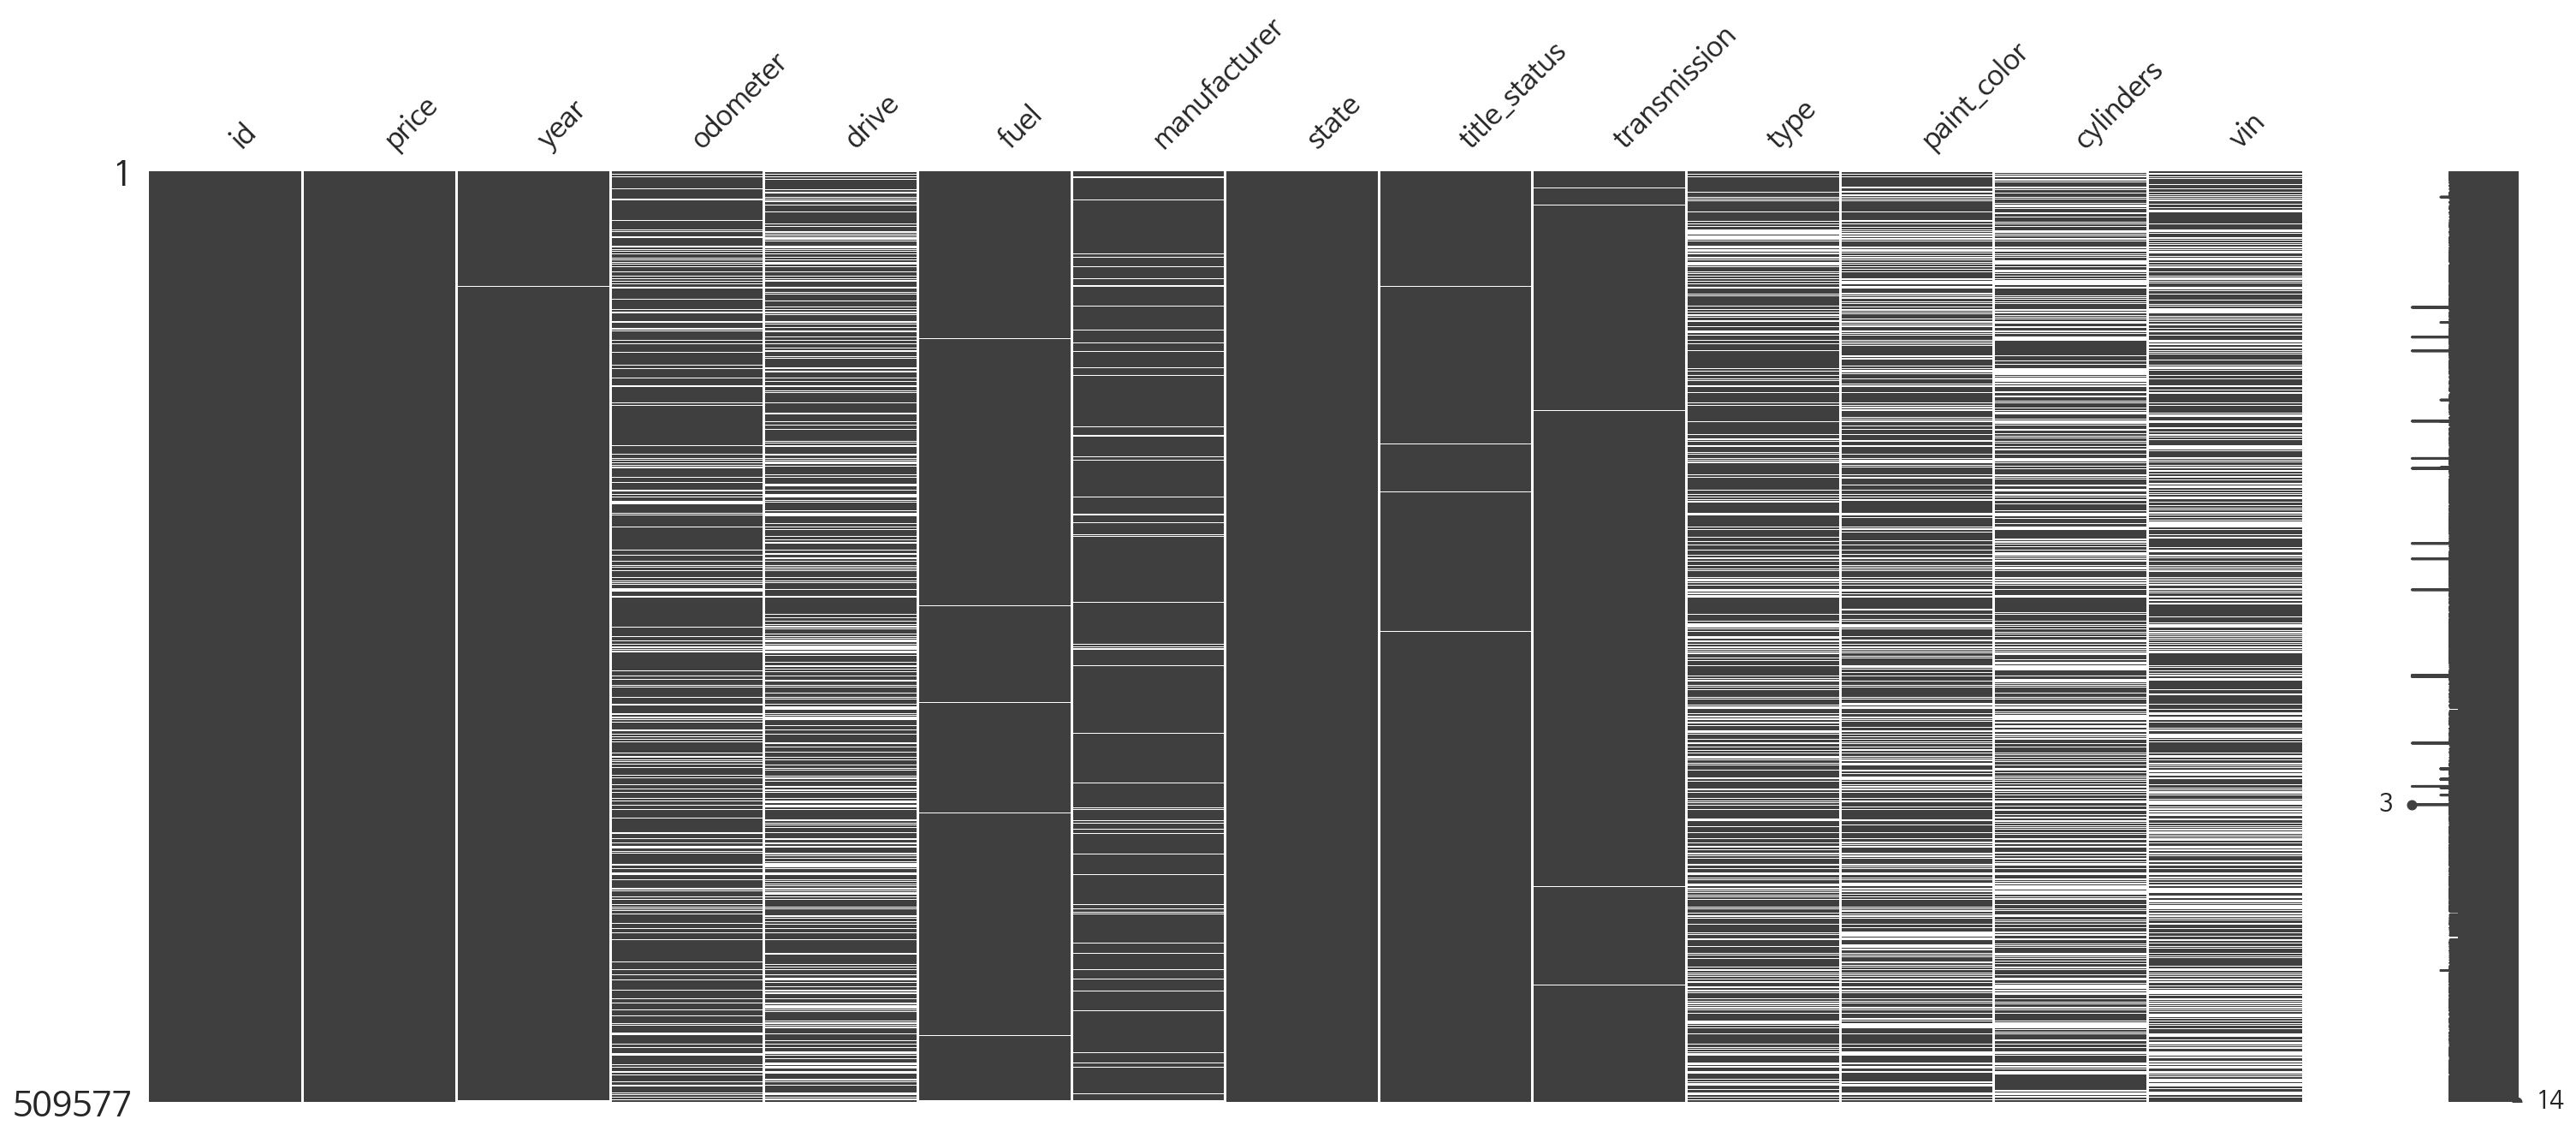

In [187]:
msno.matrix(start_df)
plt.show()

#### 결측치 수치화

In [188]:
def columns_na_percentage(df,columns):
    for column in columns:
        percentage = round(100 -(len(df['{}'.format(column)].dropna()) / len(df)) * 100,2)
        if percentage :
            print("{} : ".format(column), percentage,"%",end='\n')

            
columns_na_percentage(start_df ,start_df.columns)

year :  0.3 %
odometer :  18.12 %
drive :  28.29 %
fuel :  0.78 %
manufacturer :  4.47 %
title_status :  0.6 %
transmission :  0.73 %
type :  27.77 %
paint_color :  32.32 %
cylinders :  39.19 %
vin :  40.71 %


#### 결측치 제거

In [24]:
start_df = start_df.dropna(axis=0)
print("결측치 제거후 Data : ", start_df.shape)

결측치 제거후 Data :  (77602, 14)


# 1-2. 차대 번호(vin)를 활용한 데이터 필터링
- vin : 미국내 차량들이 가지는 고유한 번호

### 데이터 전처리전 price
- 35억 달러등 비정상적으로 가격이 책정 되어있다.
- 중고 매물 판매자가 9999999, 123456790등 특정 패턴을 가지는 가격을 올리는 경우가 있다.

In [20]:
raw_data['price'].describe()

count       509577.0000000
mean         54796.8385190
std        9575025.1228216
min              0.0000000
25%           3995.0000000
50%           9377.0000000
75%          17955.0000000
max     3600028900.0000000
Name: price, dtype: float64

In [21]:
raw_data['price'].sort_values(ascending=False)[:10]

345972    3600028900
264595    3567587328
473874    2521176519
190773    2490531375
353470    1316134912
86485     1234567890
16015     1172420096
73946      999999999
176537     999999999
282099     999999999
Name: price, dtype: int64

## **Step1**
  - 중복된 'vin'을 가지고 있는 데이터 삭제

In [23]:
start_df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
print("중복 vin 삭제 Data : ",start_df.shape)

중복 vin 삭제 Data :  (77602, 14)


## **Step2**
 - 'vinaudit.com'이 제공하는 api를 이용한 허위매물 탐색
 
<img src="./img/img1.png" width="650" style="float:left">

- **데이터 출처**
    - 자동차 이력 제공시스템 : (NMVTIS/National Motor Vehicle Title Information System)
    - 미국 도로교통 안전국 : (NHTSA / National Highway Traffic Safety Administration)
    - 미국 교통부 연방차량안전국 : (Federal Motor Carrier Safety Administration, FMCSA) 
    - 그외 미국 정부 기관과 관련된 업체 및 파트너사

## 크롤링 데이터 분석

|컬럼명|설명|
|:------|:---|
| <span style= 'background:#ADD8E6'>**above** </span>| 최대 가격|
|<span style= 'background:#ADD8E6'>**average**</span> | 평균 가격|
|<span style= 'background:#ADD8E6'>**below**</span> | 최소 가격 |
|**certainty** | 정확도 |
|**count**|  거래 횟수|
|**error** |  에러 메세지 |
|<span style= 'background:#ADD8E6'>**mileage**</span>|  주행 거리 |
|**period**|  거래 시기|
|<span style= 'background:#ADD8E6'>**stdev**</span>|  표준 편차|
|**success**|  성공 여부|
|**vehicle**|  차량 정보 (연식, 제조사, 모델명)|

<img src="./img/img3.png" width="800">

- **vinaudit 데이터 사용처**
    - Vincheck등 중고차 매물 검색 업체
<img src="./img/img5.png" width="250">    
    - NICB (National Insurance Crime Bureau) 등
<img src="./img/img4.png" width="200">

## **Step 3**
- 크롤링 데이터와 중복된 vin이 제거된 데이터를 Merge

In [18]:
vin_crawling_data = pd.read_csv('./final_vin_crawling.csv')
# secend_half_crawling_data = pd.read_csv('./vin_crawling_addtional.csv')
# vin_crawling_data = pd.concat([first_half_crawling_data, secend_half_crawling_data], axis=0)

# 대문자 변경
vin_crawling_data['vin'] = vin_crawling_data['vin'].str.upper()

# 중복제거
vin_crawling_data = vin_crawling_data.drop_duplicates('vin',keep='first')

# 대문자 변경
start_df['vin'] = start_df['vin'].str.upper()

# merge
merged_df = pd.merge(start_df,vin_crawling_data,on='vin')

# 중복 제거
merged_df = merged_df.drop_duplicates('vin',keep='first')

# 필요 없는 컬럼 제거
df = merged_df[merged_df.columns.difference(['id_y','id_x','Unnamed: 0','Unnamed: 0.1','og_vin'])]
print("크롤링 Data와 중복 vin 제거 data가 합쳐진 Data : ", df.shape)

크롤링 Data와 중복 vin 제거 data가 합쳐진 Data :  (77569, 25)


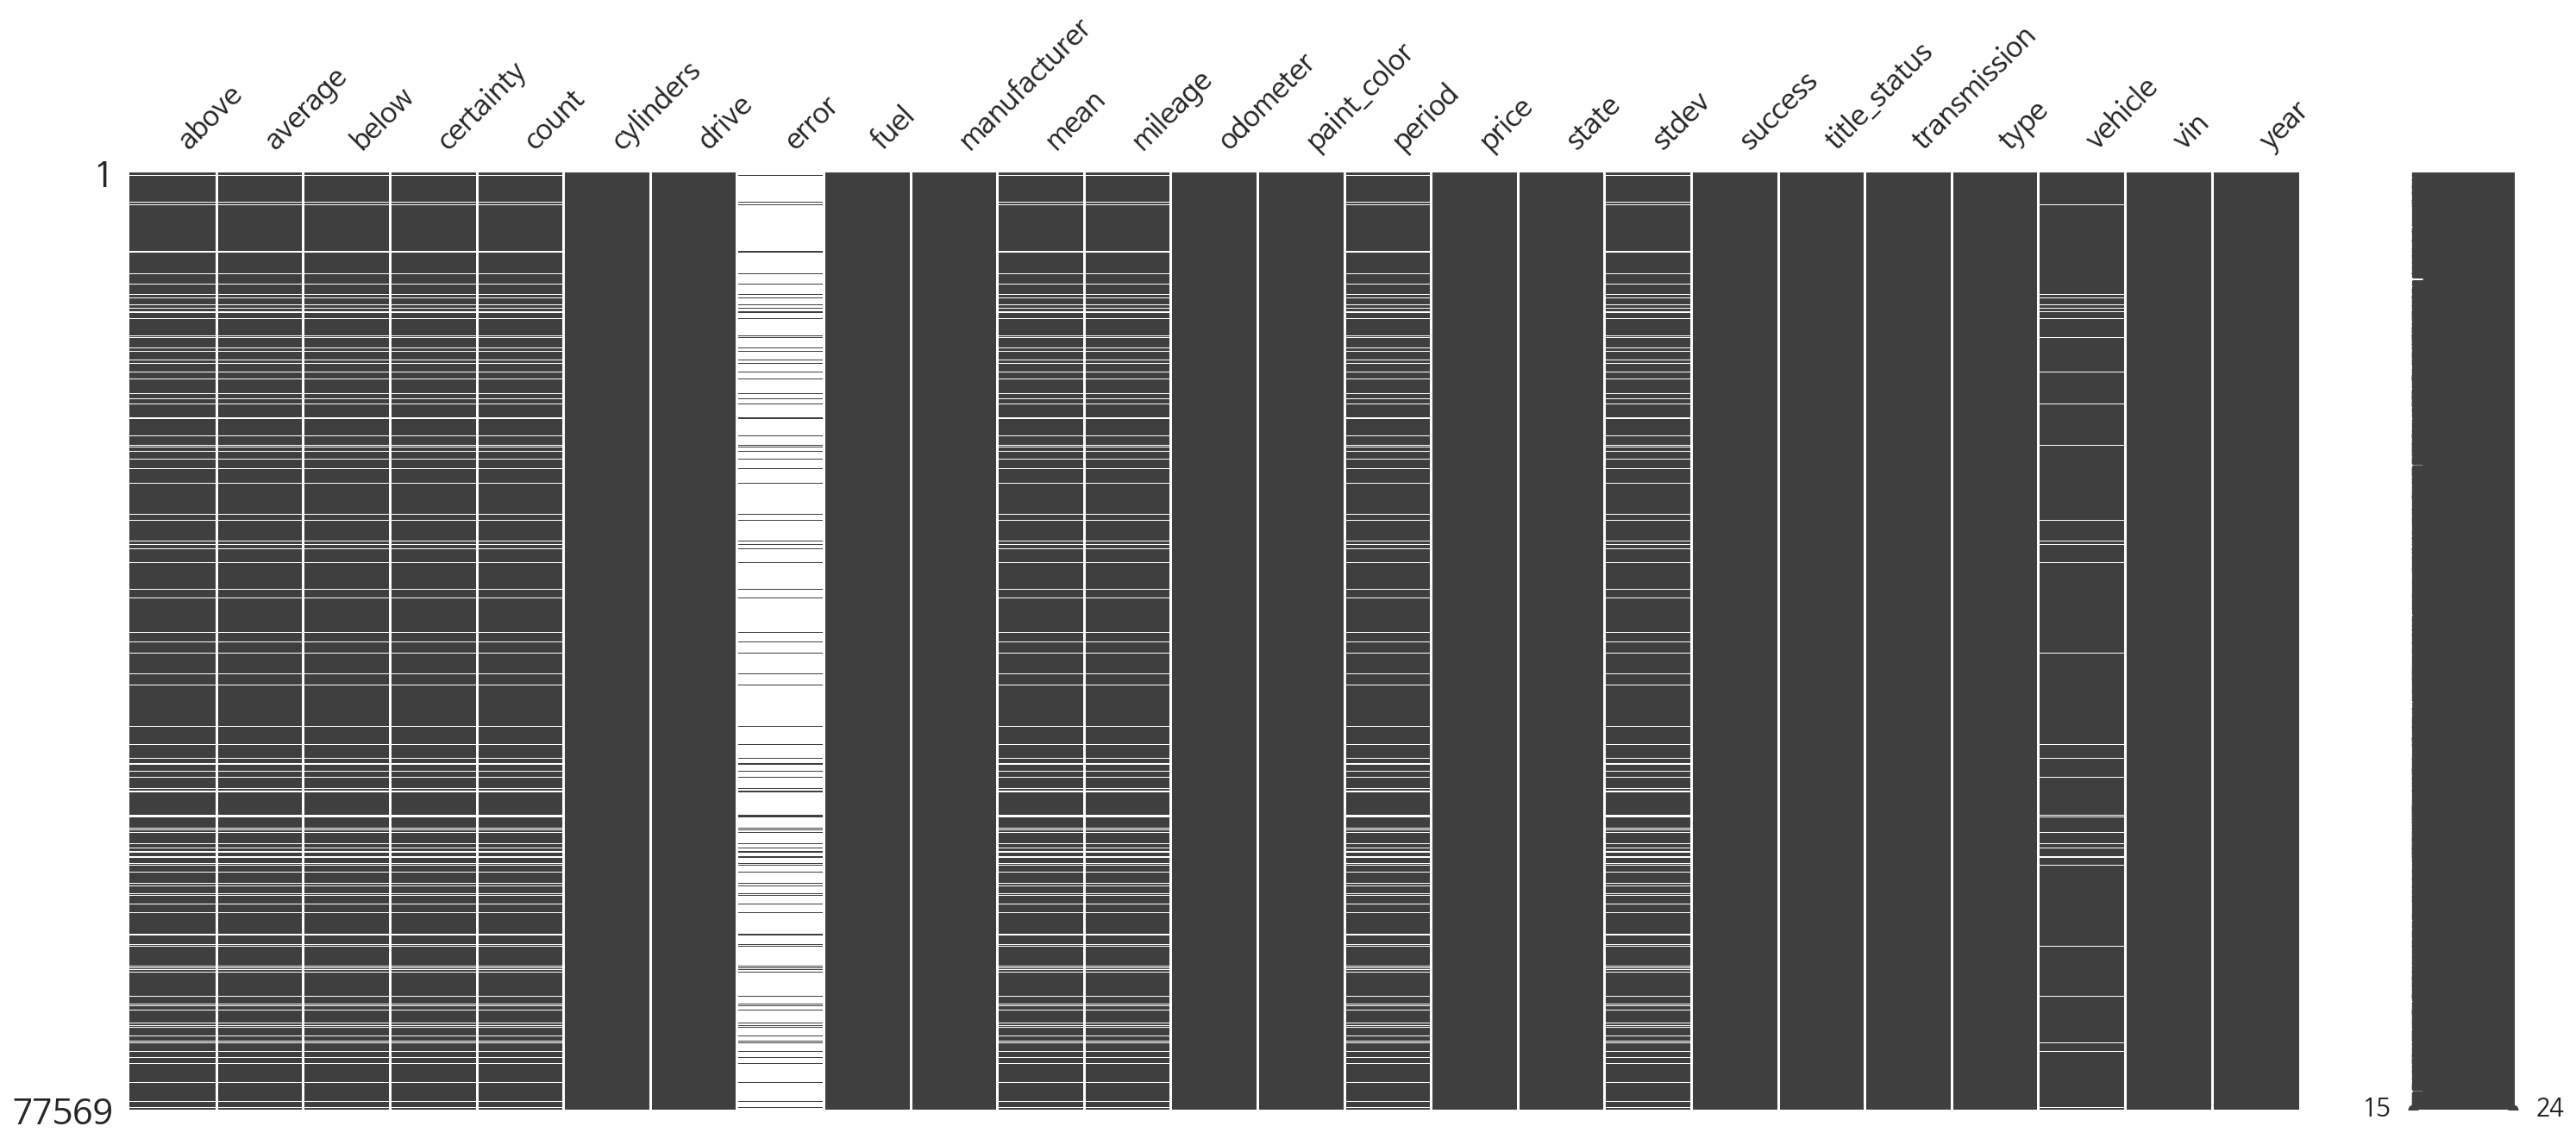

In [25]:
msno.matrix(df)
plt.show()

## **Step 4** - Error 컬럼 
- **'no_data'** : request시에 던져준 'odometer'가 잘못되어 정보를 가져올수 없는 경우, 즉 **이력조회가 되지않는** 차량
- **'invalid_vin'** : request시에 던져준 'vin'이 17자리가 아닌 경우
  - 1980년도 이전에 생산된 차량의 정보는 데이터베이스화 되어있지 않음
  - 판매자가 잘못된 vin값을 입력한 경우

In [26]:
df['error'].value_counts()

no_data        4263
invalid_vin    3038
Name: error, dtype: int64

- 'error'값을 가지고 있는 row들을 제거

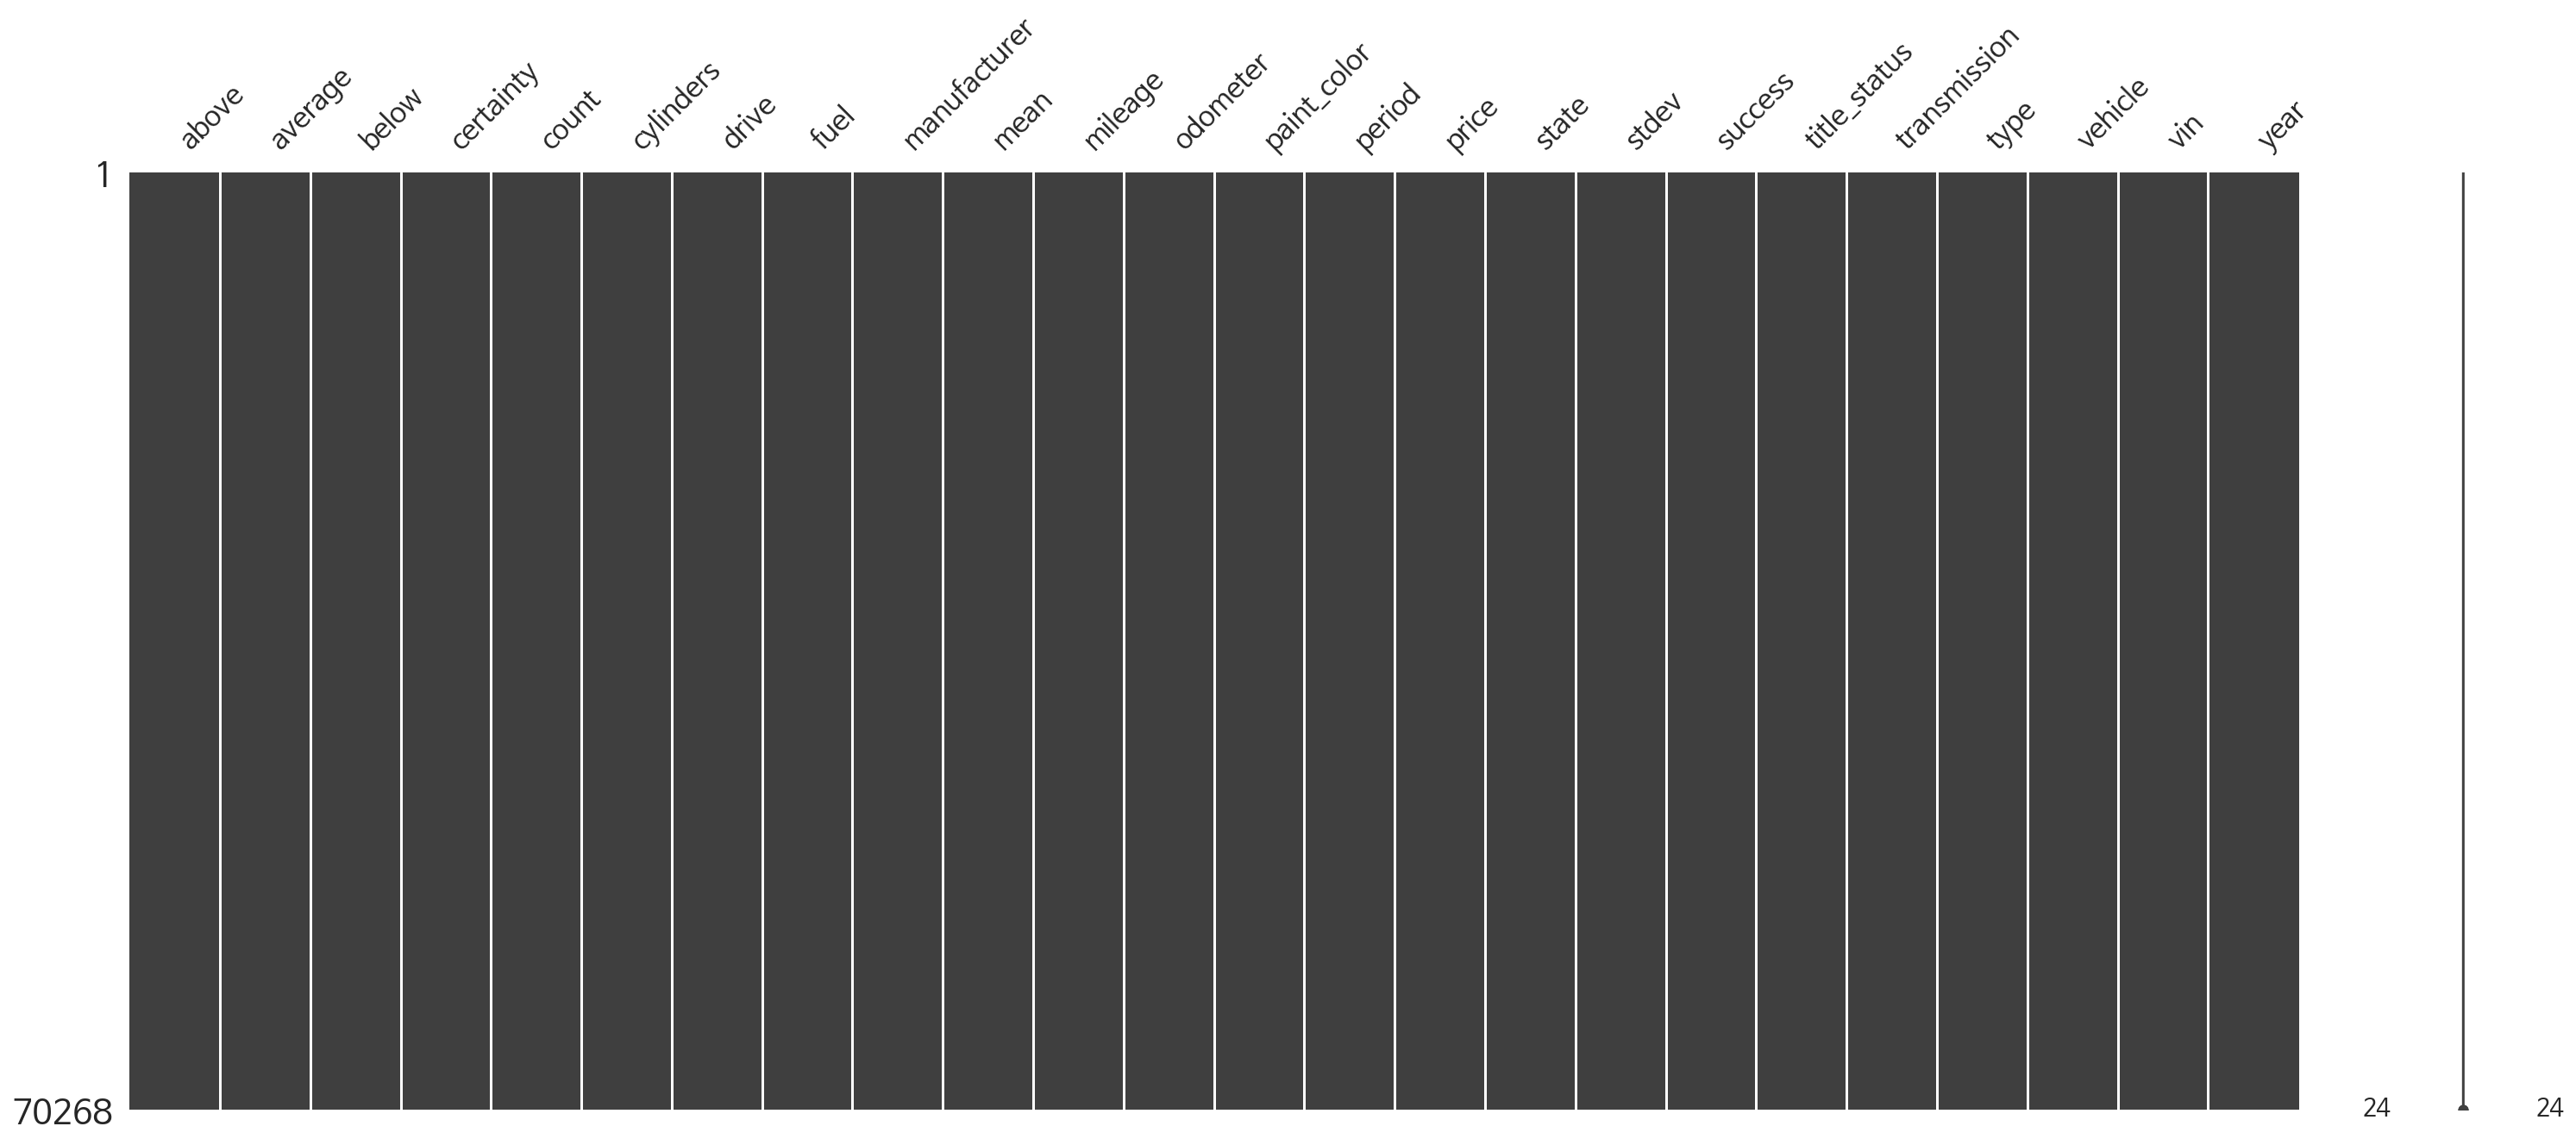

In [27]:
df=df[df.columns.difference(['error'])]
df = df.dropna(axis=0)
msno.matrix(df)
plt.show()

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 2. EDA

## 2-1. 아웃라이어 탐색

### 가격 아웃라이어 탐색

- 크롤링을 통해 획득한 자동차별 평균가격과 표준편차를 이용해 'price'의 아웃라이어를 필터링

In [34]:
df[['above', 'average', 'below','stdev']].head(2)

,above,average,below,stdev
0,20878.9000000,18399.9000000,15920.9000000,2479.0000000
1,8113.7500000,6710.7500000,5307.7500000,1403.0000000


### 평균값과 표준편차를 이용한 데이터 필터링
- '2sigma'에 해당되는 가격 범위 내의 차량만 분석 진행

In [35]:
def get_sigma_data_by_price(num):
    # price가 0인것들 제거
    sigma = df[(df['price'] >= (df['average'] - (df['stdev']*num))) & (df['price'] <= (df['average'] + (df['stdev']*num)))]
    return sigma

sigma_2_df = get_sigma_data_by_price(2)
print("2 sigma Data:", sigma_2_df.shape)

2 sigma Data: (56026, 24)


In [36]:
# year를 int로 형변환
sigma_2_df['year'] = sigma_2_df['year'].astype('int')

### 주행거리 아웃라이어 탐색
- 크롤링으로 획득한 데이터의 'mileage' 컬럼은, 데이터 베이스에 등록 되어있는 차량의 주행거리 (명확한 정보가 없는경우 예상되는 평균 주행거리)
- odometer와 mileage가 다른 데이터 : **판매자가 과도하게 높은 odometer를 입력한 경우**

In [37]:
print("주행거리가 잘못 입력된 차량 대수 : ",len(sigma_2_df[sigma_2_df['mileage'] != sigma_2_df['odometer']]))
sigma_2_df[sigma_2_df['mileage'] != sigma_2_df['odometer']].sort_values(ascending=False,by='odometer').head(2)

주행거리가 잘못 입력된 차량 대수 :  31


,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
51426,10244.9900000,8898.9900000,7552.9900000,81.7000000,9.0000000,6 cylinders,4wd,gas,lexus,8898.9900000,148490.0000000,4706000.0000000,custom,"['2019-10-02', '2020-03-07']",8000,nc,1346.0000000,True,clean,automatic,SUV,2007 Lexus RX 400h Base,JTJHW31UX72010051,2007
8407,5276.6000000,4335.6000000,3394.6000000,65.0000000,4.0000000,8 cylinders,4wd,gas,dodge,4335.6000000,180265.0000000,4000085.0000000,custom,"['2019-10-05', '2020-01-15']",3995,al,941.0000000,True,clean,automatic,SUV,2004 Dodge Durango SLT,1D4HB48N44F169643,2004


In [38]:
sigma_2_df = sigma_2_df[sigma_2_df['mileage'] == sigma_2_df['odometer']]

### 박스플롯, 스캐터 플롯

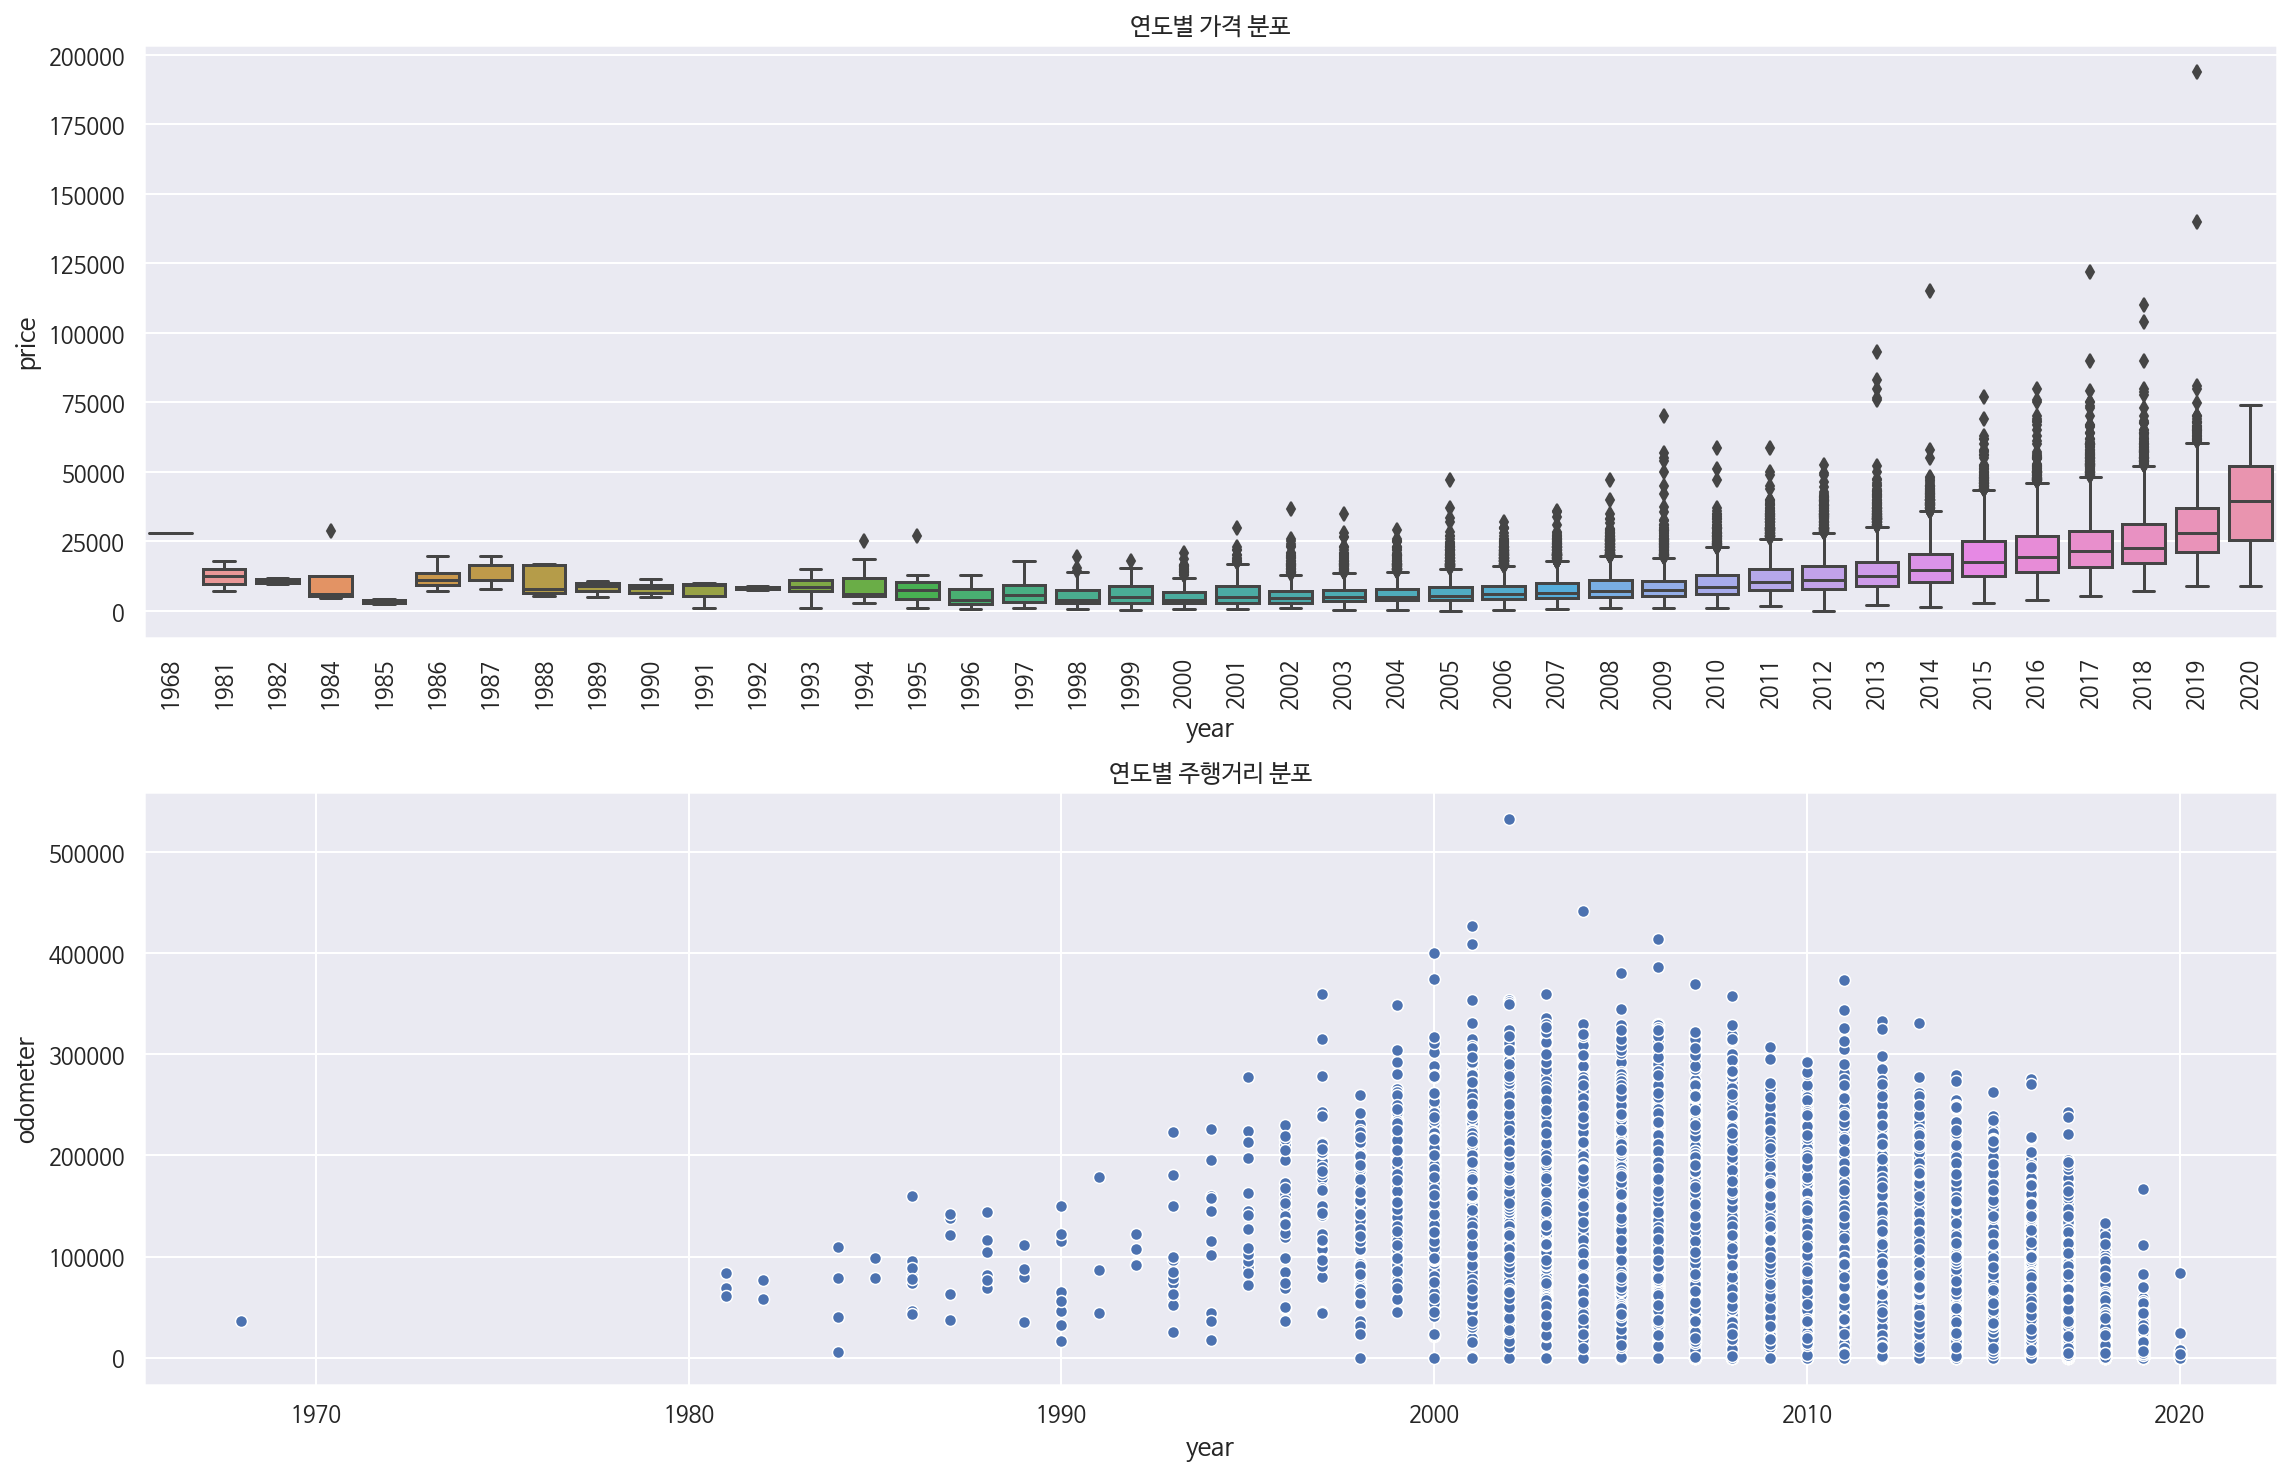

In [39]:
plt.figure(figsize=(16,15))
plt.subplot(311)
sns.boxplot(x="year", y="price", data = sigma_2_df)
plt.xticks(rotation=90)
plt.title('연도별 가격 분포')
plt.subplot(312)
sns.scatterplot(sigma_2_df['year'],sigma_2_df['odometer'])
plt.title("연도별 주행거리 분포")
plt.tight_layout()
plt.show()

## 플롯 그린후 눈으로 본 데이터

### 연식
- 차량 연식이 1980년도 이전에 존재하는 데이터 확인

In [40]:
# year 수정해 줘야 하는 데이터
sigma_2_df[sigma_2_df['year'] < 1980]

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
49431,31752.0900000,28691.0900000,25630.0900000,99.0000000,240.0000000,8 cylinders,rwd,gas,pontiac,28691.0900000,36211.0000000,36211.0000000,blue,"['2019-12-14', '2020-03-26']",27988,mt,3061.0000000,True,clean,automatic,other,2019 Toyota Sienna,5TDYZ3DC0KS008940,1968


In [41]:
sigma_2_df['year'] = sigma_2_df['year'].apply(lambda x : 2019 if x < 1980 else x)

### 주행거리
  - 주행거리가 가장 높은 차량 확인

In [42]:
sigma_2_df[sigma_2_df['odometer'] > 500000]

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
28776,9045.7000000,6984.7000000,4923.7000000,65.0000000,4.0000000,8 cylinders,4wd,gas,toyota,6984.7000000,533000.0000000,533000.0000000,grey,"['2019-10-03', '2020-02-20']",6500,ga,2061.0000000,True,clean,automatic,SUV,2002 Toyota Land Cruiser Base,JTEHT05J722017912,2002


- **약 18년간 운행한 자동차의 일 평균 주행거리 계산**

In [43]:
print("평균 주행거리 : ", round(533000.00 / (365 * 18), 2),"마일/day")

평균 주행거리 :  81.13 마일/day


### 가격
  - 75000불 초과 차량 확인

In [44]:
sigma_2_df[sigma_2_df['price'] > 75000].sort_values(by=['price'],ascending=False).head()

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
60128,202032.5600000,182660.5600000,163288.5600000,90.0000000,16.0000000,8 cylinders,4wd,gas,mercedes-benz,182660.5600000,7584.0000000,7584.0000000,white,"['2019-10-03', '2020-03-26']",193982,oh,19372.0000000,True,clean,automatic,SUV,2019 Mercedes-Benz,WDCYC7HJ3KX301396,2019
29627,149400.5800000,132238.5800000,115076.5800000,70.3000000,5.0000000,3 cylinders,4wd,hybrid,bmw,132238.5800000,649.0000000,649.0000000,grey,"['2019-10-05', '2020-03-14']",139995,hi,17162.0000000,True,clean,automatic,convertible,2019 BMW,WBY2Z6C52KVB82784,2019
20351,130595.3800000,124912.3800000,119229.3800000,79.6000000,8.0000000,10 cylinders,4wd,gas,audi,124912.3800000,25624.0000000,25624.0000000,red,"['2019-10-06', '2020-03-19']",121995,co,5683.0000000,True,clean,automatic,coupe,2017 Audi R8 (V10 quattro),WUAEAAFX4H7901309,2017
10976,125445.6700000,119893.6700000,114341.6700000,74.2000000,6.0000000,8 cylinders,rwd,gas,ferrari,119893.6700000,12986.0000000,12986.0000000,black,"['2019-10-03', '2020-03-22']",114950,az,5552.0000000,True,clean,automatic,convertible,2014 Ferrari California Base,ZFF65TJAXE0200770,2014
73531,117293.9400000,105051.9400000,92809.9400000,90.7000000,17.0000000,8 cylinders,rwd,gas,mercedes-benz,105051.9400000,5560.0000000,5560.0000000,black,"['2019-10-01', '2020-03-26']",109995,tx,12242.0000000,True,clean,automatic,convertible,2018 Mercedes-Benz AMG GT Base,WDDYK7HA6JA014263,2018


- 500불 미만 차량 확인

In [45]:
sigma_2_df[sigma_2_df['price'] < 500].sort_values(by=['price'],ascending=False)

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
22916,1708.6900000,1139.6900000,570.6900000,57.3000000,3.0000000,4 cylinders,4wd,gas,honda,1139.6900000,380774.0000000,380774.0000000,silver,"['2020-02-21', '2020-03-11']",390,de,569.0000000,True,clean,automatic,sedan,2005 Honda Civic LX,2HGES16695H615734,2005
39176,280.5700000,242.5700000,204.5700000,44.3000000,2.0000000,8 cylinders,fwd,gas,lincoln,242.5700000,180000.0000000,180000.0000000,red,"['2019-11-01', '2019-12-04']",300,la,38.0000000,True,clean,automatic,sedan,1999 Lincoln Continental Base,1LNHM97V3XY629191,1999
38722,18636.2000000,12424.2000000,6212.2000000,44.3000000,2.0000000,8 cylinders,rwd,other,chevrolet,12424.2000000,158389.0000000,158389.0000000,white,"['2019-10-10', '2019-10-10']",150,ky,6212.0000000,True,clean,automatic,van,2012 Chevrolet Express Cargo 2500,1GCWGFBA7C1155304,2012
38633,11662.9500000,7775.9500000,3888.9500000,44.3000000,2.0000000,8 cylinders,rwd,other,chevrolet,7775.9500000,220790.0000000,220790.0000000,white,"['2019-10-10', '2019-10-10']",131,ky,3887.0000000,True,clean,automatic,van,2012 Chevrolet Express Cargo 2500,1GCWGFBA8C1126880,2012
24512,4792.7800000,3195.7800000,1598.7800000,44.3000000,2.0000000,6 cylinders,fwd,gas,ford,3195.7800000,146221.0000000,146221.0000000,white,"['2019-10-08', '2019-10-15']",85,fl,1597.0000000,True,clean,automatic,SUV,2005 Ford Escape XLT,1FMCU03115KA47874,2005


In [46]:
# 이상치 가격을 보이는 차량 제거
sigma_2_df = sigma_2_df[(sigma_2_df['vin'] != '1GCWGFBA7C1155304') & (sigma_2_df['vin'] != '1GCWGFBA8C1126880') & (sigma_2_df['vin'] != '1FMCU03115KA47874')]

### 가격과 주행거리가 0인 데이터 제거
- 'price', 'odometer'를 판매자가 의도적으로 0으로 책정한 경우

In [47]:
print("판매자가 주행거리를 0으로 올려둔 경우 : ",len(sigma_2_df[sigma_2_df['odometer'] == 0]),"건")
sigma_2_df[sigma_2_df['odometer'] == 0].head(2)
sigma_2_df= sigma_2_df[sigma_2_df['odometer'] != 0]

판매자가 주행거리를 0으로 올려둔 경우 :  50 건


In [48]:
# vinaudit에서 가격을 예측 했으나, 판매자가 가격을 매기지 않고 0이라고 올려둔 경우
print("판매자가 가격을 매기지 않고 0이라고 올려둔 경우 : ",len(sigma_2_df[sigma_2_df['price'] == 0]),"건")
sigma_2_df[sigma_2_df['price'] == 0].head(2)
sigma_2_df= sigma_2_df[sigma_2_df['price'] != 0]

판매자가 가격을 매기지 않고 0이라고 올려둔 경우 :  0 건


### 분석에 필요한 컬럼으로 정리

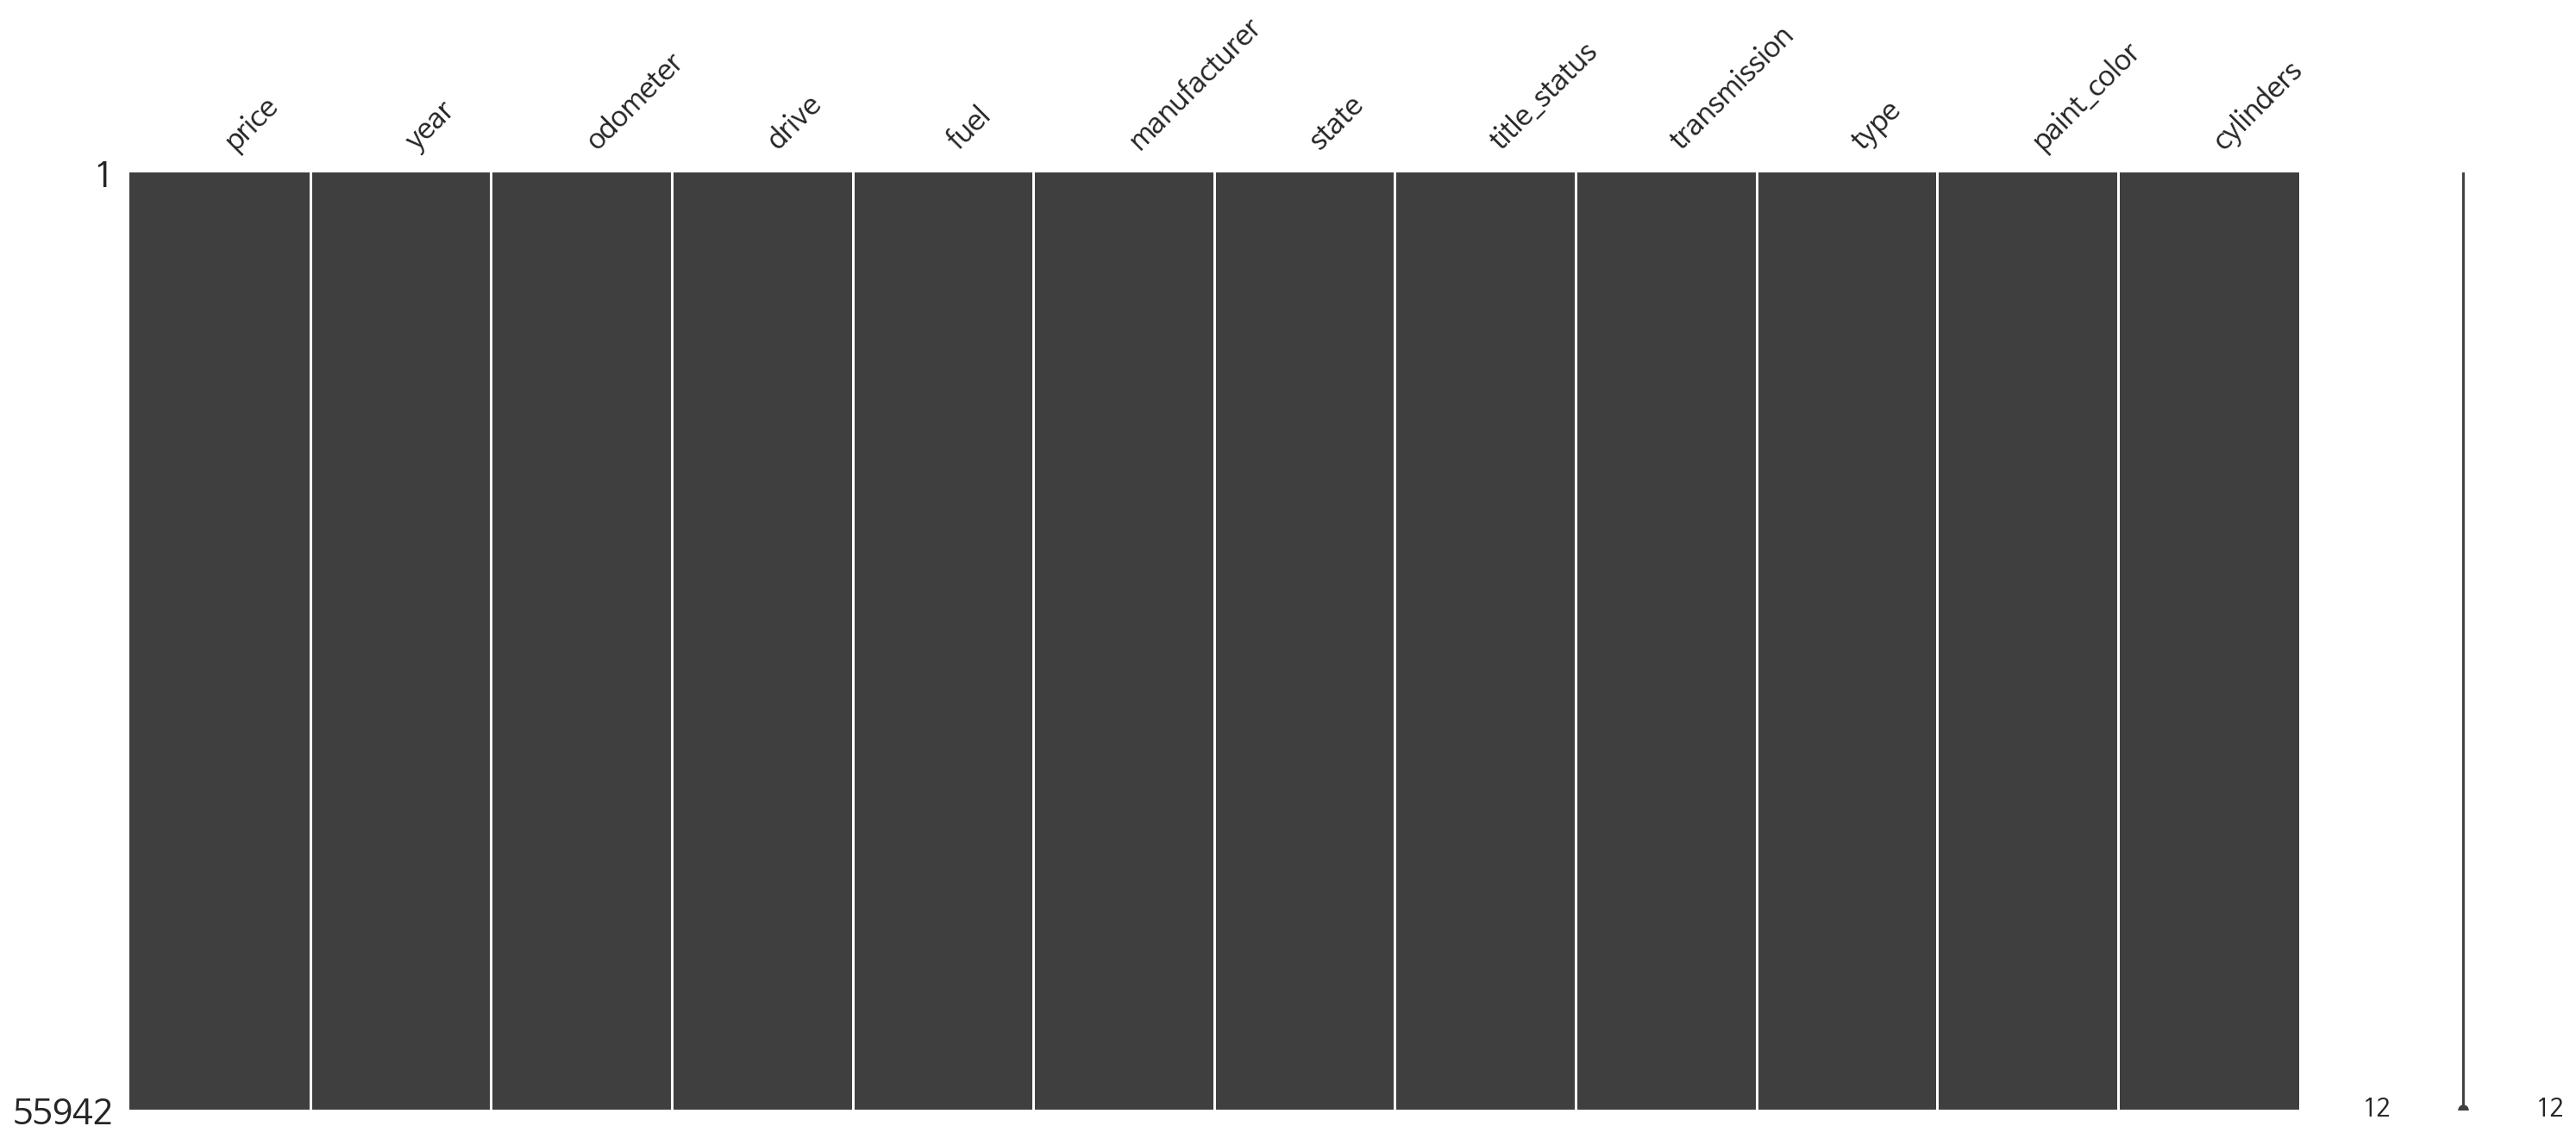

In [49]:
df = sigma_2_df[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
df = df.reset_index(drop=True)
msno.matrix(df)
plt.show()

## 2-2. 종속변수, 독립변수 탐색

### 종속변수 - 가격(price)

In [50]:
df.price.sort_values(ascending=False)[:20]

43793    193982
21387    139995
14953    121995
8499     114950
53103    109995
10835    103999
45103     92991
21529     89995
11929     89800
44959     82991
21359     80905
55921     79997
41133     79995
9982      79990
14564     79970
13568     78988
47094     78900
10621     77500
22379     76993
30253     76525
Name: price, dtype: int64

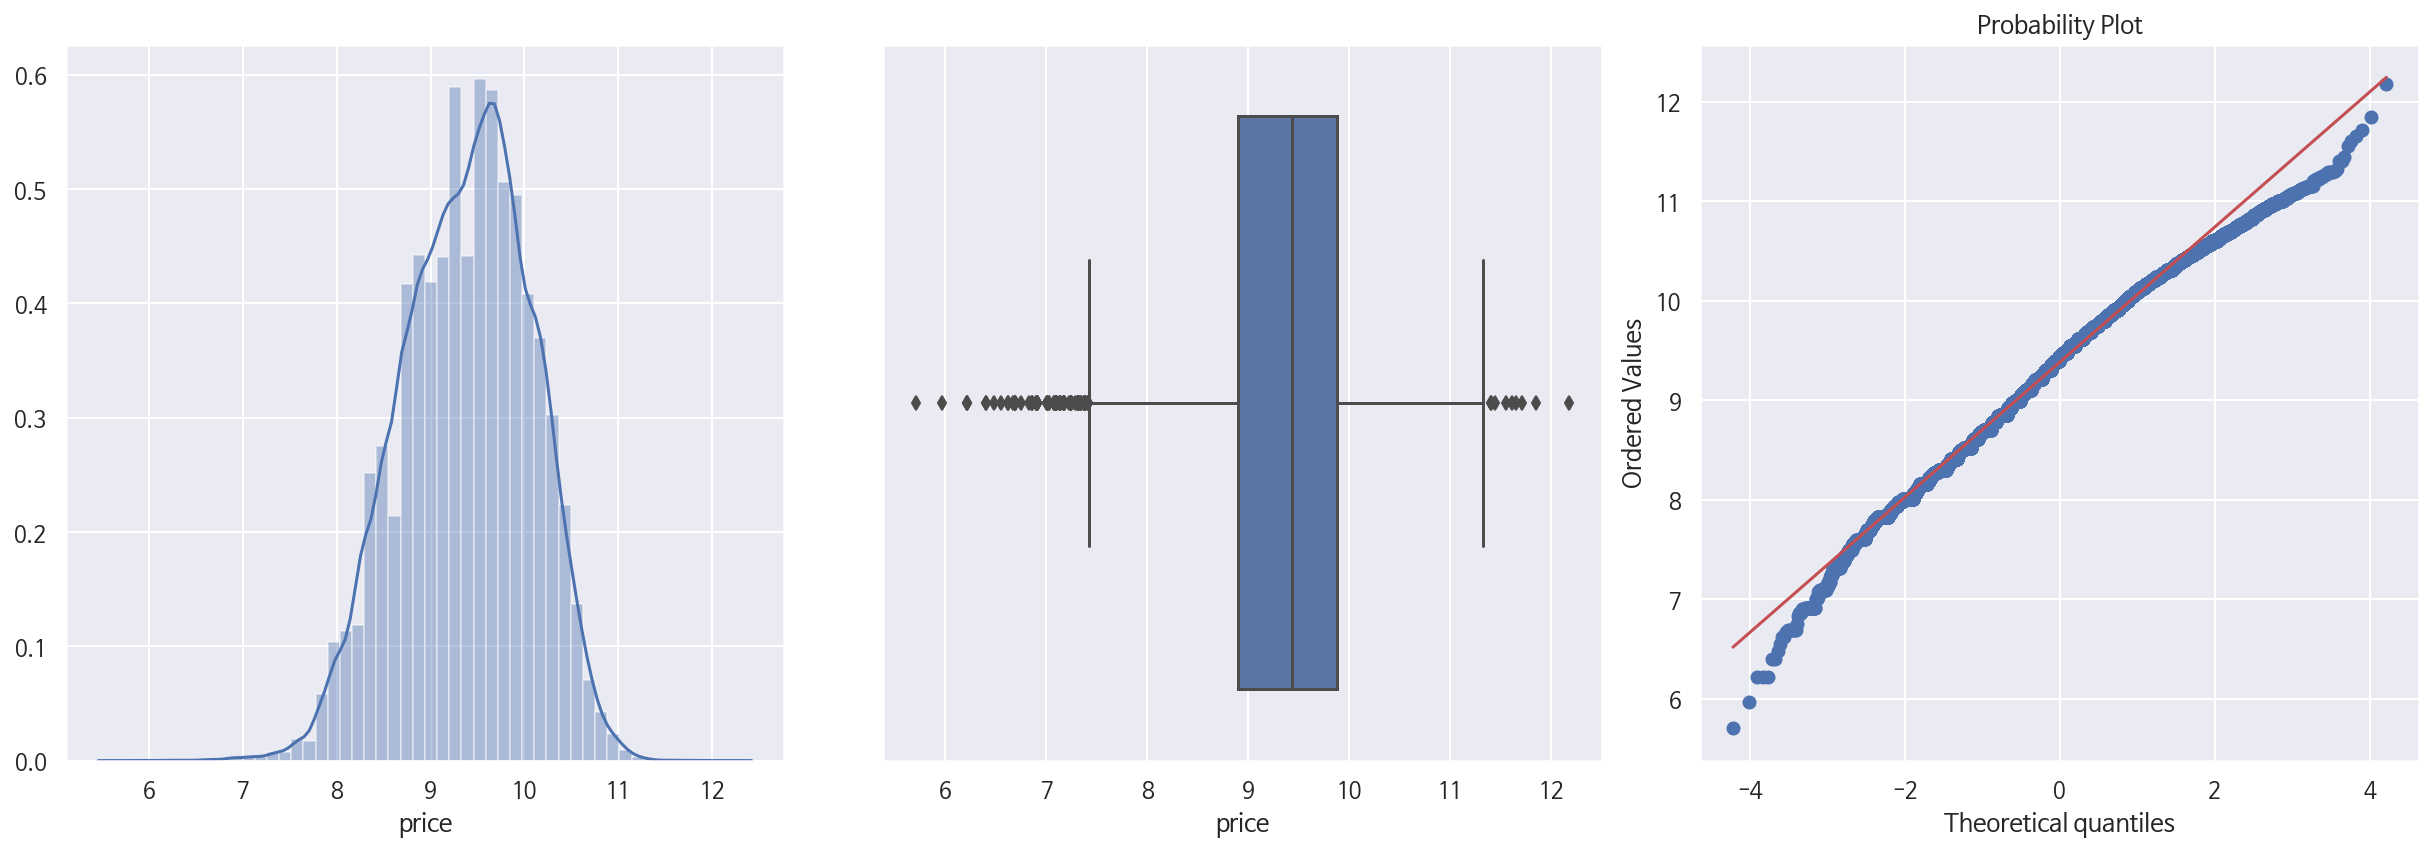

In [51]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log(df['price']))

plt.subplot(132)
sns.boxplot(np.log(df['price']))

plt.subplot(133)
stats.probplot(np.log(df['price']),plot=plt)
plt.tight_layout()
plt.show()

## 독립변수

### 연식 - yaer

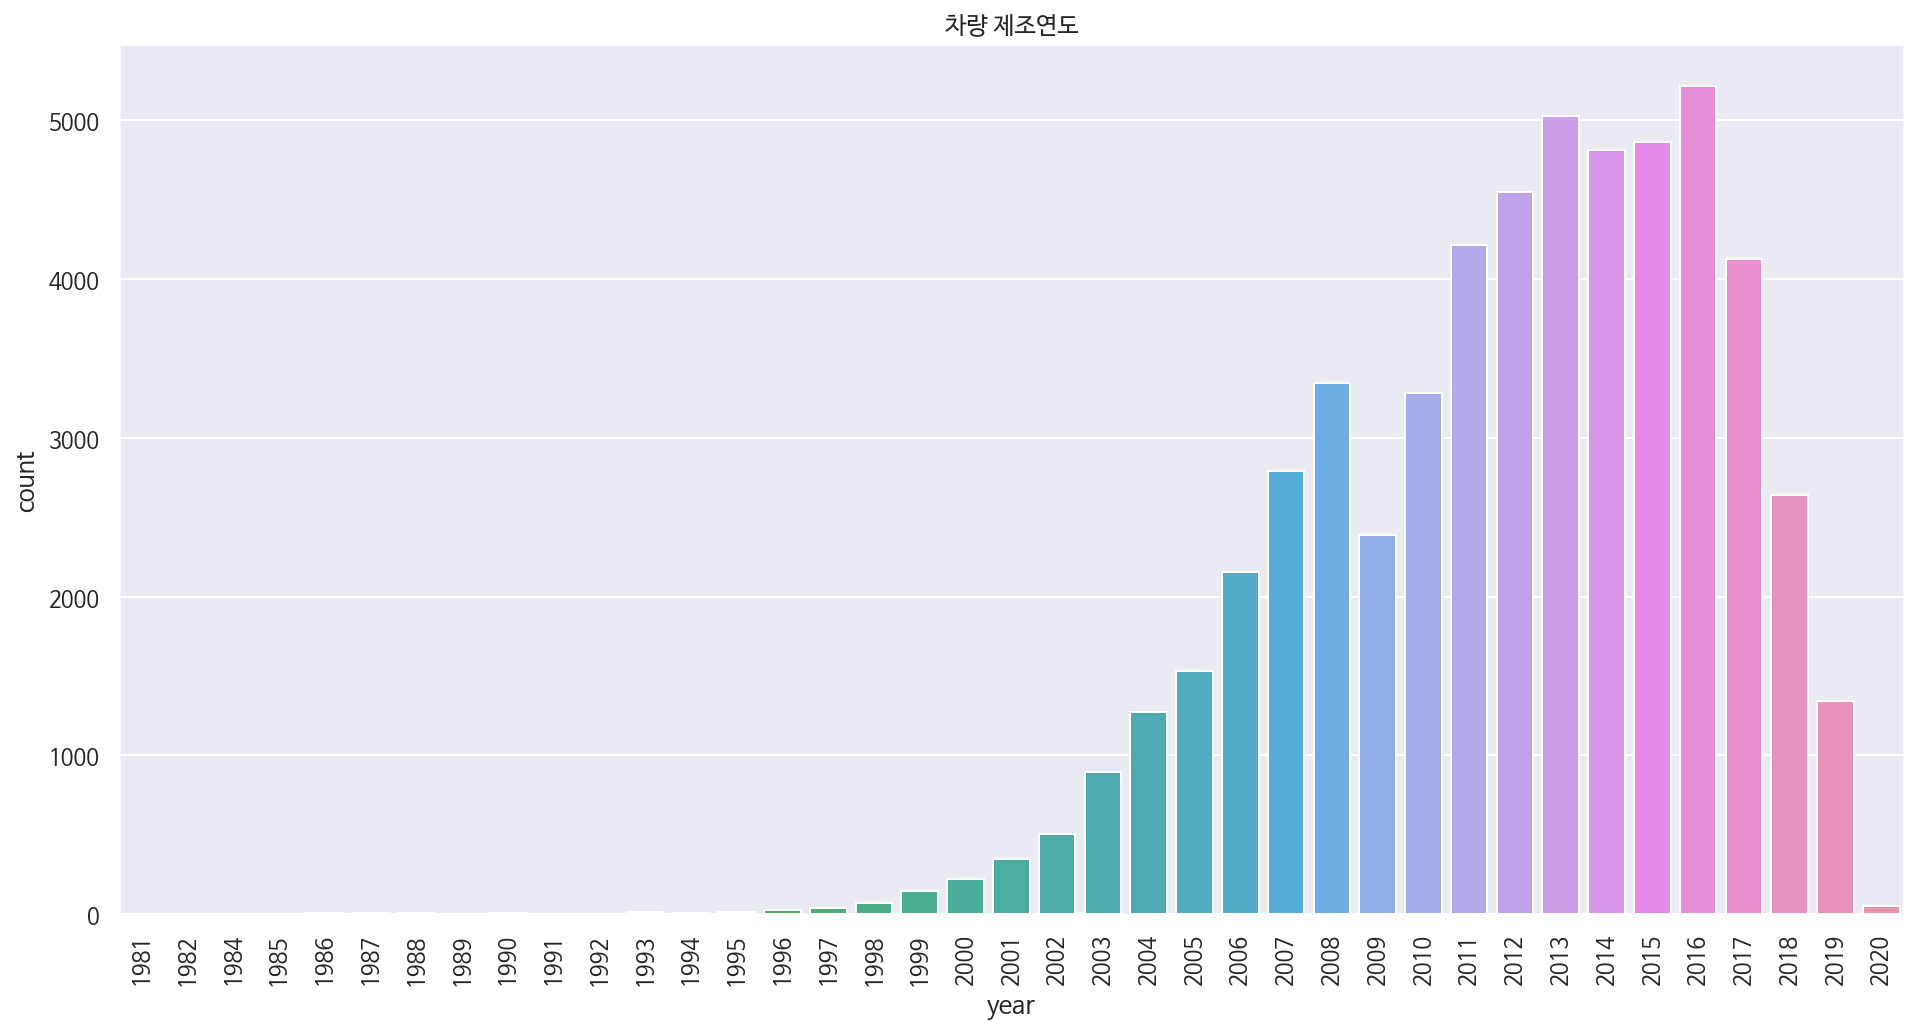

In [52]:
plt.figure(figsize=(16,8))
sns.countplot(
    df['year']
)
plt.title("차량 제조연도")
plt.xticks(rotation=90)
plt.show()

### 2009년 급감한 그래프?

<img src="./img/8.png" width="1100">

#### 당시 미국 자동차 업계의 상황
- 2007년 서브프라임 모기지(비우량 주택 담보 대출) 부실 사태로 촉발된 글로벌 금융 위기 발생

- 2008년 리먼브라더스 파산으로 확산, 그 여파로 미국 자동차 BIG3(GM, Ford, Chrysler)가 파산 위기에 놓임.

- 금융위기 당시 세계 자동차 시장이 급격히 위축되며, 북미 자동차 생산량과 판매량은 2009년 최저치를 경신

- 출처 : Kotra http://news.kotra.or.kr/user/globalBbs/kotranews/3/globalBbsDataView.do?setIdx=242&dataIdx=180910

### 주행거리 - odometer

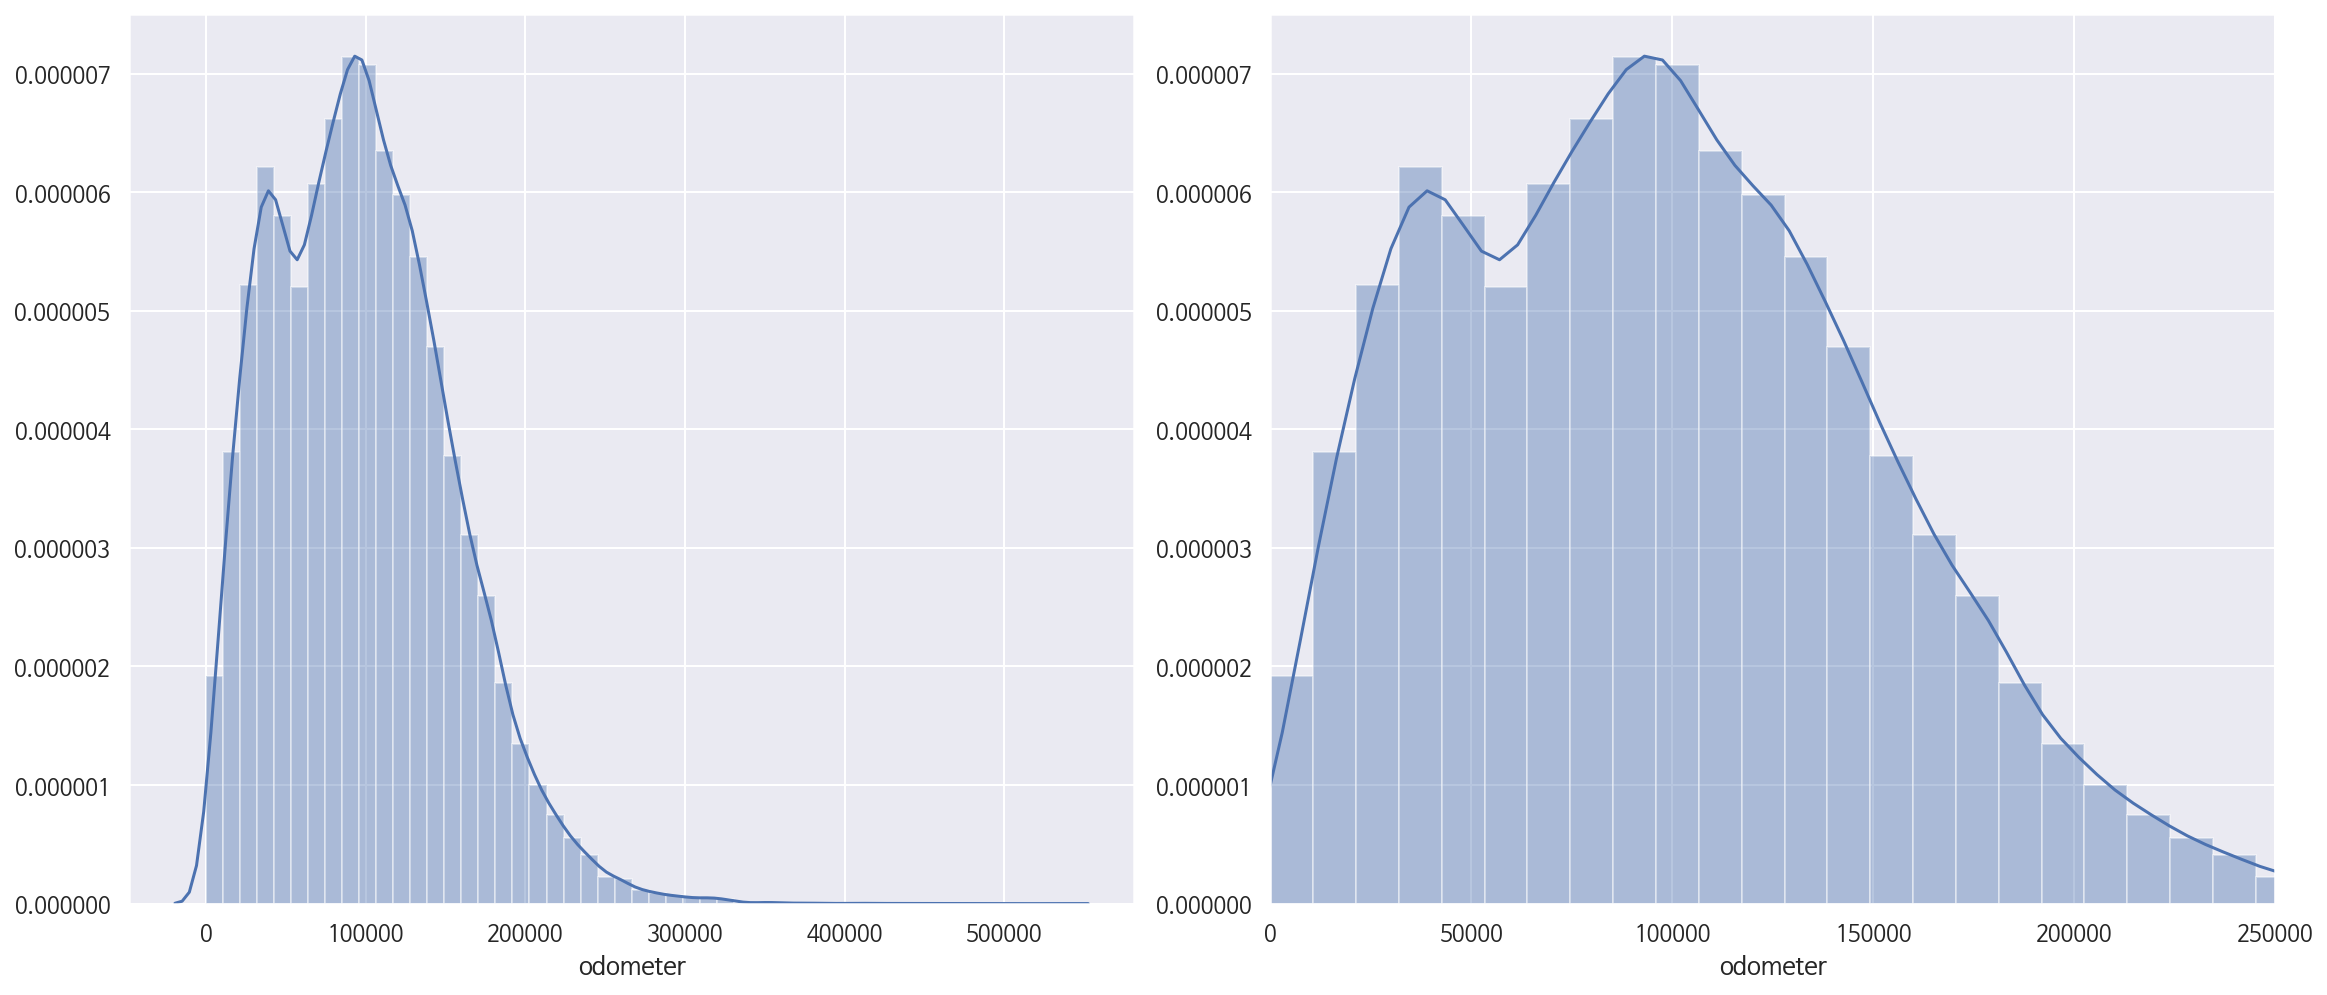

In [53]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.distplot(df['odometer'])
plt.subplot(122)
sns.distplot(df['odometer'])
plt.tight_layout()
plt.xlim(0,250000)
plt.show()

### 카테고리 독립변수 확인

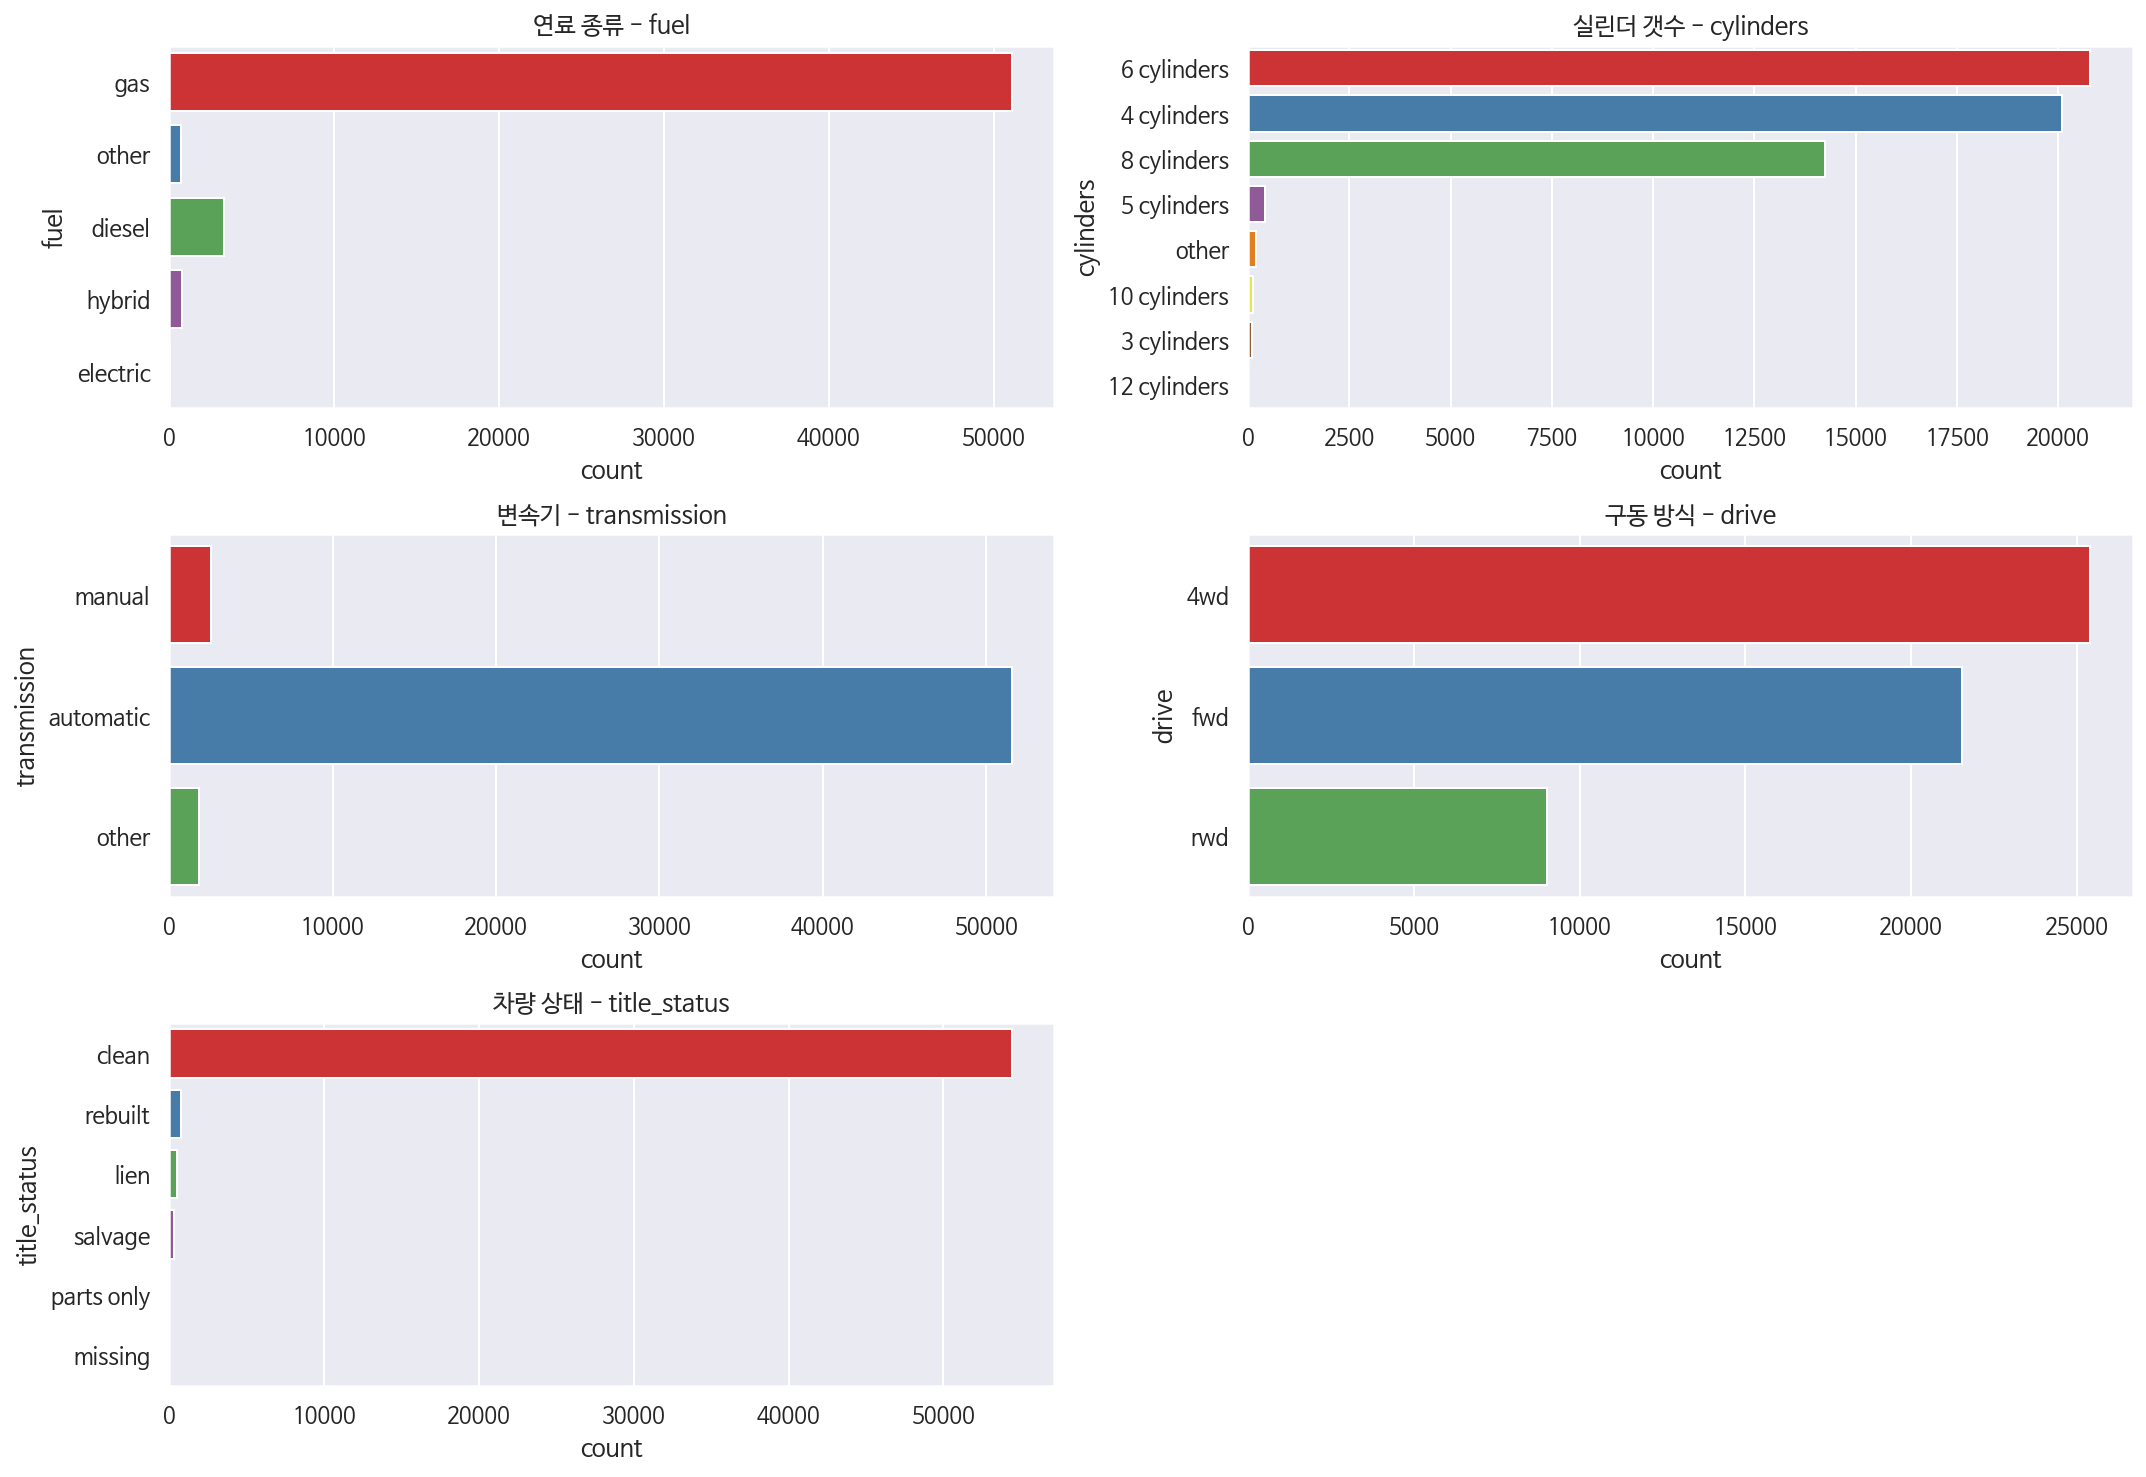

In [54]:
plt.figure(figsize=(15,20))
plt.subplot(621)
sns.countplot(
    data = df,
    y = "fuel",
    palette='Set1',
)
plt.title("연료 종류 - fuel")


plt.subplot(622)
sns.countplot(
    data = df,
    y = "cylinders",
    palette='Set1',
    order = df['cylinders'].value_counts().index

)
plt.title("실린더 갯수 - cylinders")


plt.subplot(623)
sns.countplot(
    data = df,
    y = "transmission",
    palette='Set1'
)
plt.title("변속기 - transmission")

plt.subplot(624)
sns.countplot(
    data = df,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식 - drive")


plt.subplot(625)
sns.countplot(
    data = df,
    y = "title_status",
    palette='Set1'
)
plt.title("차량 상태 - title_status")


plt.tight_layout()
plt.show()


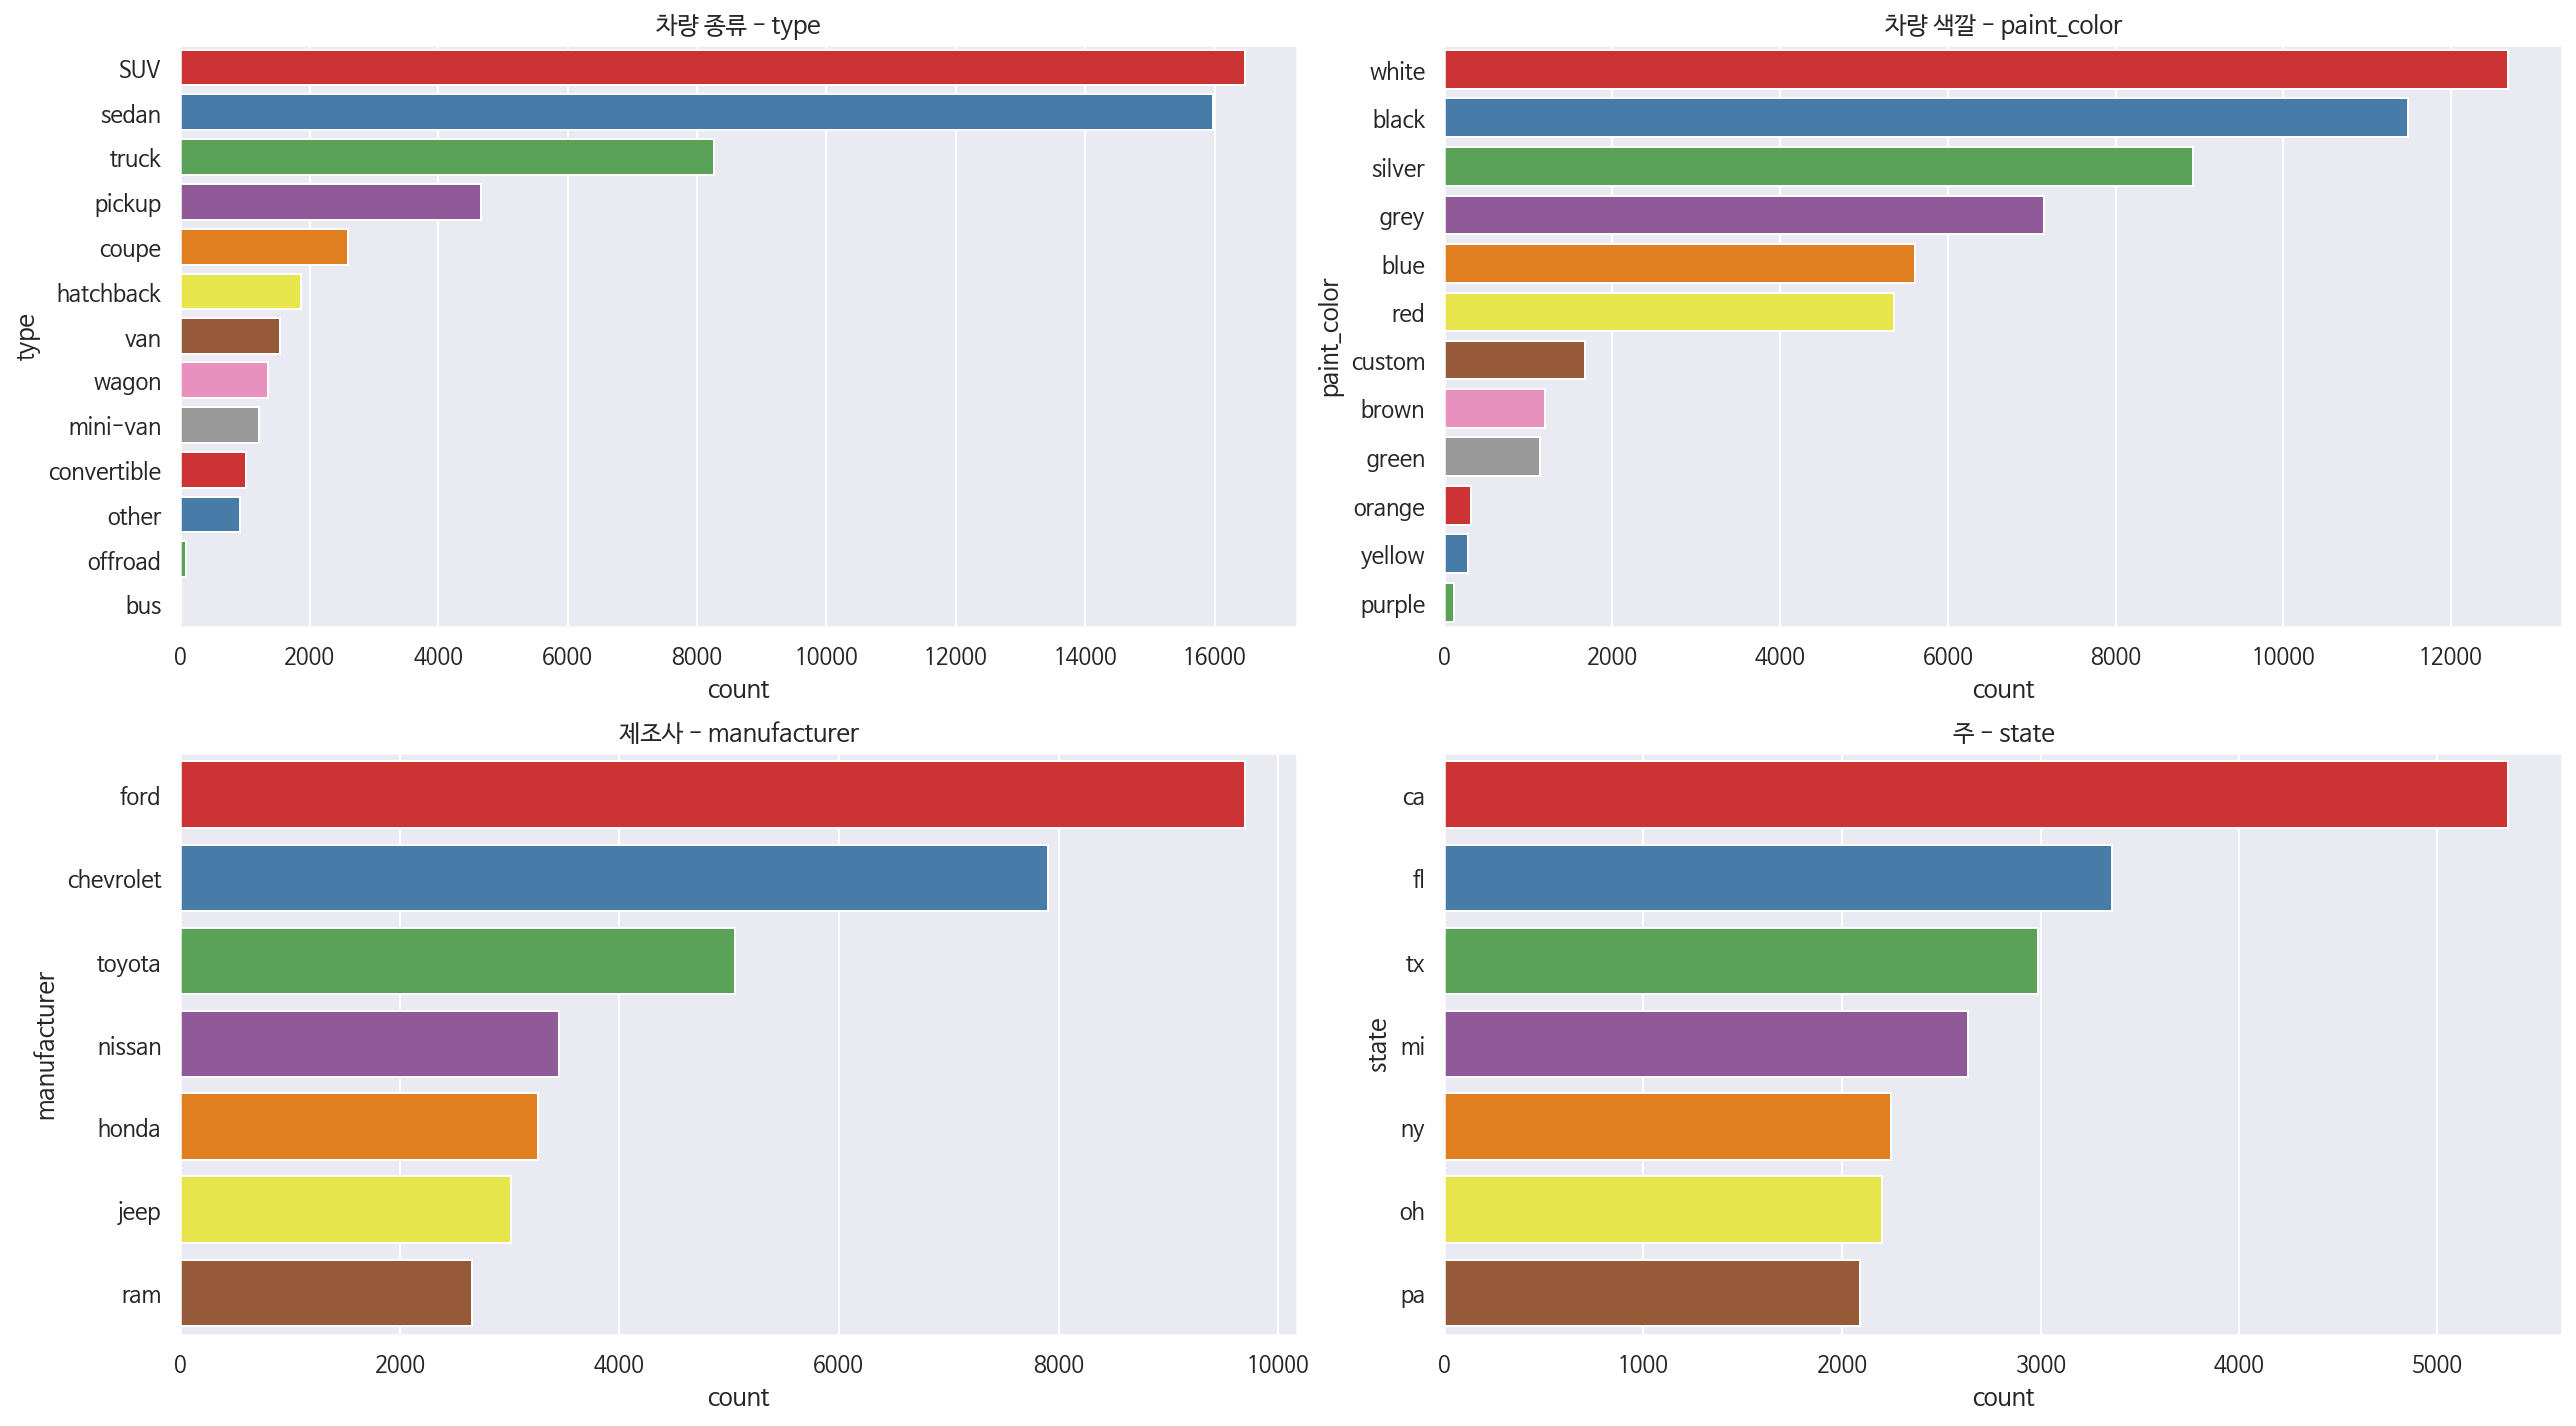

In [55]:
plt.figure(figsize=(18,10))

plt.subplot(221)
sns.countplot(
    data = df,
    y = "type",
    palette='Set1',
    order = df['type'].value_counts().index
)
plt.title("차량 종류 - type")


plt.subplot(222)
sns.countplot(
    data = df,
    y = "paint_color",
    palette='Set1',
    order = df['paint_color'].value_counts().index

)
plt.title("차량 색깔 - paint_color")

plt.subplot(223)
sns.countplot(
    data = df,
    y = "manufacturer",
    palette='Set1',
    order = df['manufacturer'].value_counts().iloc[:7].index,

)
plt.title("제조사 - manufacturer")

plt.subplot(224)
sns.countplot(
    data = df,
    y = "state",
    palette='Set1',
    order = df['state'].value_counts().iloc[:7].index
)
plt.title("주 - state")
plt.tight_layout()
plt.show()

# 2-3. 변수 상관분석

### Pairplot

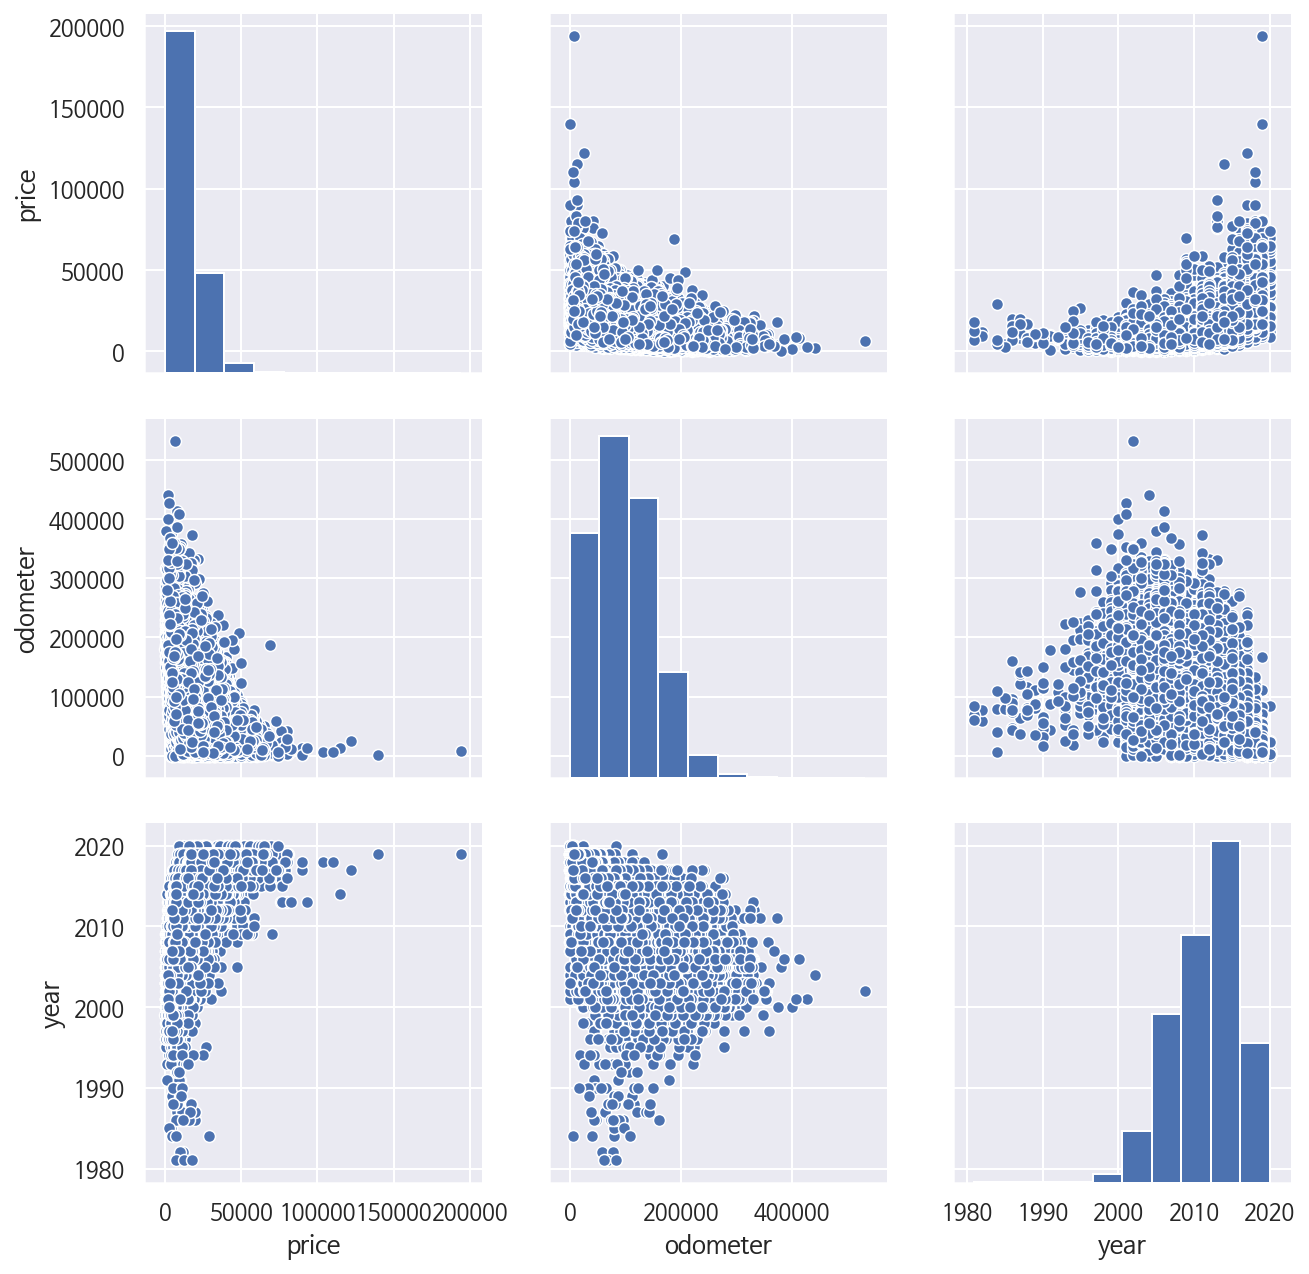

In [56]:
sns.pairplot(df[['price','odometer','year']],size=3)
plt.show()

### Partial Regression Plot

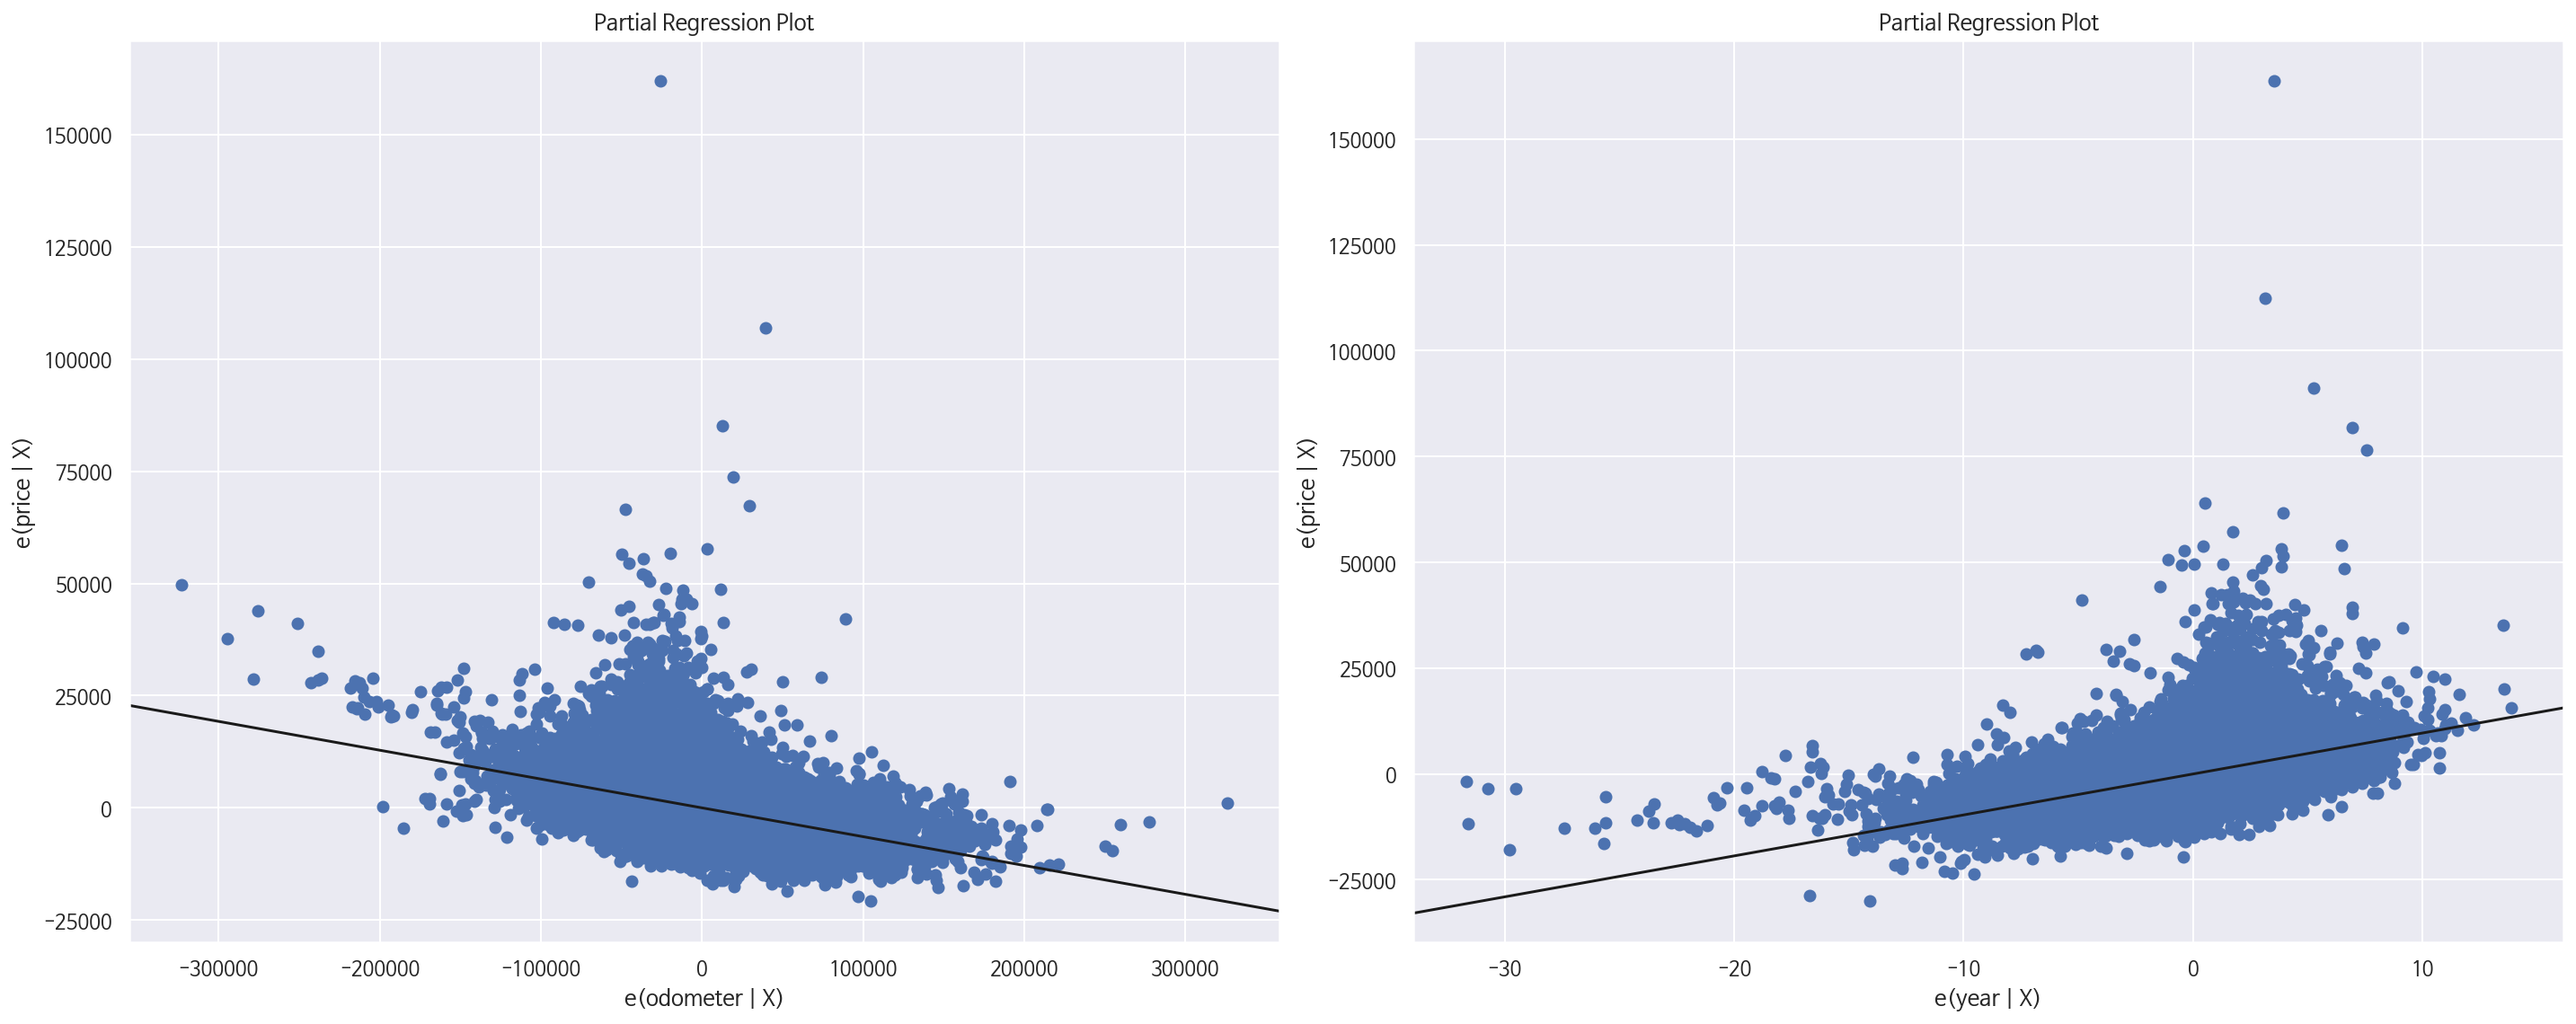

In [57]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


others = list(set(df.columns).difference(set(["price", "odometer"])))
p, resids = sm.graphics.plot_partregress(
    "price", "odometer", others, data=df, obs_labels=False, ret_coords=True, ax = ax1
)


others2 = list(set(df.columns).difference(set(["price", "year"])))
p, resids = sm.graphics.plot_partregress(
    "price", "year", others2, data=df, obs_labels=False, ret_coords=True, ax = ax2
)
plt.tight_layout()
plt.show()

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 3. 모델링

## 3-1. Train, Test 데이터 분할
- Train, Test 데이터 분할 및 k-fold 데이터 분할을 위한 카테고리 독립변수 정리
- 독립변수 정리
    1. 2개 초과 10개 미만의 빈도를 가진 데이터를 삭제한 후 데이터를 분할한다.
    2. 검증을 위해 데이터를 분할할때 마다, 2개 초과 10개 미만의 빈도를 가진 데이터를 균등하게 분배한다.

### 카테고리 데이터 빈도수에 따른 필터링

In [58]:
def value_counts_filter(num, columns):
    for column in columns:
        result = df[column].value_counts()[df[column].value_counts().sort_values() < num]
        if len(result) !=0:
            print(result.values.sum())
            print(result,end="\n\n===========\n\n")
            

In [59]:
value_counts_filter(10,df.columns.difference(['price','odometer','year']))

2
12 cylinders    2
Name: cylinders, dtype: int64


26
tesla              9
alfa-romeo         7
harley-davidson    4
porche             2
land rover         2
ferrari            1
aston-martin       1
Name: manufacturer, dtype: int64


7
missing       4
parts only    3
Name: title_status, dtype: int64


4
bus    4
Name: type, dtype: int64




- 2개 초과 10개 미만 데이터 인덱스 확인

In [60]:
def check_under_10_index(start_num,end_num,columns,df):
    test = {}
    test2 = []
    for column in columns:
        len_under_10 = len(df[column].value_counts()[(df[column].value_counts() < end_num) & (df[column].value_counts() > start_num)])
        if len_under_10:
            for i in range(len_under_10):
                index = df[df[column] == df[column].value_counts()[(df[column].value_counts() < end_num) & (df[column].value_counts() > start_num)].index[i]].index.values
                value = df[column].value_counts()[(df[column].value_counts() < end_num) & (df[column].value_counts() > start_num)].index[i]  
                test[value] = index
    test2.append(test)
    return test2

In [61]:
index_df = pd.DataFrame(check_under_10_index(2,10, ['cylinders','manufacturer','title_status','type'],df))
index_df

,tesla,alfa-romeo,harley-davidson,missing,parts only,bus
0,"[1037, 1897, 12701, 12713, 13567, 13568, 15060...","[1931, 11481, 13715, 18035, 29591, 49763, 51630]","[7006, 34363, 52348, 52376]","[10963, 16194, 20106, 33971]","[9401, 9961, 29878]","[1336, 10320, 16975, 27573]"


-  데이터 분할에 사용할 인덱스 분류

In [274]:
for_test_data = []
for_train_data_train = []
for_train_data_test = []
for column in index_df.columns:
    start = list(index_df[column][0])
    random.shuffle(start)
    if len(start) > 4:
        m = [start[i:i + 3] for i in range(0, len(start), 3)]
        for_test_data.append(m[0])
        for_train_data_train.append(m[1])
        for_train_data_test.append(m[2])
    elif len(start) == 4:
        m = [start[:2], start[2:3], start[3:]]
        for_test_data.append(m[0])
        for_train_data_train.append(m[1])
        for_train_data_test.append(m[2])
    else :
        m = [[i] for i in start]
        for_test_data.append(m[0])
        for_train_data_train.append(m[1])
        for_train_data_test.append(m[2])

-  10개 미만 데이터 우선 삭제 

In [275]:
def delete_under_ten(df):
    for column in df.columns.difference(['id','price','odometer','year']):
        values = [value for value in df[column].value_counts()[df[column].value_counts() < 10].keys()]
        if values:
            for value in values:
                df = df[df[column] != value]
    return df

In [276]:
df_deleted_under_ten = delete_under_ten(df)

### 2개 초과 10개 미만 데이터 균등 분배

In [277]:
train_data, test_data = train_test_split(df_deleted_under_ten, test_size = .20, random_state = 7)
train_data = pd.concat([train_data, df.iloc[
    [element for array in for_train_data_train for element in array] + [element for array in for_train_data_test for element in array]
]],axis=0)
test_data = pd.concat([test_data,df.iloc[
    [element for array in for_test_data for element in array]]])
train_data.shape, test_data.shape

((44740, 13), (11194, 13))

### 데이터 확인

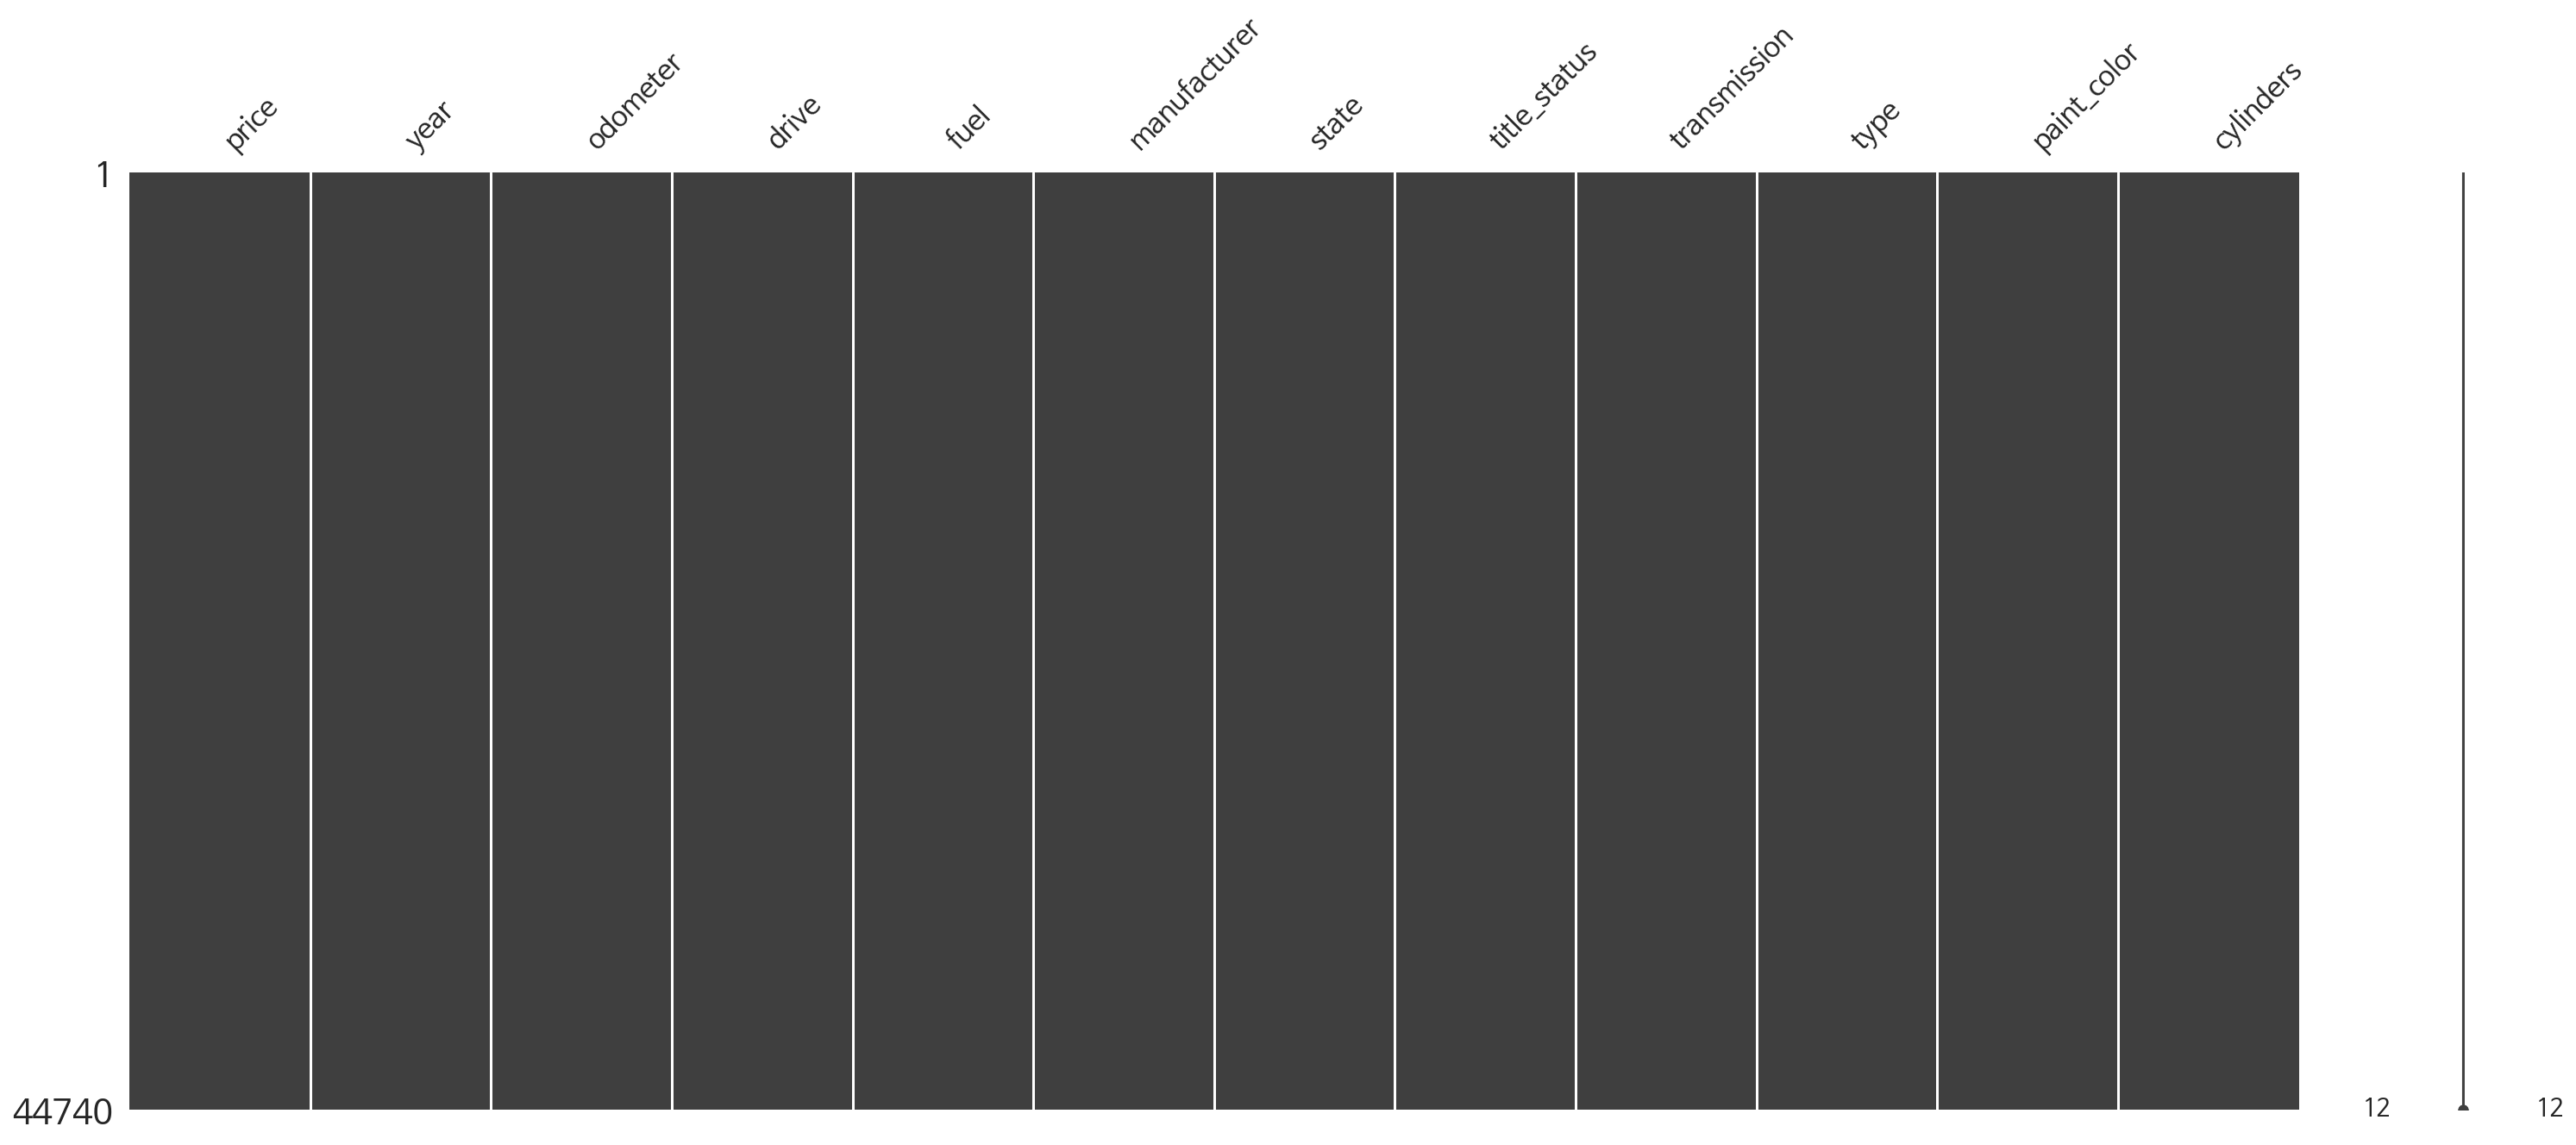

In [66]:
msno.matrix(train_data)
plt.show()


## 컬럼 정보

|컬럼명|내용|설명|
|:------|:---|:---|
|<span style= 'background:yellow'> **price** </span> | **entry price** |  **중고차 가격**|
|<span style= 'background:pink'>**year**</span> | **entry year** | **중고차 연식**|
|<span style= 'background:#ADD8E6'>**manufacturer**</span> |  **manufacturer of vehicle**| **제조사**|
|<span style= 'background:#ADD8E6'>**cylinders**</span> |  **number of cylinder** | **엔진 기통수** |
|<span style= 'background:#ADD8E6'>**fuel**</span> |  **fuel type** | **연료타입** |
|<span style= 'background:pink'>**odometer**</span> |  **miles traveled by vehicle**| **총주행거리**|
|<span style= 'background:#ADD8E6'>**title_status**</span> |  **title status of vehicle** |**차량 상태**|
|<span style= 'background:#ADD8E6'>**transmission**</span> |  **transmission of vehicle**| **미션**|
|<span style= 'background:#ADD8E6'>**drive**</span> |  **type of drive** |**구동방식**|
|<span style= 'background:#ADD8E6'>**size**</span> |  **size of vehicle** | **차량크기**|
|<span style= 'background:#ADD8E6'>**type**</span> |  **generic type of vehicle**| **차량 타입**|
|<span style= 'background:#ADD8E6'>**paint_color**</span> |  **color of vehicle**| **차량 색상**|
|<span style= 'background:#ADD8E6'>**state**</span> |  **state of listing**| **주 명**|

## 3-2. LinearRegression
- train, test 데이터 분류
- test size : 0.2
- 종속변수인 가격에 log를 씌움

Test R2 score :  0.8571744399717923
RMSE of Train Data :  0.2579442093968977
RMSE of Test Data :  0.256894125239245
K-fold :  [0.84952756 0.86064617 0.8528878  0.85969426 0.86023919 0.85347056
 0.85883896 0.85467196 0.85485435 0.85464908]


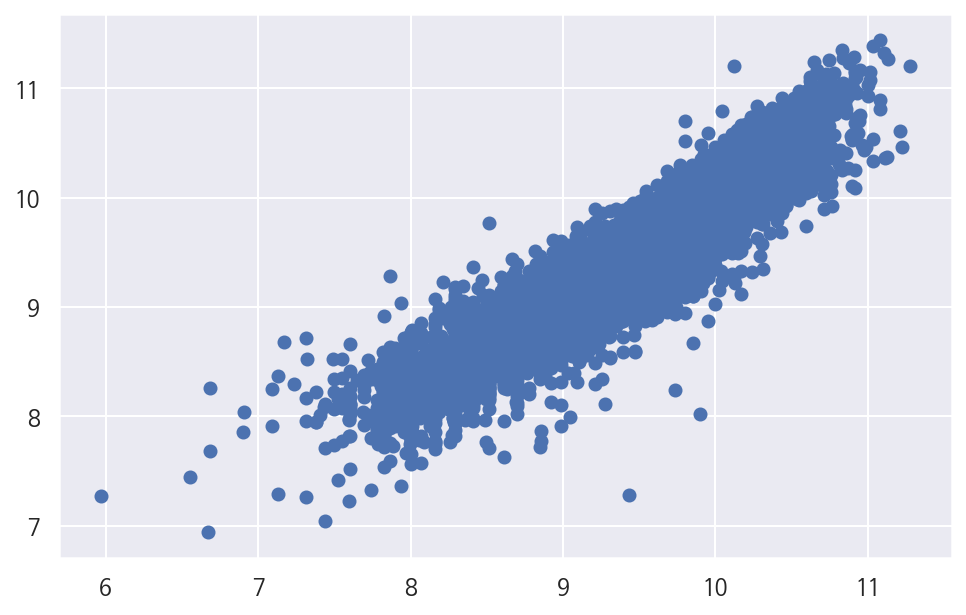

In [67]:
X = train_data[train_data.columns.difference(['id_x','model','vin','price'])]
Y = np.log(train_data['price'])
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 0)

test_df = pd.concat([Y_train,X_train],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
r2 = r2_score(Y_test,predicted)
print('Test R2 score : ',r2)
plt.scatter(Y_test,predicted)


pred_tr = result.predict(X_train)
pred_test = result.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(Y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(Y_test, pred_test)))


# cv = KFold(10, shuffle=True, random_state=0)
model_0_cross_val_score = cross_val_score(model, X, Y, scoring=None, cv=10)

print('RMSE of Train Data : ', rmse_tr)
print('RMSE of Test Data : ', rmse_test)
print('K-fold : ', model_0_cross_val_score)

# 3-3. Regression Model Developing

## Model 1

- 종속변수에 log를 씌움
- 실수형 독립변수, year와 odometer를 스케일링 함

In [67]:
# 모듈활용
# 아웃라이어가 제거된 데이터 전체를 입력

In [69]:
from used_car_regression import UsedCarRegression
usedcar = UsedCarRegression(df)

In [79]:
df.shape

(55942, 12)

In [252]:
model1_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color) + 0"

In [253]:
def summary_minimize_df(result, model_num):
    df = pd.DataFrame([{
        "R-squared" : result.rsquared,
        "Adj. R-squared" : result.rsquared_adj,
        "F-statistic" : result.fvalue,
        "Prob (F-statistic)" : result.f_pvalue,
        "Log-Likelihood" : result.llf,
        "AIC": result.aic,
        "BIC" : result.bic
    }]).T
    df.columns = [model_num]
    return df

In [254]:
result, train_data, test_data, train_ls, test_ls = usedcar.model_fit(model1_formula)
pred = result.predict(test_data)

In [255]:
model1_min_df = summary_minimize_df(result, "Model 1")
model1_min_df

,Model 1
R-squared,0.8564659
Adj. R-squared,0.8560507
F-statistic,2063.0965475
Prob (F-statistic),0.0000000
Log-Likelihood,-2847.3003931
AIC,5954.6007861
BIC,7086.6985592


### R2 score 확인

In [256]:
r2_score(np.log(test_data['price']),pred)

0.8548034762687584

### 교차 검증

In [257]:
cross_validation_model1 = usedcar.cross_validation(model1_formula)
cross_validation_model1

[0.8559985438084914,
 0.8501692404160656,
 0.8500852466053803,
 0.8584978848081888,
 0.847248240850393,
 0.8492734220780906,
 0.8446251124460701,
 0.8549137143232604,
 0.8483998130051489,
 0.8529609171122926]

## ANOVA를 이용한 독립변수 점검

In [258]:
anova = sm.stats.anova_lm(result, typ=2)
anova.sort_values(by=['F'],ascending=False)

,sum_sq,df,F,PR(>F)
scale(year),2242.6534283,1.0000000,33626.7376546,0.0000000
scale(odometer),1362.3838528,1.0000000,20427.8217163,0.0000000
C(manufacturer),8268.7456685,36.0000000,3443.9727342,0.0000000
C(fuel),548.1772155,4.0000000,2054.8662559,0.0000000
C(drive),209.1507643,2.0000000,1568.0215659,0.0000000
C(cylinders),560.7117049,6.0000000,1401.2348916,0.0000000
C(type),226.7572687,12.0000000,283.3365114,0.0000000
C(transmission),24.7195187,2.0000000,185.3243932,0.0000000
C(title_status),27.5994016,5.0000000,82.7660508,0.0000000
C(state),108.9289708,50.0000000,32.6660007,0.0000000


## model2 
- **'실수형' X '범주형' interaction 추가**

- **연식(year)**
    - year : manufacturer -> **연도별 인기있는 자동차 제조사가 다르기 때문에**, 연식이 가격예측에 미치는 영향이 **제조사**에 따라 달라진다.
    - year : type -> **금융위기를 기점으로 utility차량 (소형 SUV)등의 점유율이 상승 하는 등**, 연식이 가격예측에 미치는 영향이 **차량 종류**에 따라 달라진다.
<img src="./img/img9.png" width="500">
출처 : Kotra http://news.kotra.or.kr/user/globalBbs/kotranews/3/globalBbsDataView.do?setIdx=242&dataIdx=180910

- **주행거리(odometer)**
    - odoemter : fuel -> **장거리 혹은 단거리 운행에 적합한 연료 종류가 다르기 때문에**, 주행거리가 가격 예측에 미치는 영향이 **연료 종류**에 따라 달라진다.
    - odometer : cylinders -> **장거리 운행에 적합한 특정 실린더 종류가 있기 때문에**, 주행거리가 가격 예측에 미치는 영향이 **실린더 종류**에 따라 달라진다.
    - odometer : type -> **장거리 운행을 하는 특정 차종이 있기 때문에**, 주행거리가 가격 예측에 미치는 영향이 **차량 종류**에 따라 달라진다.

## Model2 formula 성립 과정
- 경우의수 만큼 formula를 만들고 k-fold 검증을 진행
- 앞서 가정했던 사항들과 모델 성능을 비교

In [261]:
train_data.shape

(44732, 13)

In [267]:
Numbers = ['scale(odometer)', 'scale(year)']
X = ['fuel','title_status','transmission','drive','type','paint_color',"cylinders", "manufacturer"]
combination_score = []
combination_name = []
for number in Numbers:
    feature = number
       
    for i in X:
        interaction = feature + ":" + i
        
        kf = KFold(5, shuffle=True, random_state=0)
        mode2_cross_val_score = []
        for X_train_index, X_test_index in kf.split(train_data):
    
            X_train= train_data.iloc[X_train_index]
            X_test = train_data.iloc[X_test_index]

            X_train = pd.concat([X_train, train_data[train_data.index.isin([element for array in for_train_data_train for element in array])]], axis=0)
            X_test = pd.concat([X_test, train_data[train_data.index.isin([element for array in for_train_data_test for element in array])]], axis=0)
            model1 = sm.OLS.from_formula("np.log(price) ~ scale(odometer) + scale(year) +{}+{}".format("+".join(X_train.columns.difference(["price",'odometer','year'])), interaction),X_train)
            result = model1.fit()
            pred = result.predict(X_test)
            R2 = r2_score(np.log(X_test.price),pred)
            n = train_data.shape[0]
            p = len(pd.get_dummies(train_data).columns)
            Adjr2 = 1-(1-R2)*(n-1)/(n-p-1)
            mode2_cross_val_score.append(Adjr2)
        combination_score.append(mode2_cross_val_score)
        combination_name.append(interaction)

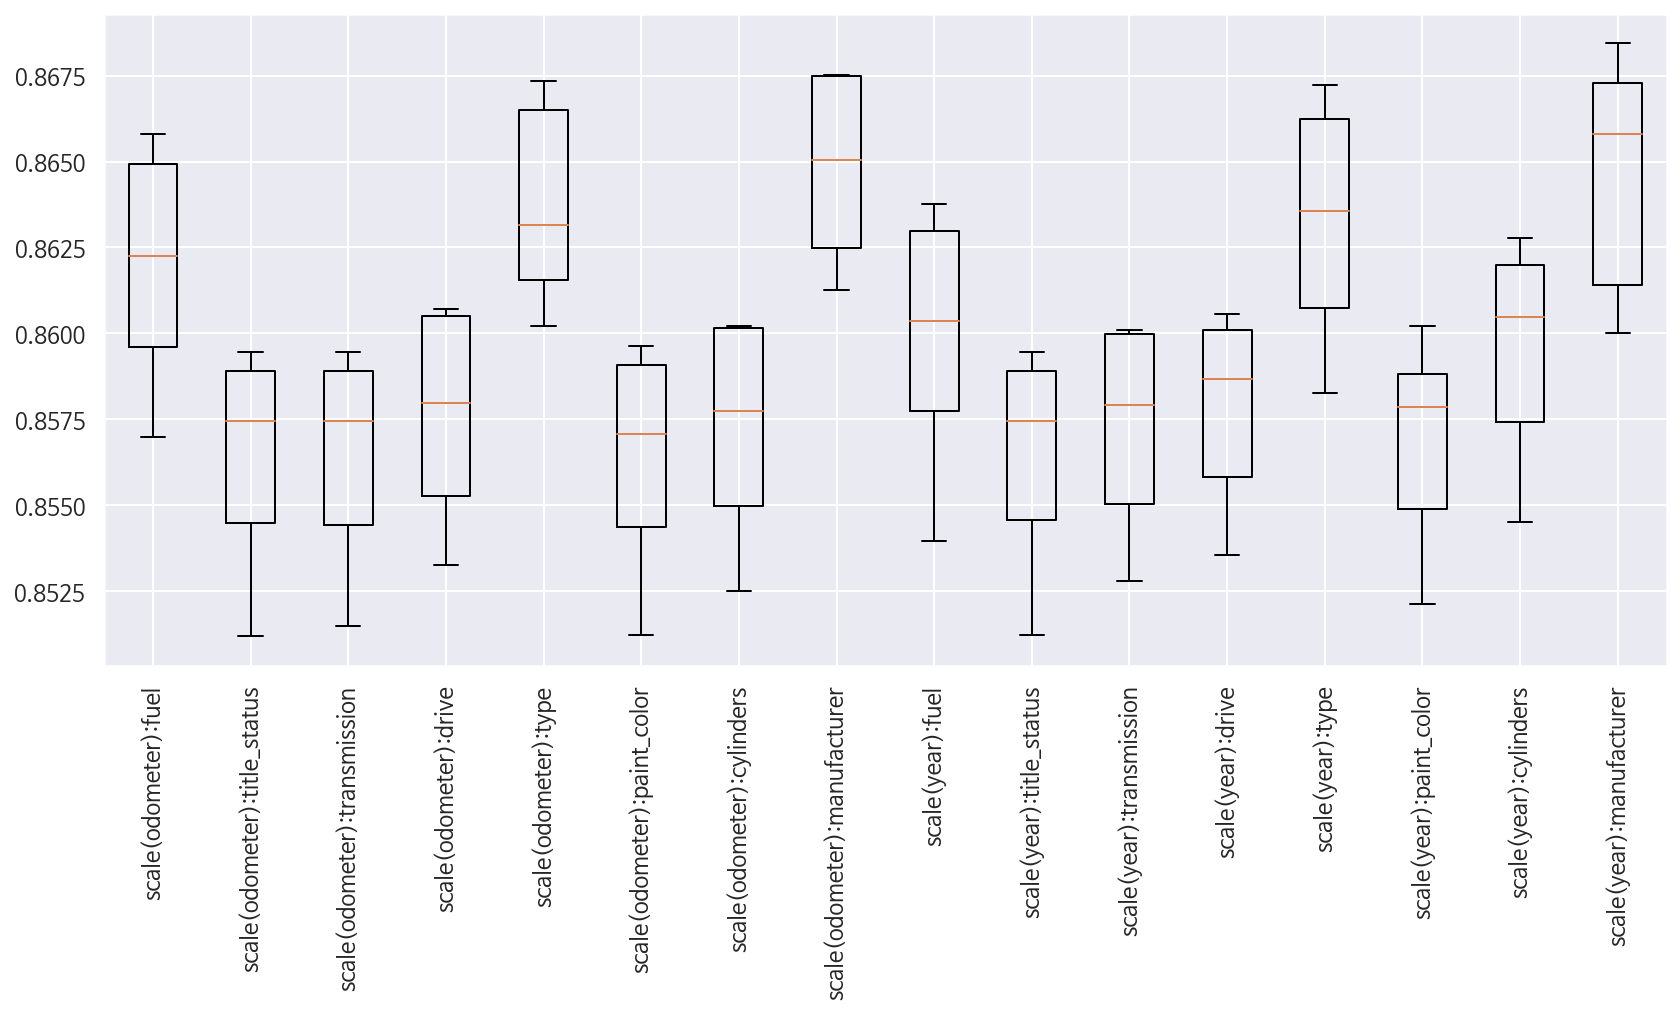

In [268]:
fig1, ax1 = plt.subplots(figsize=(14, 6))
ax1.boxplot(combination_score)
ax1.set_xticklabels(combination_name, rotation=90)
plt.show()

In [269]:
model2_formula = "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)\
+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel)"

In [270]:
model2_min_df = summary_minimize_df(result, 'Model 2')
pd.concat([model1_min_df,model2_min_df],axis=1)

,Model 1,Model 2
R-squared,0.8564659,0.8655252
Adj. R-squared,0.8560507,0.8649064
F-statistic,2063.0965475,1398.6086807
Prob (F-statistic),0.0000000,0.0000000
Log-Likelihood,-2847.3003931,-1050.6899778
AIC,5954.6007861,2431.3799556
BIC,7086.6985592,3831.5301967


### R2 score 확인

In [271]:
result, train_data, test_data, train_ls, test_ls  = usedcar.model_fit(model2_formula)
pred = result.predict(test_data)
r2_score(np.log(test_data['price']),pred)

0.8784331001387767

### 교차 검증

In [272]:
cross_validation_model2 = usedcar.cross_validation(model2_formula)
cross_validation_model2

[0.8772400918873097,
 0.8742140811046845,
 0.8714373960469259,
 0.8788766658465108,
 0.8668132499204652,
 0.8721171612744401,
 0.8670438973862343,
 0.8790393260048996,
 0.8745723770639531,
 0.8722836968856279]

## model3
- **'범주형' X '범주형' interaction 추가**
- manufactuer : cylinders -> 제조사의 특정 몇기통의차가 가격의 영향을 줄것으로 판단
- type : drive -> 차종의 구동방식이 영향을 줄것으로 판단

## model3 formula 성립 과정
- 경우의수 만큼 formula를 만들고 k-fold 검증을 진행
- 앞서 가정했던 사항들과 모델 성능을 비교

In [279]:
X = ['fuel','title_status','transmission','drive','type','paint_color',"cylinders", "manufacturer"]
combination_score = []
combination_name = []
for count in range(len(X)):
    feature = X[-1]
    X.pop()
   
    for i in X:
        interaction = feature+":"+i
        
        kf = KFold(5, shuffle=True, random_state=0)
        model_cross_val_score = []
        for X_train_index, X_test_index in kf.split(train_data):
    
            X_train= train_data.iloc[X_train_index]
            X_test = train_data.iloc[X_test_index]

            X_train = pd.concat([X_train, train_data[train_data.index.isin([element for array in for_train_data_train for element in array])]], axis=0)
            X_test = pd.concat([X_test, train_data[train_data.index.isin([element for array in for_train_data_test for element in array])]], axis=0)
            model1 = sm.OLS.from_formula("np.log(price) ~ scale(odometer) + scale(year) +{}+{}".format("+".join(X_train.columns.difference(["price",'odometer','year',feature, i ])), interaction),X_train)
            result = model1.fit()
            pred = result.predict(X_test)
            R2 = r2_score(np.log(X_test.price),pred)
            n = train_data.shape[0]
            p = len(pd.get_dummies(train_data).columns)
            Adjr2 = 1-(1-R2)*(n-1)/(n-p-1)
            model_cross_val_score.append(Adjr2)
        combination_score.append(model_cross_val_score)
        combination_name.append(interaction)

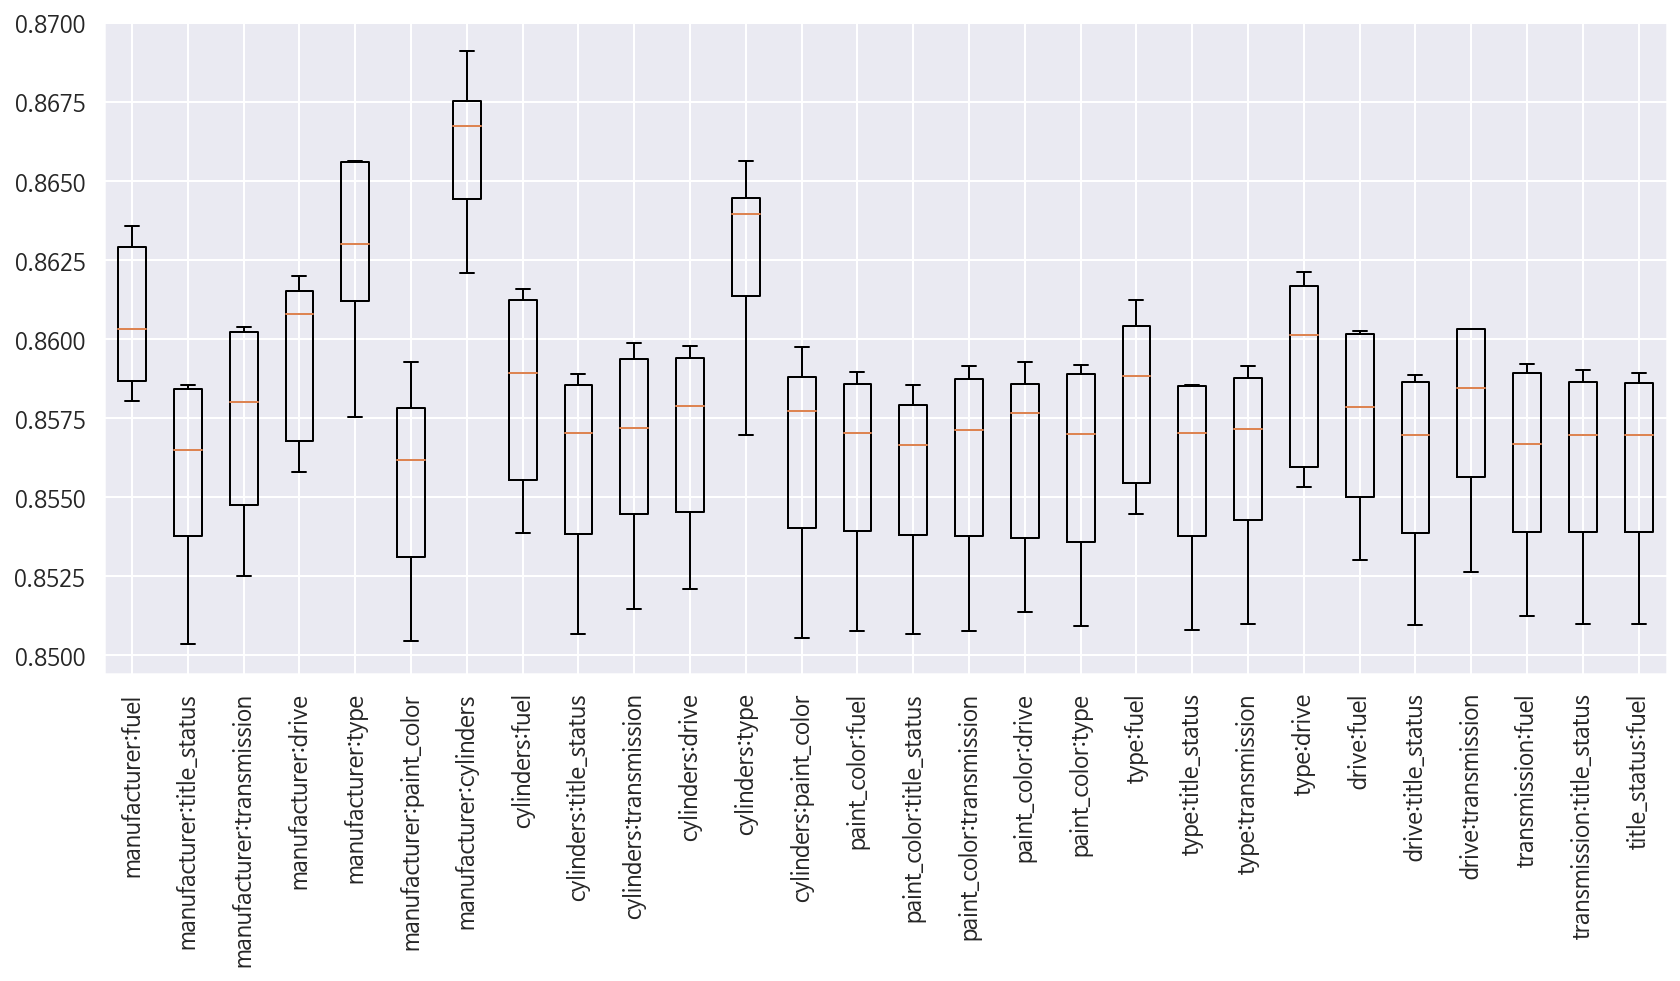

In [280]:
fig1, ax1 = plt.subplots(figsize=(14, 6))
ax1.boxplot(combination_score)
ax1.set_xticklabels(combination_name, rotation=90)
plt.show()

In [281]:
model3_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive) "

In [282]:
model3_min_df = summary_minimize_df(result, 'Model 3')
pd.concat([model1_min_df,model2_min_df,model3_min_df],axis=1)

,Model 1,Model 2,Model 3
R-squared,0.8564659,0.8655252,0.8566628
Adj. R-squared,0.8560507,0.8649064,0.8561001
F-statistic,2063.0965475,1398.6086807,1522.3565507
Prob (F-statistic),0.0000000,0.0000000,0.0000000
Log-Likelihood,-2847.3003931,-1050.6899778,-2192.5734426
AIC,5954.6007861,2431.3799556,4667.1468853
BIC,7086.6985592,3831.5301967,5863.6389095


### R2 score 확인

In [283]:
result, train_data, test_data, train_ls, test_ls = usedcar.model_fit(model3_formula)
pred = result.predict(test_data)
r2_score(np.log(test_data['price']),pred)

0.8879229428458502

### 교차 검증

In [284]:
cross_validation_model3 = usedcar.cross_validation(model3_formula)
cross_validation_model3

[0.8868872307423091,
 0.8838527702283626,
 0.8805098416792205,
 0.8879343360533875,
 0.8758916982787082,
 0.8814885467550261,
 0.8777253777449484,
 0.8880905157933058,
 0.8852608143347239,
 0.883100736942506]

# model4 
- year와 odometer **다항식추가**

### Partial Regression Plot
- 두 그래프 모두 약간 곡선의 모양을 가지고 있음

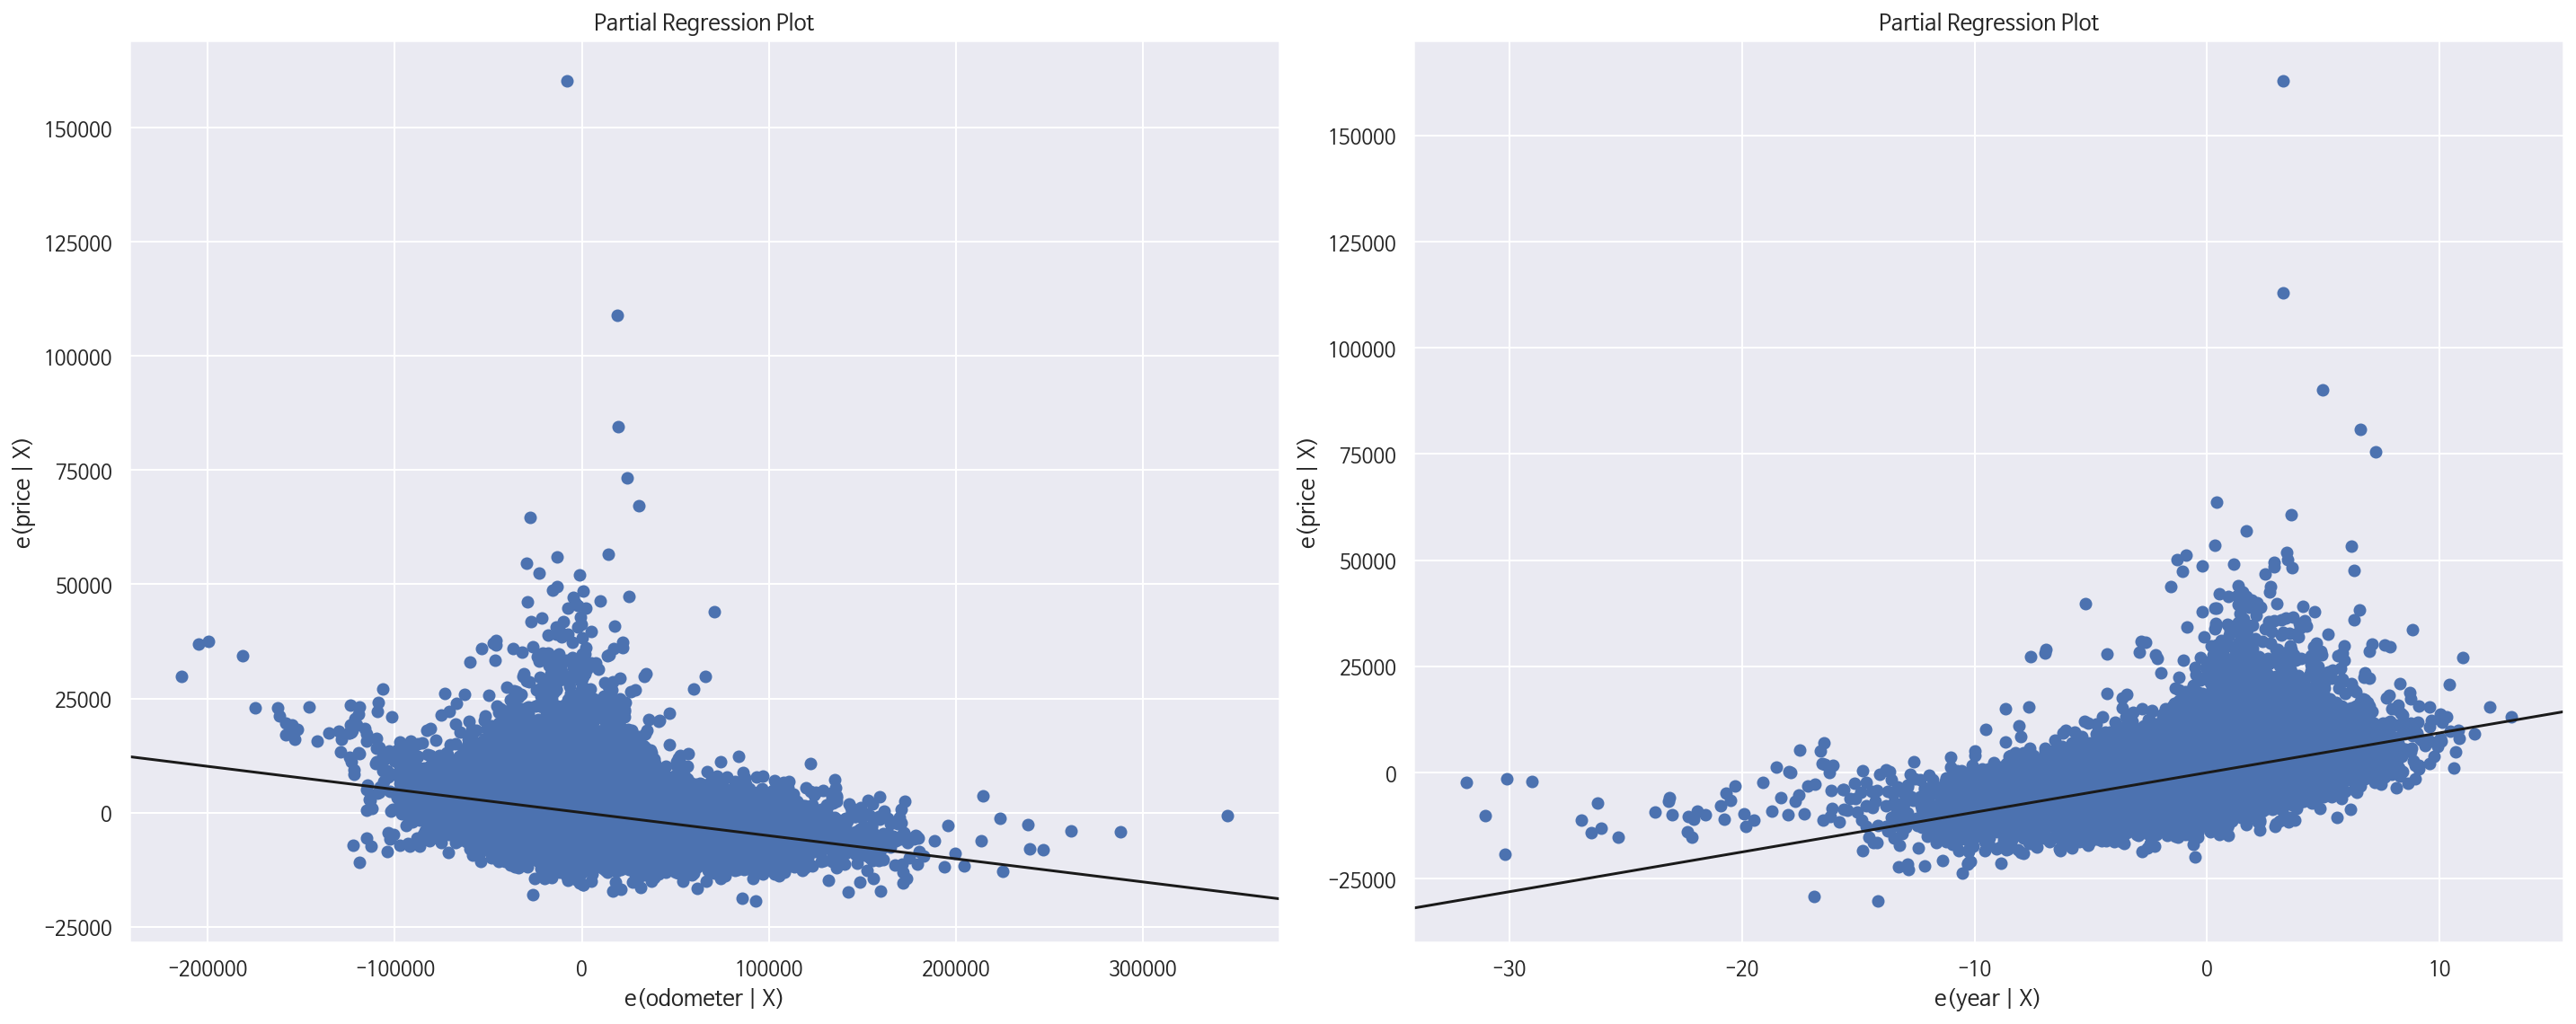

In [285]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


others = list(set(df.columns).difference(set(["price", "odometer"])))
p, resids = sm.graphics.plot_partregress(
    "price", "odometer", others, data=df, obs_labels=False, ret_coords=True, ax = ax1
)


others2 = list(set(df.columns).difference(set(["price", "year"])))
p, resids = sm.graphics.plot_partregress(
    "price", "year", others2, data=df, obs_labels=False, ret_coords=True, ax = ax2
)
plt.tight_layout()
plt.show()

## model4 formula 성립 과정
- year와 odometer에 각각 1차항 부터 4차항 까지 formula를 만들고, k-fold 검증을 진행
- 가장 높은 성능을 보이는 formula를 채택

### year에 제곱항을 더했을때

In [286]:
score = []

formula = "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive) "

for i in range(1, 5):
    if i == 1:
        score.append(usedcar.cross_validation(formula))
    else:
        formula += "+scale(I(year**{}))".format(i)
        score.append(usedcar.cross_validation(formula))

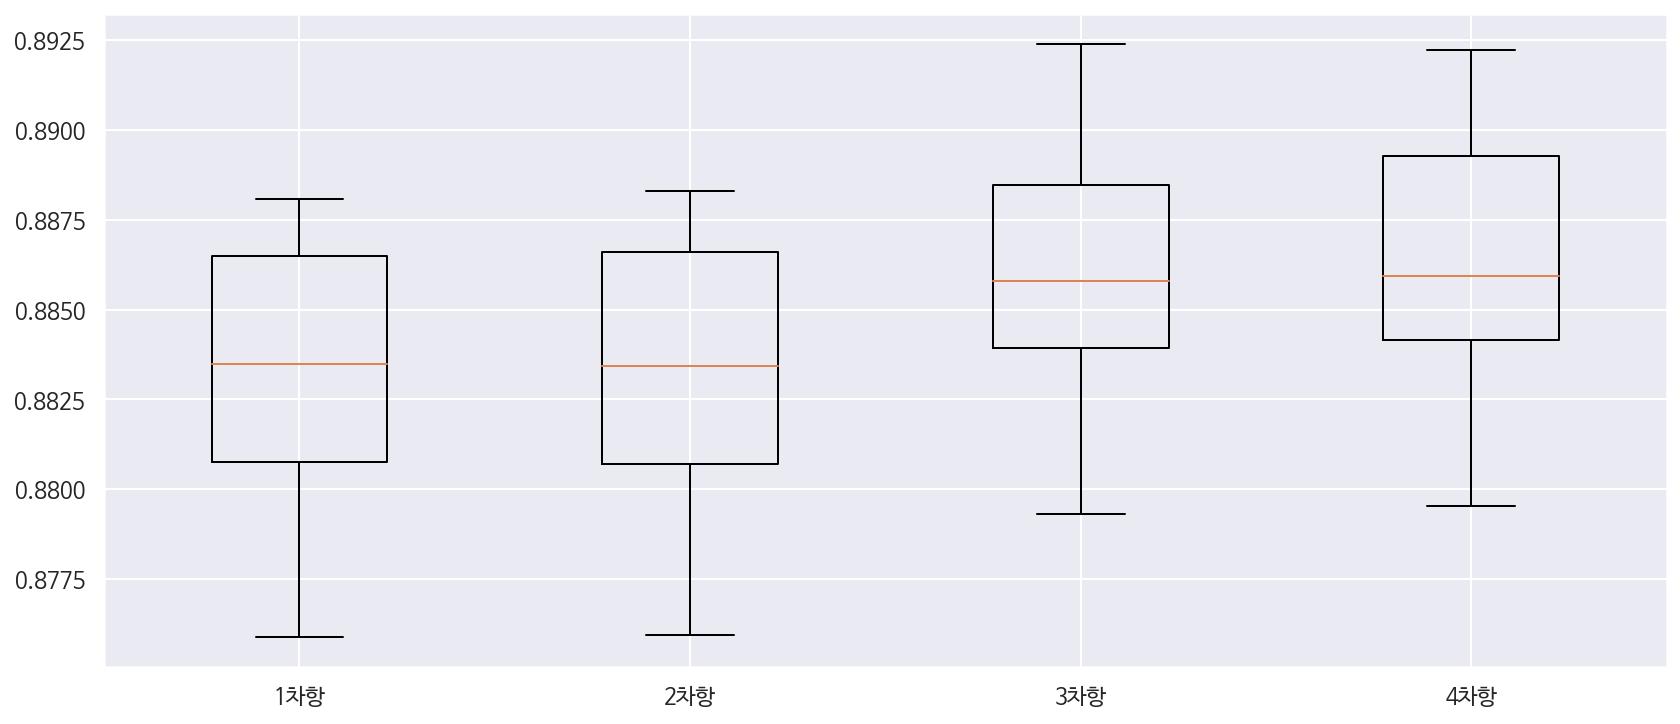

In [287]:
name = ['1차항', '2차항', '3차항', '4차항']
fig1, ax1 = plt.subplots(figsize=(14, 6))
ax1.boxplot(score[:4])
ax1.set_xticklabels(name)
plt.show()

### odometer에 제곱항을 더했을때

In [288]:
score = []


formula = "np.log(price) ~ scale(odometer)+scale(year)+C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)"

for i in range(1,5):
    if i == 1:
        score.append(usedcar.cross_validation(formula))
    else:
        formula += "+scale(I(odometer**{}))".format(i)
        score.append(usedcar.cross_validation(formula))

In [289]:
name = ['1차항', '2차항', '3차항', '4차항']

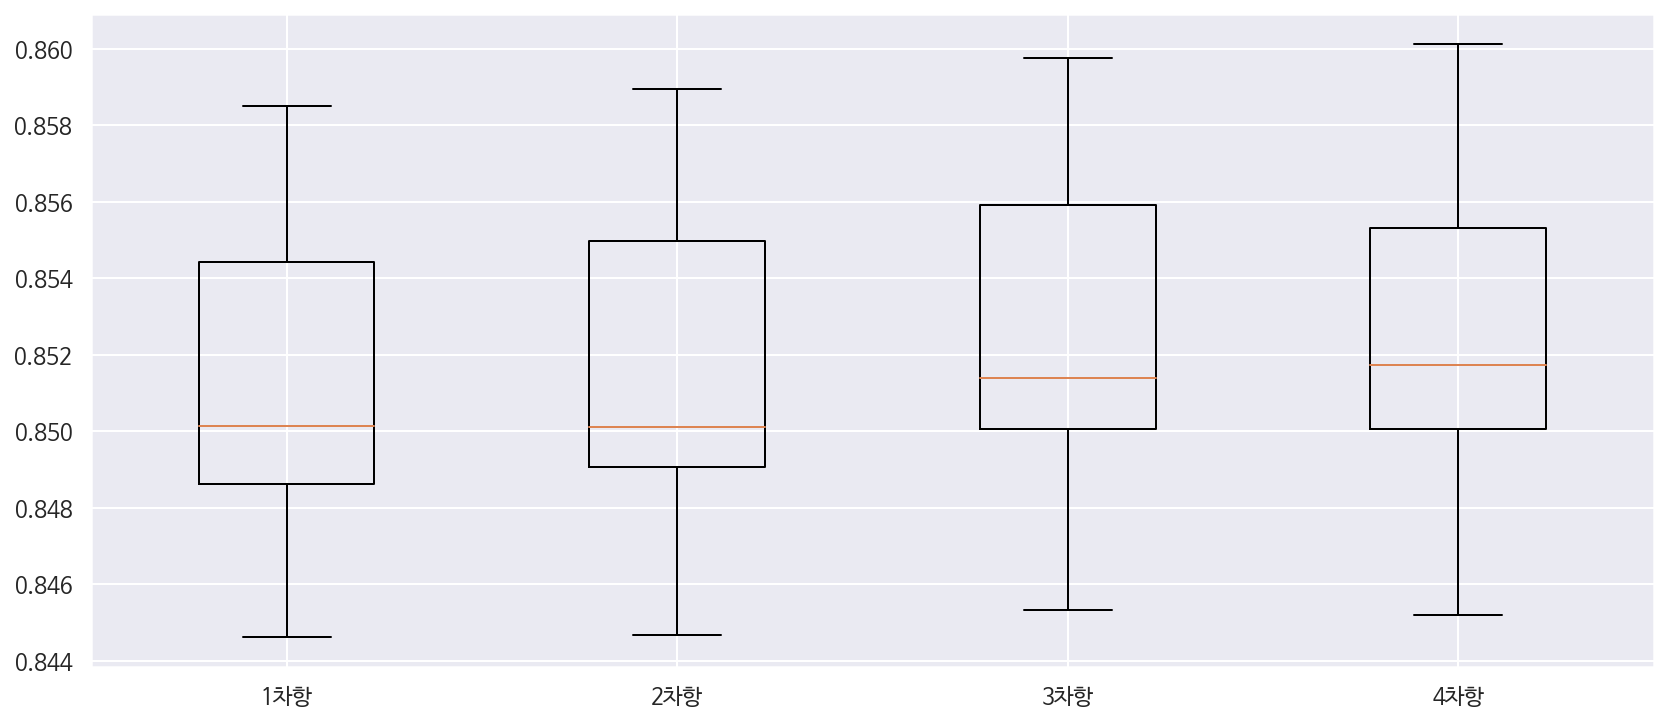

In [290]:
fig1, ax1 = plt.subplots(figsize=(14, 6))
ax1.boxplot(score)
ax1.set_xticklabels(name)
plt.show()

### year와 odometer에 3차항 까지 추가
- year와 odoemter에 동시에 3차항을 추가 했을때와, 각각 3차항을 추가했을때의 모델성능을 상호 비교하여 최상의 모델 성능을 보이는 formula 선정

In [291]:
model4_1_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive) + scale(I(year**2)) + scale(I(year**3)) + scale(I(odometer**2)) + scale(I(odometer**3)) "

In [292]:
model4_2_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive) + scale(I(year**2)) + scale(I(year**3)) " 

In [293]:
model4_3_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive) + scale(I(odometer**2)) + scale(I(odometer**3)) "

### 교차검증 결과 비교

In [294]:
cross_validation_model4_1 = usedcar.cross_validation(model4_1_formula)
cross_validation_model4_2 = usedcar.cross_validation(model4_2_formula)
cross_validation_model4_3 = usedcar.cross_validation(model4_3_formula)

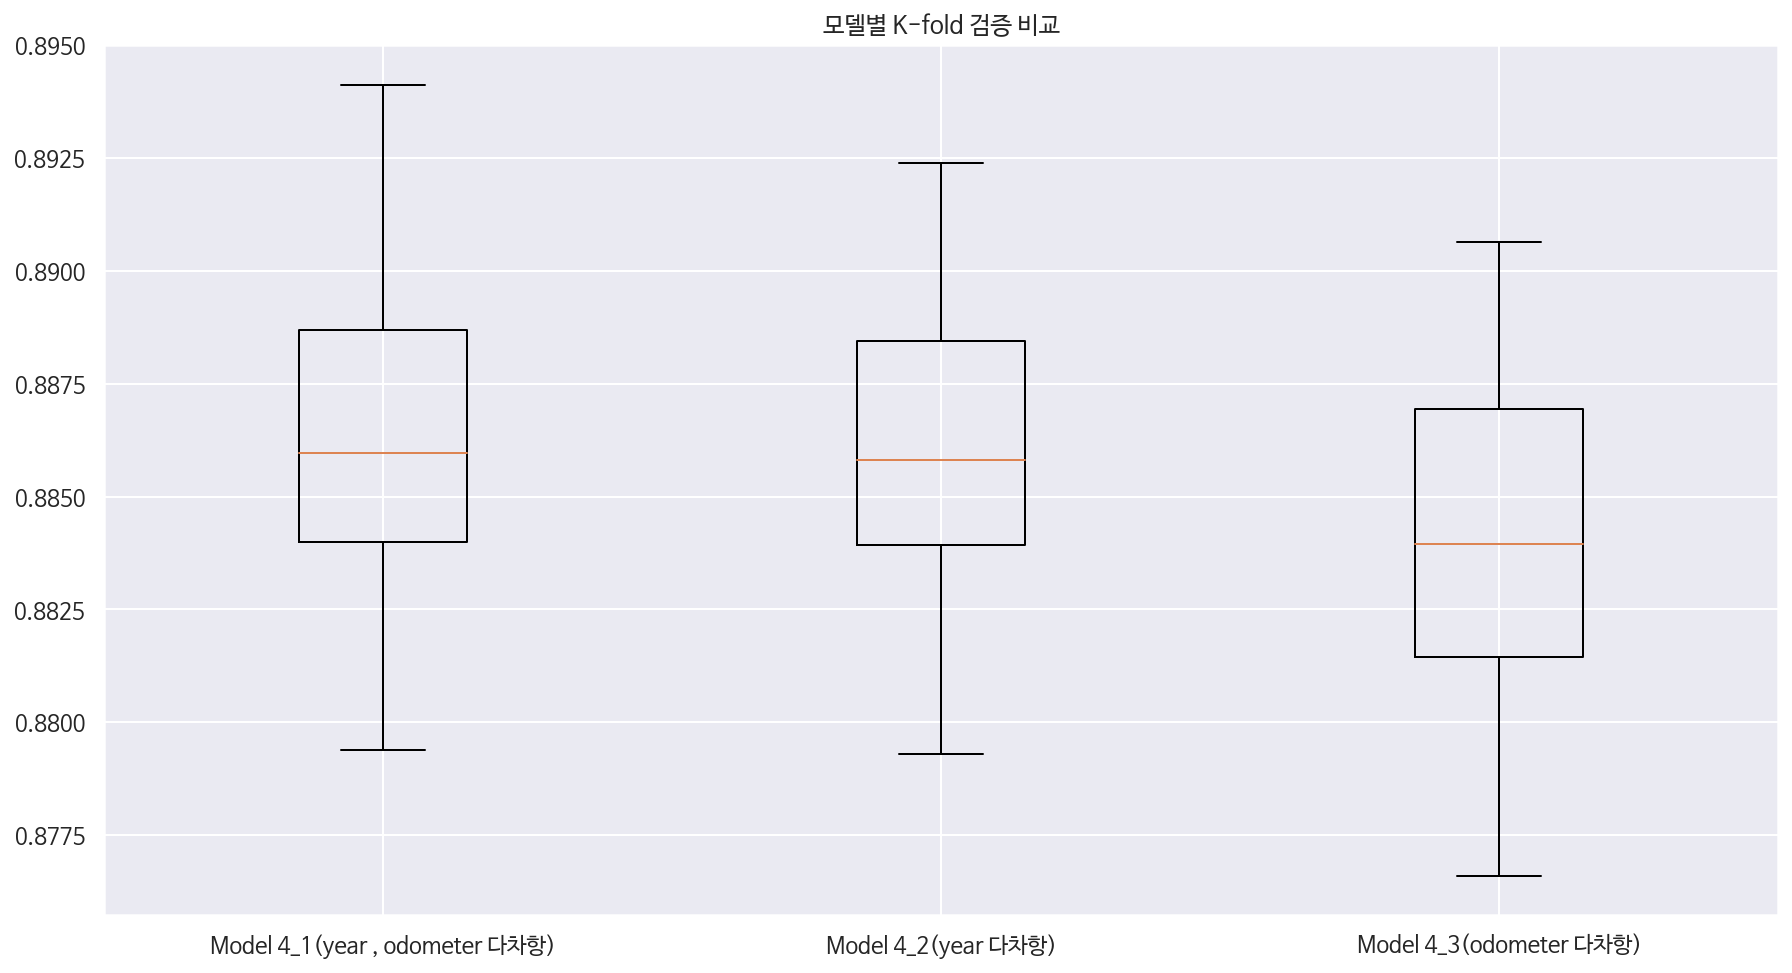

In [295]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.boxplot(
    [
        cross_validation_model4_1, cross_validation_model4_2, cross_validation_model4_3
    ],
    sym="b*",
    labels=['Model 4_1(year , odometer 다차항)', 'Model 4_2(year 다차항)', 'Model 4_3(odometer 다차항)'],
)
plt.title('모델별 K-fold 검증 비교')
plt.show()

## Model 4 결론
- **year에 3차항 까지 추가한다**

In [296]:
model4_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive) + scale(I(year**2)) + scale(I(year**3)) " 

In [297]:
model4_min_df = summary_minimize_df(result, 'Model 4')
pd.concat([model1_min_df,model2_min_df,model3_min_df,model4_min_df],axis=1)

,Model 1,Model 2,Model 3,Model 4
R-squared,0.8564659,0.8655252,0.8566628,0.8890430
Adj. R-squared,0.8560507,0.8649064,0.8561001,0.8882259
F-statistic,2063.0965475,1398.6086807,1522.3565507,1088.0338288
Prob (F-statistic),0.0000000,0.0000000,0.0000000,0.0000000
Log-Likelihood,-2847.3003931,-1050.6899778,-2192.5734426,2910.3790512
AIC,5954.6007861,2431.3799556,4667.1468853,-5164.7581024
BIC,7086.6985592,3831.5301967,5863.6389095,-2308.3883365


### R2 score 확인

In [298]:
result, train_data, test_data, train_ls, test_ls = usedcar.model_fit(model4_formula)
pred = result.predict(test_data)
r2_score(np.log(test_data['price']),pred)

0.8891033265327332

In [299]:
df = df.drop('odometer_under_100000',axis=1)
df.shape

(55942, 12)

### 교차 검증

In [300]:
cross_validation_model4 = usedcar.cross_validation(model4_formula)

# 모델별 성능 비교

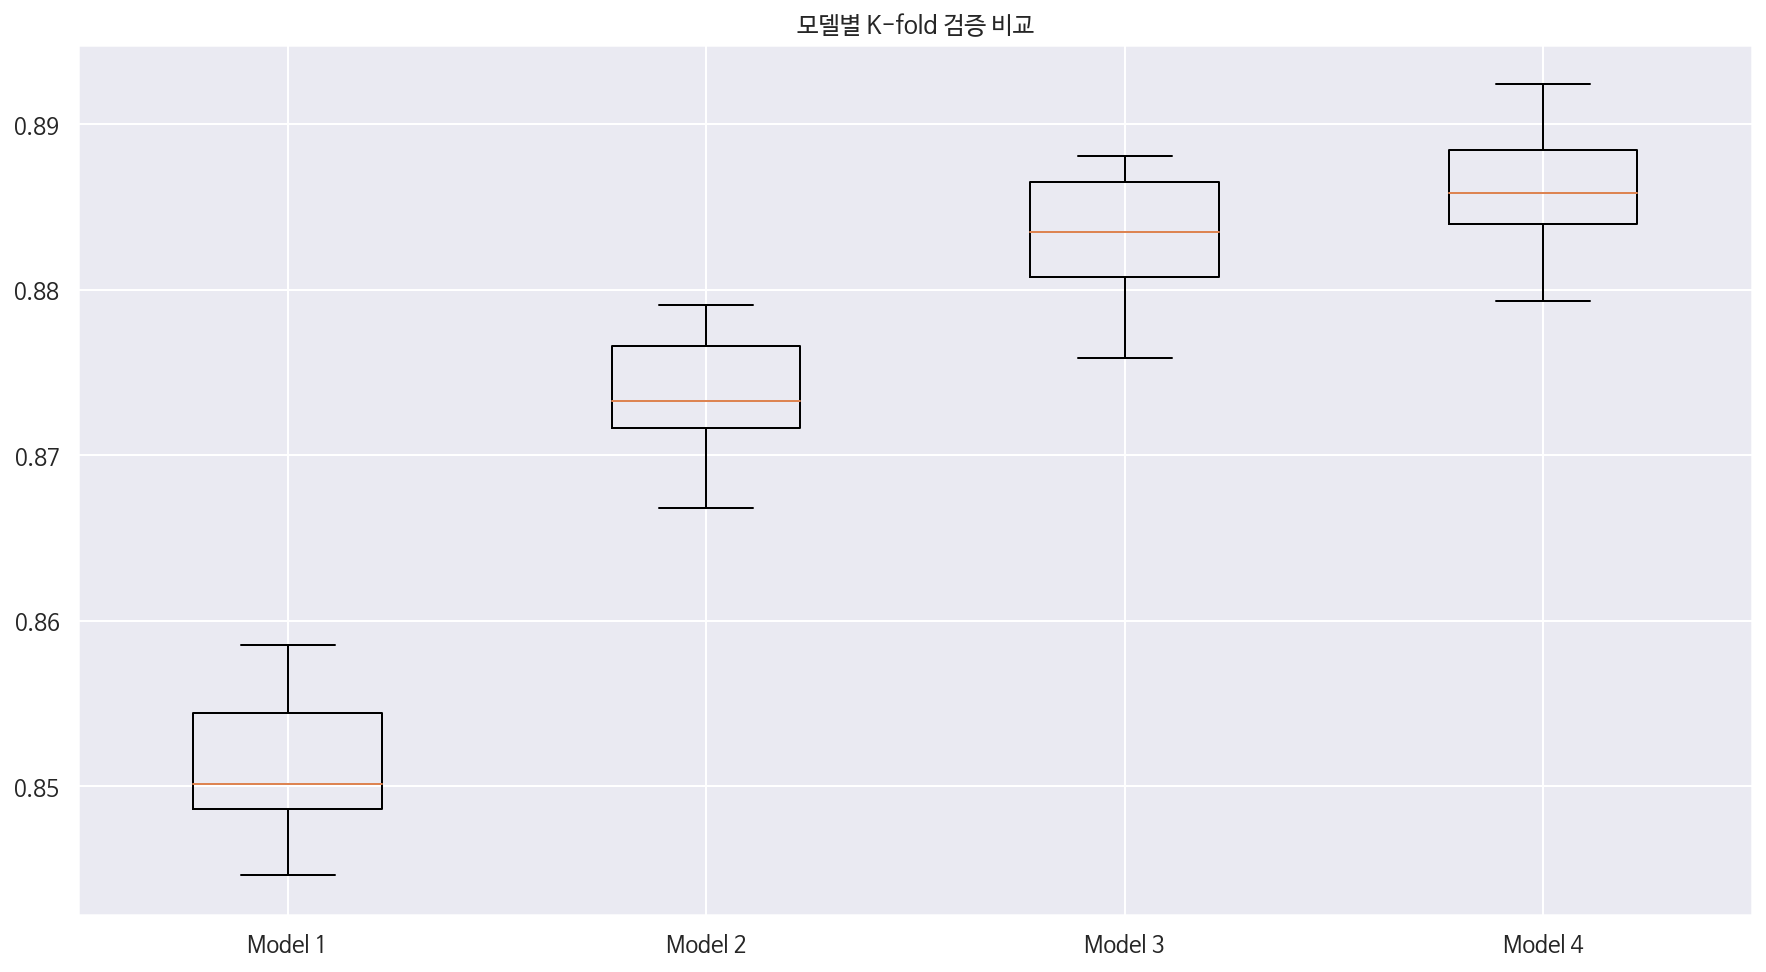

In [301]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.boxplot(
    [
        cross_validation_model1, cross_validation_model2,
        cross_validation_model3, cross_validation_model4,
    ],
    sym="b*",
    labels=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
)
plt.title('모델별 K-fold 검증 비교')
plt.show()

# model5
- 중고차 워런티 제도의 기준 : 주행거리 및 연식

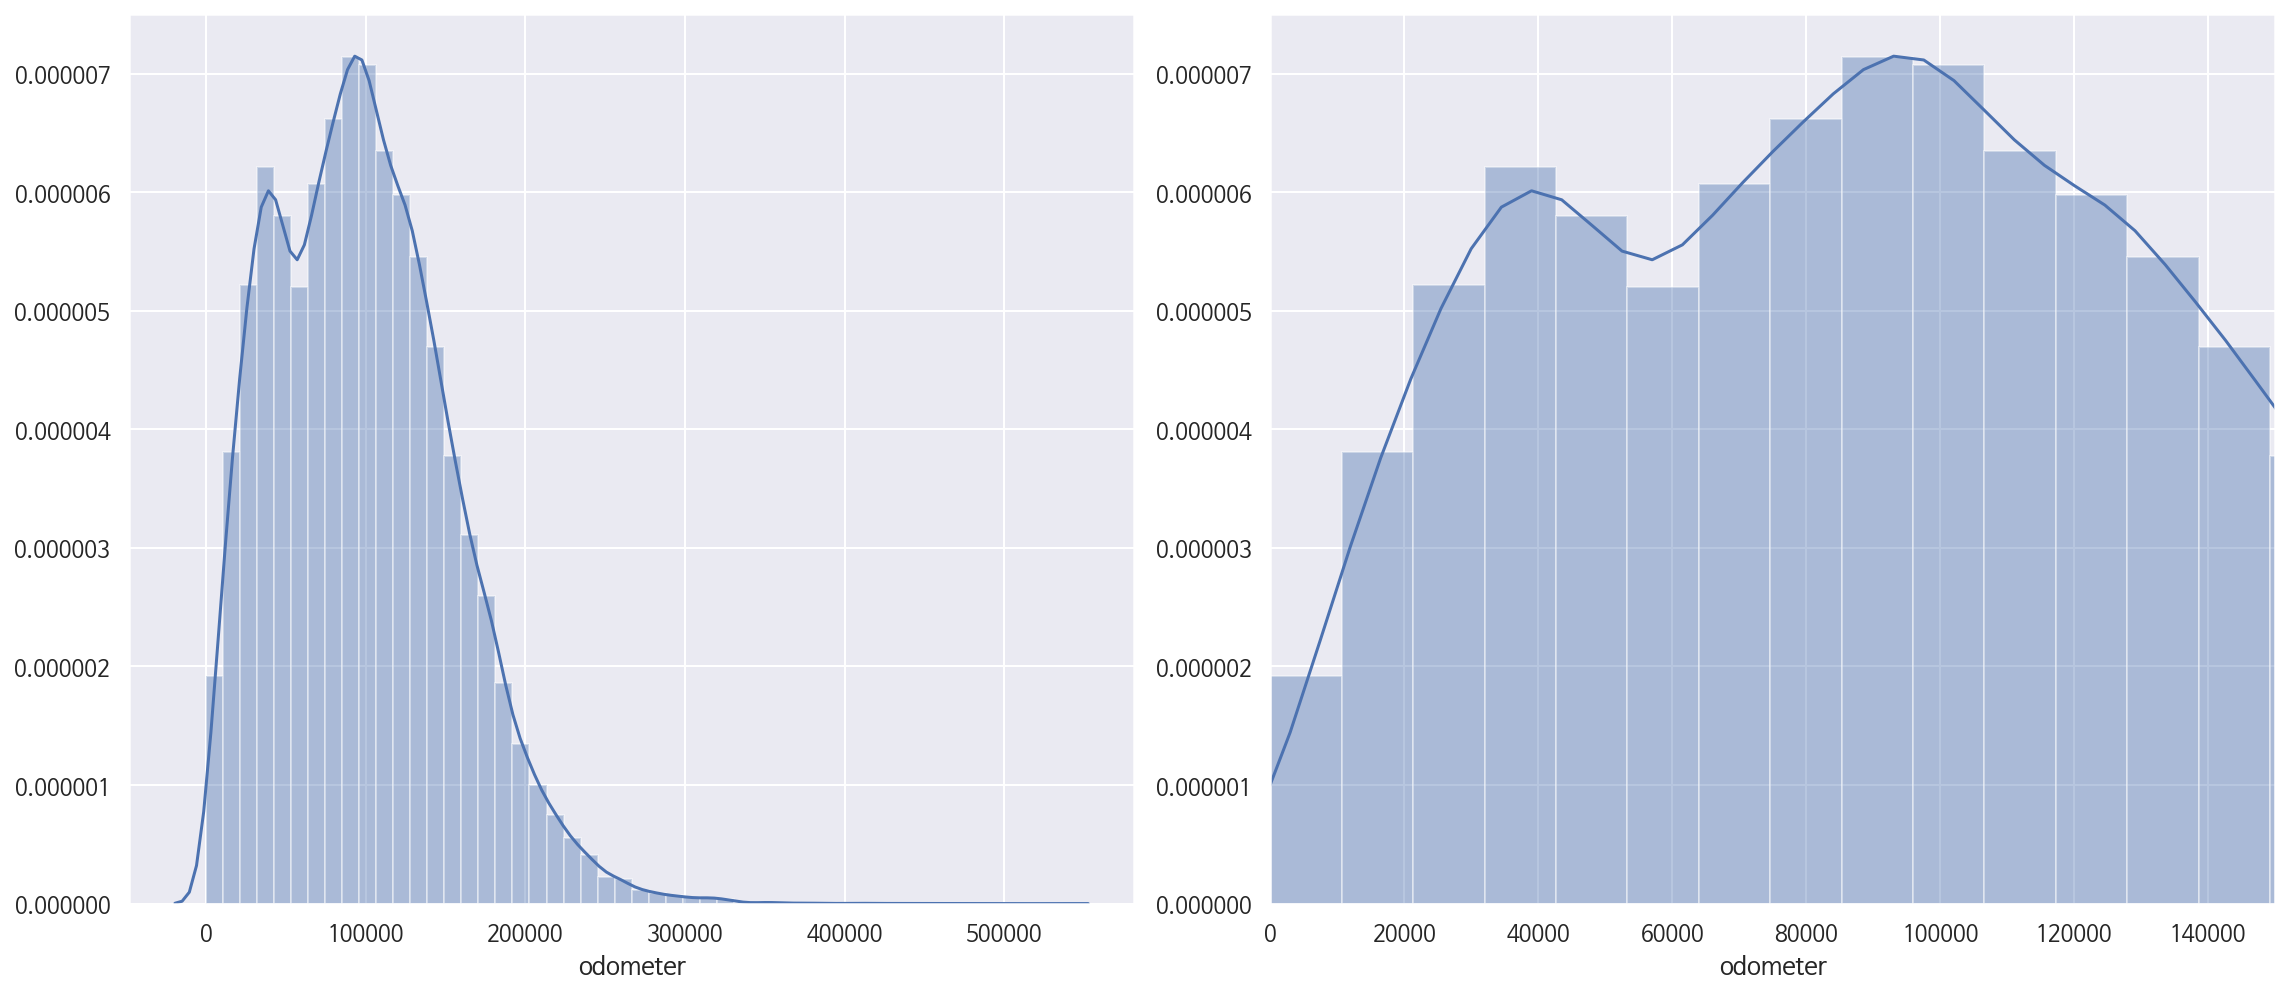

In [302]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.distplot(df['odometer'])
plt.subplot(122)
sns.distplot(df['odometer'])
plt.tight_layout()
plt.xlim(0,150000)
plt.show()

- 6만 마일을 기준으로 이하는 0, 초과는 1의 값을 가지는 카테고리 데이터 추가

In [303]:
df['odometer_under_100000'] =  df['odometer'].apply(lambda x:  0 if x >= 60000 else 1)
df['odometer_under_100000'].unique()

array([0, 1])

In [304]:
usedcar = UsedCarRegression(df)

In [305]:
model5_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive)+scale(I(year**2))+scale(I(year**3)) + C(odometer_under_100000)"

In [306]:
model5_min_df = summary_minimize_df(result, 'Model 5')
pd.concat([model1_min_df,model2_min_df,model3_min_df,model4_min_df,model5_min_df],axis=1)

,Model 1,Model 2,Model 3,Model 4,Model 5
R-squared,0.8564659,0.8655252,0.8566628,0.8890430,0.8915887
Adj. R-squared,0.8560507,0.8649064,0.8561001,0.8882259,0.8907854
F-statistic,2063.0965475,1398.6086807,1522.3565507,1088.0338288,1109.9328972
Prob (F-statistic),0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
Log-Likelihood,-2847.3003931,-1050.6899778,-2192.5734426,2910.3790512,3429.5072240
AIC,5954.6007861,2431.3799556,4667.1468853,-5164.7581024,-6199.0144480
BIC,7086.6985592,3831.5301967,5863.6389095,-2308.3883365,-3325.2277933


### R2 score 확인

In [307]:
result, train_data, test_data, train_ls, test_ls = usedcar.model_fit(model5_formula)
pred = result.predict(test_data)
r2_score(np.log(test_data['price']),pred)

0.8893590415842408

### 교차 검증

In [308]:
cross_validation_model5 = usedcar.cross_validation(model5_formula)
cross_validation_model5

[0.888923100714242,
 0.8866448955190362,
 0.8839108140692197,
 0.8888625600455157,
 0.8802532264267724,
 0.88569808285339,
 0.8798760601988522,
 0.8925682631954428,
 0.8895007080671937,
 0.8859673024204788]

# model6
- Model 4에서 Ridge, Lasso, Elastic Net를 이용

In [309]:
df = df.drop('odometer_under_100000',axis=1)
df.shape

(55942, 12)

In [310]:
usedcar = UsedCarRegression(df)

In [311]:
model6_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive)+scale(I(year**2))+scale(I(year**3)) "

In [312]:
result, train_data, test_data, train_ls, test_ls = usedcar.model_fit(model6_formula)

In [409]:
from tqdm.notebook import tqdm
bar_total = tqdm(np.arange(0.00001,0.0005,0.00001))

lasso_ls=[]
for i in bar_total:
    lasso_result = usedcar.regularized_method(model6_formula, cv=5, alpha=i ,L1_wt=1)  
    lasso_ls.append({
        "alpha" : i,
        "Lasso" : lasso_result
    })

In [410]:
lasso_df = pd.DataFrame(lasso_ls)
lasso_df.to_csv('./lasso.csv')

In [412]:
from tqdm.notebook import tqdm
bar_total = tqdm(np.arange(0.00001,0.0005,0.00001))

ridge_ls=[]
for i in bar_total:
    ridge_result = usedcar.regularized_method(model6_formula,cv=5, alpha=i, L1_wt=0)
    ridge_ls.append({
        "alpha" : i,
        "Ridge" : ridge_result
    })

In [413]:
ridge_df = pd.DataFrame(ridge_ls)
ridge_df.to_csv('./ridge.csv')

In [414]:
from tqdm.notebook import tqdm
bar_total = tqdm(np.arange(0.00001,0.0005,0.00001))

elastic_net_ls=[]
for i in bar_total:
    elastic_net_result = usedcar.regularized_method(model6_formula,cv=5, alpha=i, L1_wt=0.5)
    elastic_net_ls.append({
        "alpha" : i,
        "Elastic_net" : elastic_net_result
    })

In [205]:
elastic_net_df = pd.read_csv('./elastic.csv',index_col=[0])
ridge_df = pd.read_csv('./ridge.csv',index_col=[0])
lasso_df = pd.read_csv('./lasso.csv',index_col=[0])

In [206]:
lasso_df['Lasso'] = lasso_df['Lasso'].str.extract(r'(0[.][0-9]*)').astype('float')
ridge_df['Ridge'] = ridge_df['Ridge'].str.extract(r'(0[.][0-9]*)').astype('float')
elastic_net_df['Elastic_net']  = elastic_net_df['Elastic_net'].str.extract(r'(0[.][0-9]*)').astype('float')

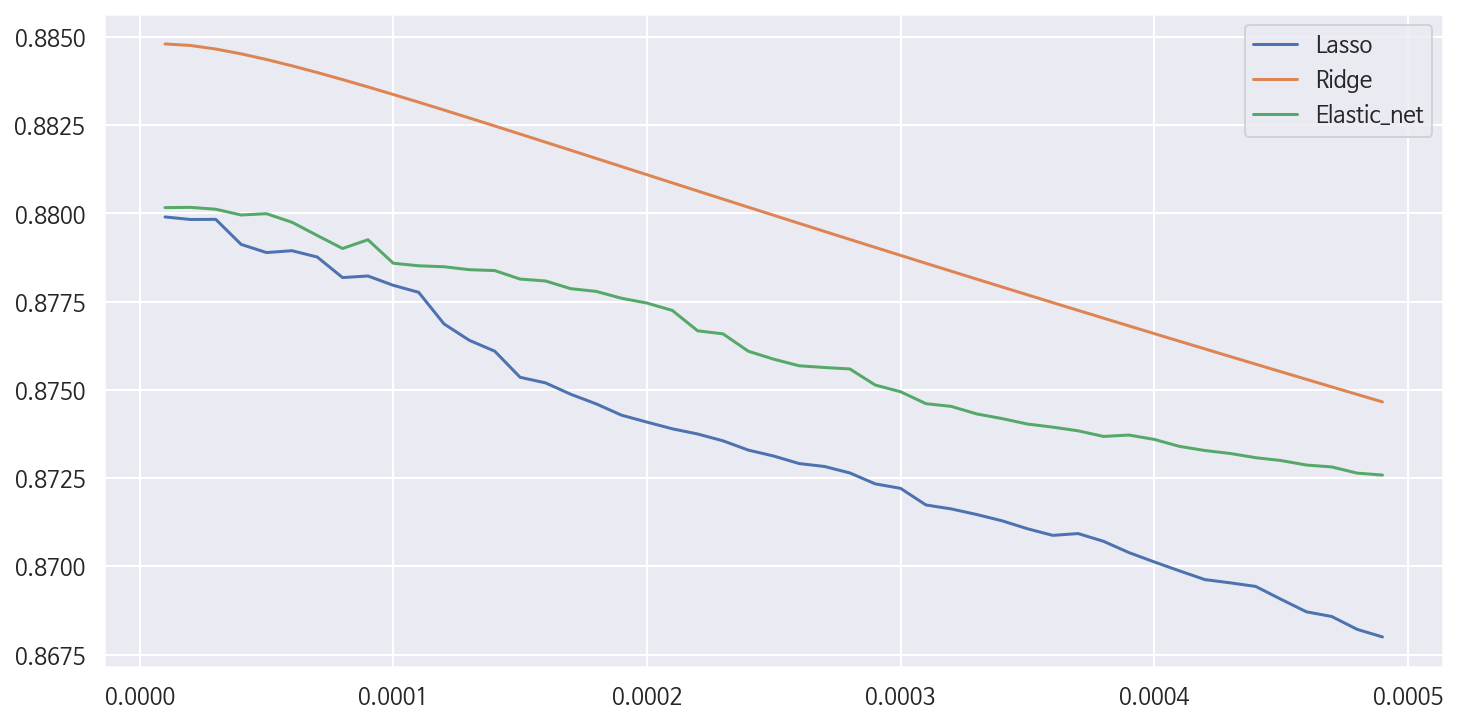

In [211]:
plt.figure(figsize=(12,6))
plt.plot('alpha','Lasso',data=lasso_df)
plt.plot('alpha','Ridge',data=ridge_df)
plt.plot('alpha','Elastic_net',data=elastic_net_df)
plt.legend()
plt.show()

In [313]:
model6_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive)+scale(I(year**2))+scale(I(year**3))"

In [314]:
from used_car_regression import UsedCarRegression

In [315]:
usedcar = UsedCarRegression(df)

In [316]:
result, train_data, test_data, train_ls, test_ls = usedcar.model_fit(model6_formula)

In [317]:
score, result, cross_validation_model6 = usedcar.regularized_method(
    model6_formula, cv=10, alpha=0.00001, L1_wt=0)

# k-fold 검증 성능 비교

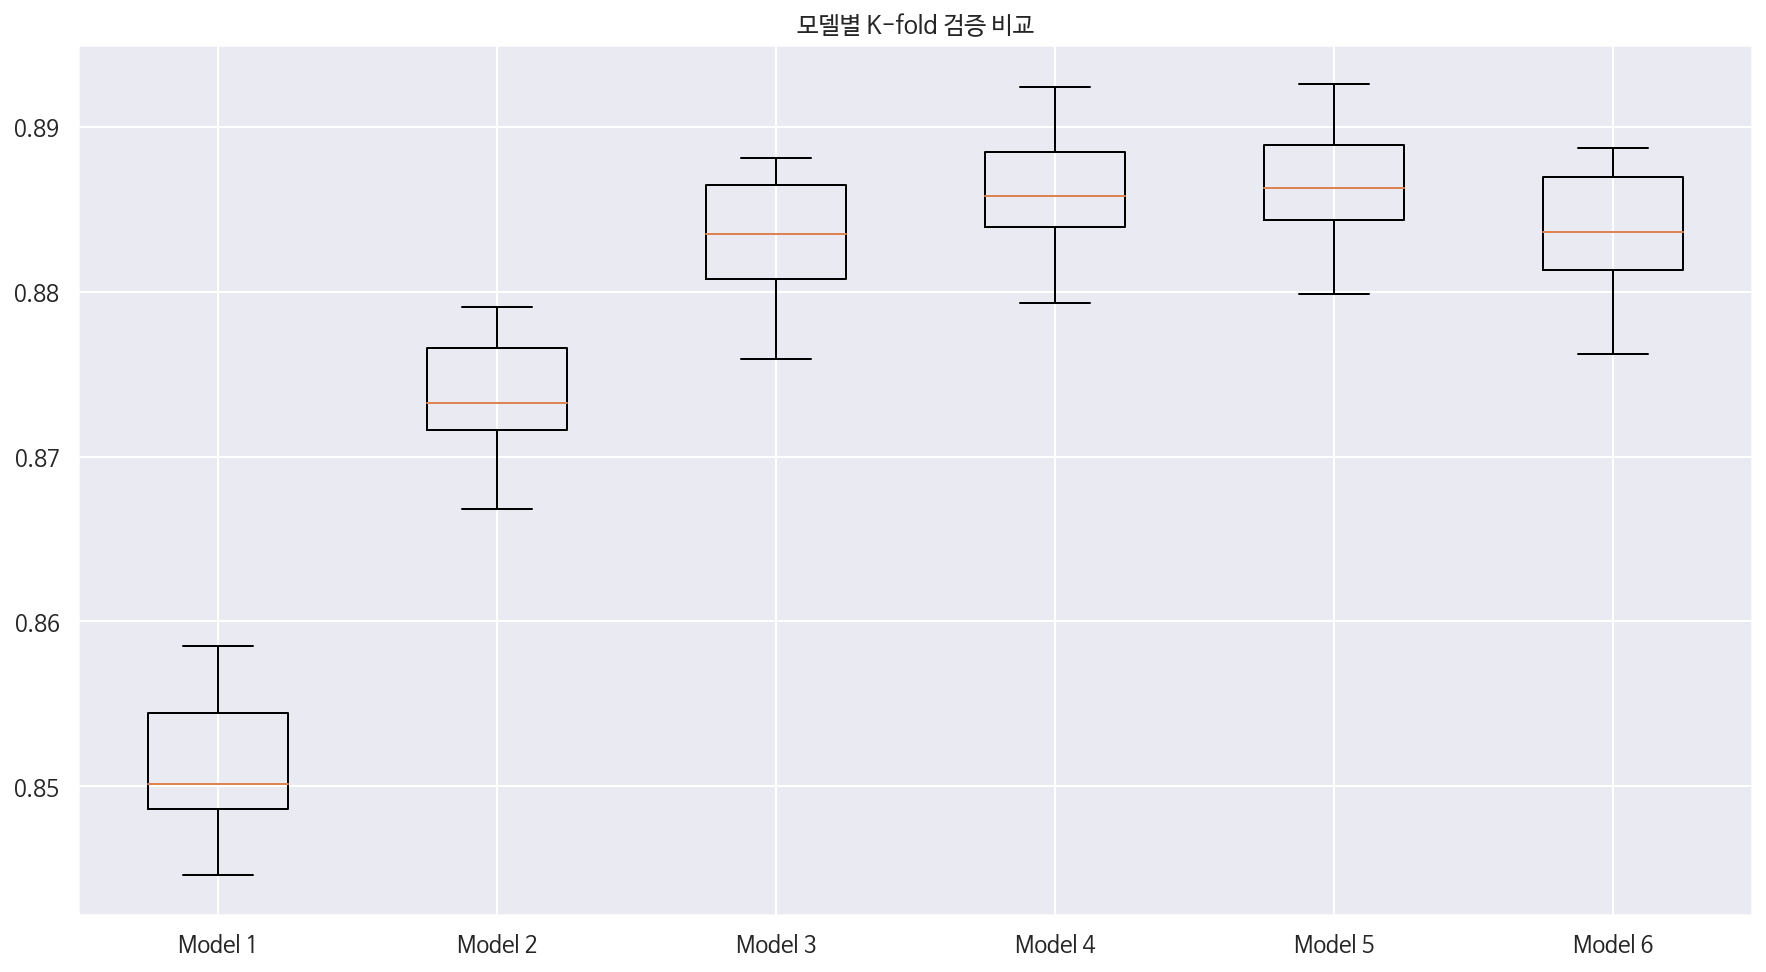

In [318]:
# odometer 6만
fig, ax = plt.subplots(figsize=(15, 8))
ax.boxplot(
    [
        cross_validation_model1, cross_validation_model2,
        cross_validation_model3, cross_validation_model4,
        cross_validation_model5, cross_validation_model6
    ],
    sym="b*",
    labels=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'],
)
plt.title('모델별 K-fold 검증 비교')
plt.show()

# 각 모델별 Test 데이터로 예측한 R-sqaure

In [320]:
model1_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)"

In [321]:
result = usedcar.model_fit(model1_formula)
prediction = result[0].predict(test_data[test_data.columns.difference(['price'])])
model_1_test_r2 = r2_score(np.log(test_data['price']),prediction)
print("Model 1 R-sqaure : ", model_1_test_r2)

Model 1 R-sqaure :  0.8548625011771483


In [322]:
model2_formula = "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer)"

In [323]:
result= usedcar.model_fit(model2_formula)
prediction = result[0].predict(test_data[test_data.columns.difference(['price'])])
model_2_test_r2 = r2_score(np.log(test_data['price']),prediction)
print("Model 2 R-sqaure : ", model_2_test_r2)

Model 2 R-sqaure :  0.870369668131005


In [324]:
model3_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer)+C(manufacturer):C(cylinders)+C(type):C(drive)"

In [325]:
result= usedcar.model_fit(model3_formula)
prediction = result[0].predict(test_data[test_data.columns.difference(['price'])])
model_3_test_r2 = r2_score(np.log(test_data['price']),prediction)
print("Model 3 R-sqaure : ", model_3_test_r2)

Model 3 R-sqaure :  0.8812740617332774


In [326]:
model4_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer)+C(manufacturer):C(cylinders)+C(type):C(drive)+scale(I(year**2))+scale(I(year**3))+scale(I(year**4))"

In [327]:
result = usedcar.model_fit(model4_formula)
prediction = result[0].predict(test_data[test_data.columns.difference(
    ['price'])])
model_4_test_r2 = r2_score(np.log(test_data['price']), prediction)
print("Model 4 R-sqaure : ", model_4_test_r2)

Model 4 R-sqaure :  0.8851316612667169


In [334]:
model5_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive)+scale(I(year**2))+scale(I(year**3)) + C(odometer_under_100000)"

In [335]:
df['odometer_under_100000'] =  df['odometer'].apply(lambda x:  0 if x >= 60000 else 1)

In [336]:
usedcar = UsedCarRegression(df)

In [338]:
test_data['odometer_under_100000'] =  test_data['odometer'].apply(lambda x:  0 if x >= 60000 else 1)

In [337]:
result = usedcar.model_fit(model5_formula)
prediction = result[0].predict(test_data[test_data.columns.difference(
    ['price'])])
model_5_test_r2 = r2_score(np.log(test_data['price']), prediction)
print("Model 5 R-sqaure : ", model_5_test_r2)

Model 5 R-sqaure :  0.8893334335922884


In [339]:
test_data = test_data.drop('odometer_under_100000',axis=1)
df = df.drop('odometer_under_100000',axis=1)

In [340]:
model6_formula =  "np.log(price) ~ scale(odometer) + scale(year) +C(manufacturer)+C(cylinders)+C(drive)+C(fuel)+C(state)+C(title_status)+C(transmission)+C(type)+C(paint_color)+scale(odometer):C(cylinders)+scale(odometer):C(type)+scale(year):C(manufacturer) + scale(year):C(type) + scale(odometer):C(fuel) + C(manufacturer):C(cylinders)+C(type):C(drive)+scale(I(year**2))+scale(I(year**3))"

In [341]:
result, train_data, test_data, train_ls, test_ls = usedcar.model_fit(model6_formula)

In [342]:
score, result, cross_validation_model6 = usedcar.regularized_method(
    model6_formula, cv=10, alpha=0.00001, L1_wt=0)

In [343]:
prediction = result.predict(test_data[test_data.columns.difference(
    ['price'])])
model_6_test_r2 = r2_score(np.log(test_data['price']), prediction)
print("Model 6 R-sqaure : ", model_6_test_r2)

Model 6 R-sqaure :  0.8880737274984406


In [344]:
final_result = {
    "model 1": model_1_test_r2,
    "model 2": model_2_test_r2,
    "model 3": model_3_test_r2,
    "model 4": model_4_test_r2,
    "model 5": model_5_test_r2,
    "model 6": model_6_test_r2,
}

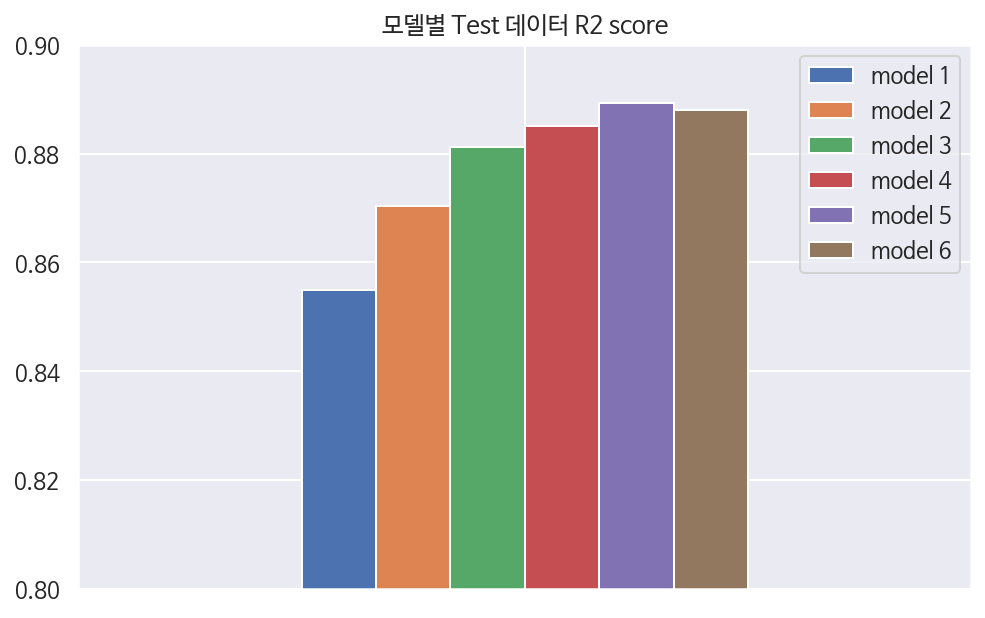

In [345]:
pd.DataFrame(final_result,index=[0]).plot.bar()
plt.ylim(0.8,0.9)
plt.title('모델별 Test 데이터 R2 score')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom Edge are off
    top=False,         # ticks along the top Edge are off
    labelbottom=False) # labels along the bottom Edge are off
plt.show()

# 3. 가설검증

### 가설 1번
- 주행거리 5만킬로 미터 이하일때 파는게 좋을것이다.

In [391]:
sigma_2_df['vehicle'].value_counts()[:5]

2012 Ford F-150 FX4                 134
2014 Chevrolet Silverado 1500 LT    131
2010 Ford F-150 XL                  125
2011 Chevrolet Silverado 1500 LT    115
2016 Chevrolet Silverado 1500 LT    112
Name: vehicle, dtype: int64

In [106]:
data = sigma_2_df[sigma_2_df['vehicle'] == "2012 Ford F-150 FX4"]
data = data[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]

In [107]:
def hypothesis_proof(df,result):
    # odometer 외의 컬럼은 다 최빈값으로 채운다
    for column in df.columns.difference(['price','odometer']):
        df[column] = df[column].value_counts().keys()[0]

    df['odometer'] = range(0,len(df)*1000,1000)
    df.reset_index(drop=True)
    

    return np.exp(result.predict(df)), df

In [108]:
hypothesis_1, data = hypothesis_proof(data, result)

In [109]:
## structured change

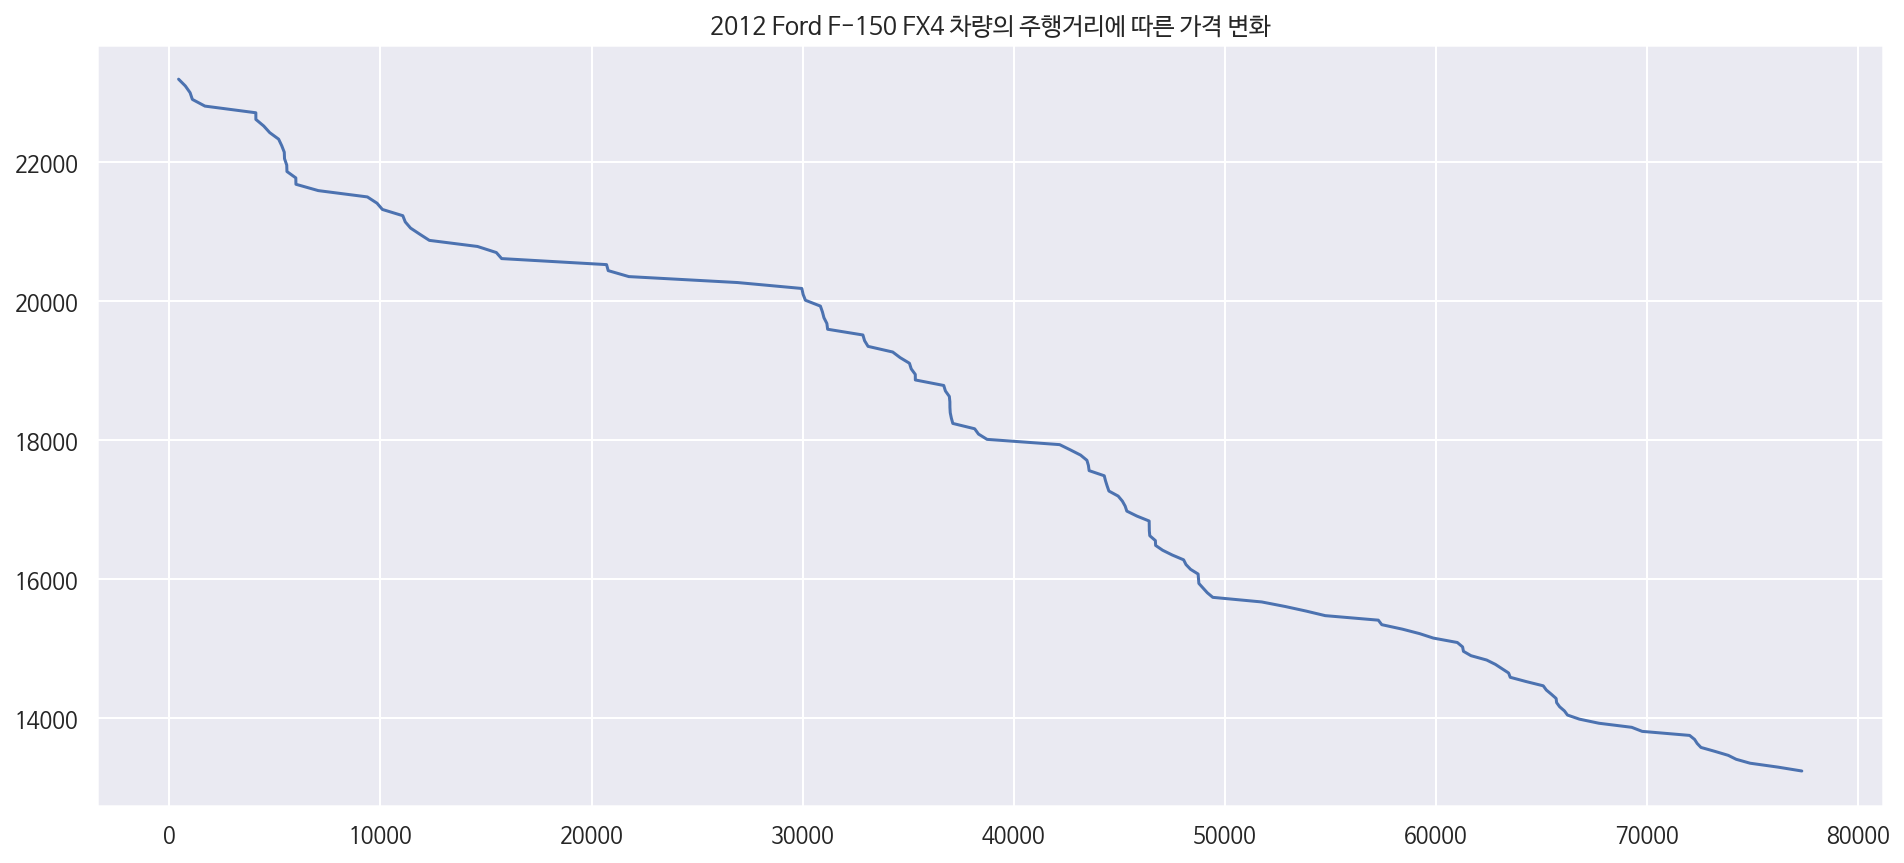

In [110]:
plt.figure(figsize=(16,7))
plt.plot(hypothesis_1)
plt.title("2012 Ford F-150 FX4 차량의 주행거리에 따른 가격 변화")
plt.show()

## 가설 2
- 지역별 가격차이가 있을 것이다

In [111]:
anova = sm.stats.anova_lm(result, typ=2)
anova.sort_values(by=['F'],ascending=False)

/Users/yoohowon/opt/anaconda3/envs/fastcampus/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/Users/yoohowon/opt/anaconda3/envs/fastcampus/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 10
  'rank is %d' % (J, J_), ValueWarning)
/Users/yoohowon/opt/anaconda3/envs/fastcampus/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 210, but rank is 134
  'rank is %d' % (J, J_), ValueWarning)
/Users/yoohowon/opt/anaconda3/envs/fastcampus/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 22
  'r

,sum_sq,df,F,PR(>F)
scale(odometer),1117.7132658,1.0000000,22089.0541881,0.0000000
C(fuel),290.5519560,4.0000000,1435.5242300,0.0000000
scale(year),72.1361052,1.0000000,1425.6056412,0.0000000
scale(I(year ** 2)),51.7489501,1.0000000,1022.7000063,0.0000000
scale(I(year ** 3)),51.7201836,1.0000000,1022.1315012,0.0000000
C(drive),71.9863412,2.0000000,711.3229486,0.0000000
C(cylinders),165.5087893,6.0000000,545.1506403,0.0000000
C(type),228.5629216,12.0000000,376.4187497,0.0000000
scale(odometer):C(fuel),44.3920698,4.0000000,219.3270100,0.0000000
C(manufacturer),360.0819816,35.0000000,203.3199811,0.0000000


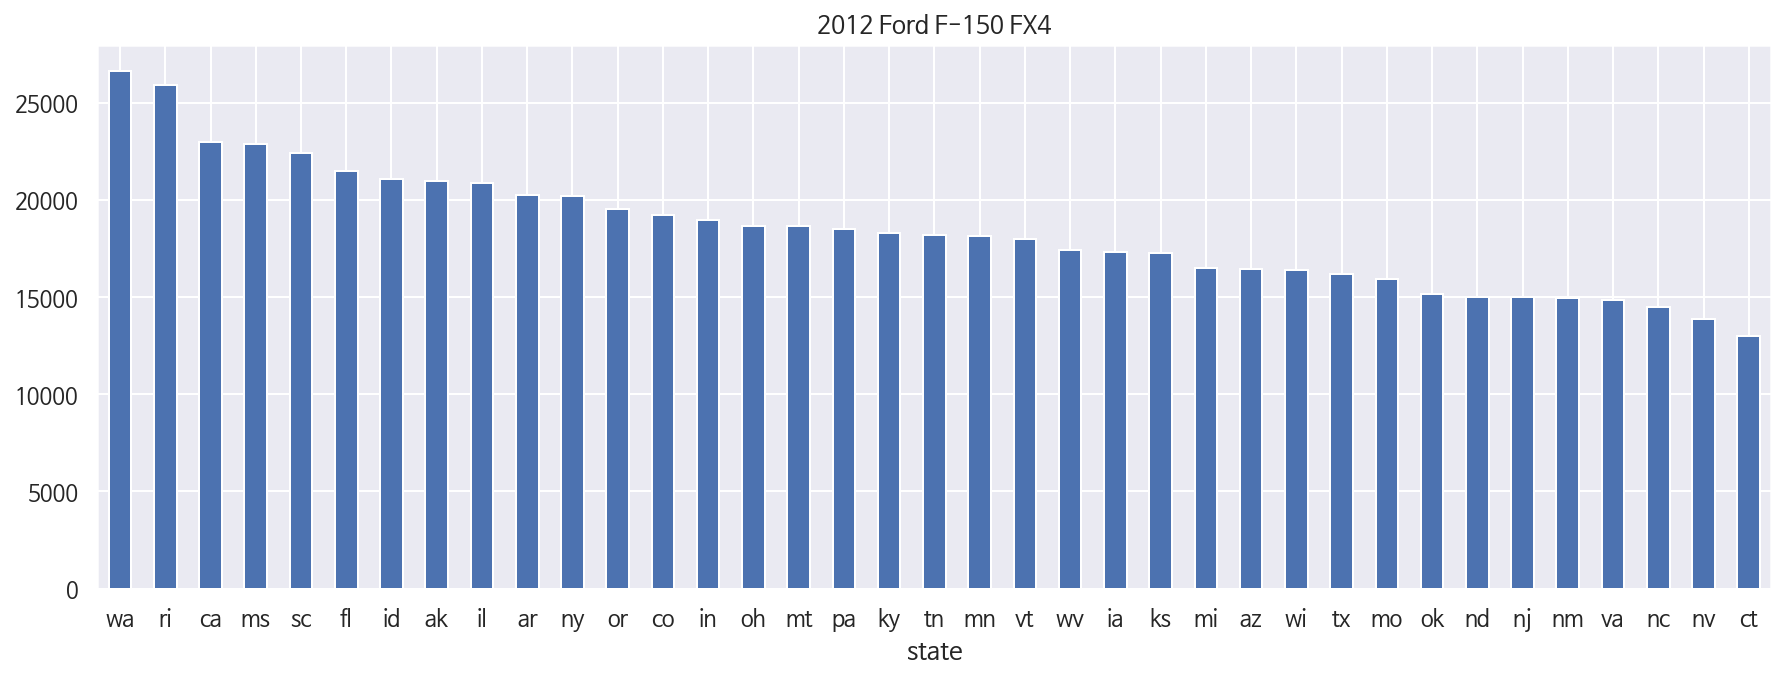

In [230]:
plt.figure(figsize=(15,5))
data.groupby('state').mean()['price'].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=0)
plt.title("2012 Ford F-150 FX4")
plt.show()

# 회고

### 아쉬운점
- 자동차 보증수리 여부에 대한 데이터의 부재로, Model 5의 아이디어를 좀더 발전 시키지 못함.